In [1]:
#just importing required libraries to read data from xml file

import pprint
from xml.etree.ElementTree import ElementTree as ET
from pandas.io.json import json_normalize
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from collections import Counter

from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint

In [2]:
filename='/home/oto/Downloads/mumbai'   # this is the xml file I have downloaded from openstreetmap for mumbai

In [3]:
#creating a dictionary from the xml file to store required fields/nodes

tree = ET().parse(source=filename)
nodes_data = {}   # the empty dictionary update with below code 
for node in tree.findall('./node'):
    k = 'node_' + node.attrib['id']   # custom node key
    nodes_data[k] = node.attrib
    tag_attribs = list(zip(*[tag.attrib.items() for tag in list(node)]))
    if not tag_attribs:
        nodes_data[k].update({'k': [], 'v': []})
    else:
        k_items, v_items = zip(*[tag.attrib.items() for tag in list(node)])
        nodes_data[k].update({'k': [t[1] for t in k_items], 'v': [t[1] for t in v_items]})

In [4]:
# Now the dictionary looks like this:
# you take run following line but it takes time to load 
# pprint.pprint(nodes_data)  

In [5]:
nodes=list(pd.DataFrame(list(nodes_data.items()))[0])  #getting the unique nodes from the dictionary, which helps
# identifying other tages from the dictionary.

In [6]:
# creating the lists from the dictionary, with latitude, longitude, and all possible tags, 
lat=[]
lon=[]
names=[]
values=[]
for i in nodes:
    la=nodes_data.get(i).get('lat')  #finds the latitude
    lo=nodes_data.get(i).get('lon')  # finds longitude
    nam=nodes_data.get(i).get('k')  # other nodes
    val=nodes_data.get(i).get('v')  # and their value
    lat.append(la)
    lon.append(lo)
    names.append(nam)
    values.append(val)

In [7]:
attributes=list(set([item for sublist in names for item in sublist]))  # all possible tags strong in a list, which
#will be used as columns when we create a dataframe

#I want node, lat and long to be the first three columns of the data frame hence, pushing this into the list
attributes.insert(0,'lon')
attributes.insert(0,'lat')
attributes.insert(0,'node')

In [8]:
df=pd.DataFrame(columns=attributes)  # creating the dataframe with lat, lon and all possible xml tags associated with the node
df['node']=nodes   # assigning the nodes first

In [9]:
#Now the dataframe look like this,
df.head()

,node,lat,lon,display,drive_through,consulate,name:ks,phone,diplomatic,tactile_paving,...,currency:INR,disused,population:date,emergency,name:sd,name:ur,name_1,Mahesh Jain,aeroway,short_name
0,node_16173235,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,node_30518346,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,node_30518350,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,node_30518352,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,node_30518417,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# Now we want to fill other columns, to fill those we will use two lists, names and values.
# if the column name presents in names list it will fetch the corresponding value from value list and put it into 
# corresponding columns
df.update(pd.concat([pd.DataFrame(data=[z],columns=y,index=[x]) for x , (y, z) in enumerate(zip(names,values))]))

/home/oto/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


In [11]:
#assign lat and long value to the dataframe 
df['lat']=lat
df['lon']=lon
#now the dataframe is updated we can check
df.head()

,node,lat,lon,display,drive_through,consulate,name:ks,phone,diplomatic,tactile_paving,...,currency:INR,disused,population:date,emergency,name:sd,name:ur,name_1,Mahesh Jain,aeroway,short_name
0,node_16173235,18.9387711,72.8353355,NaN,NaN,NaN,بَمبَے,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,ممبئي,ممبئی,NaN,NaN,NaN,NaN
1,node_30518346,19.0081628,72.8370430,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,node_30518350,18.9834077,72.8328729,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,node_30518352,18.9666156,72.8365647,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,node_30518417,19.1742132,72.9588061,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
#dropping those columns where no tag value is present, we are going to word with only those values where atleast
# one tag value is present

df=df.dropna(thresh=4)  # 4 is for we are dropping the rows where the values are null from fourth column.
df = df.replace(np.nan, 'nan', regex=True)
df = df.applymap(lambda s:s.lower() if type(s) == str else s)

In [13]:
# Now we are going to categorise every latitude and longitude in a category (it's about the belonging of a particular point)

df['category']=None  # lets create the column first with nan values. 

# let's print total number of points we are working with, 
print(len(df))

11905


In [14]:
# Now we have to categorise the points, so lets see what are the values and count of those per columns to get the
#rough idea about the categories and how to implement it.

for i in range(3,len(list(df.columns))):
    print(list(df.columns)[i])  # printing the count of each values with their columns 
    print(Counter(df[df.columns[i]]))
    print('____________________________________________') #the seperator

display
Counter({'nan': 11904, 'analog': 1})
____________________________________________
drive_through
Counter({'nan': 11887, 'no': 17, 'yes': 1})
____________________________________________
consulate
Counter({'nan': 11904, 'consulate_general': 1})
____________________________________________
name:ks
Counter({'nan': 11904, 'بَمبَے': 1})
____________________________________________
phone
Counter({'nan': 11742, '+919969543518': 2, '02269940010': 2, '02226422250': 1, '022 2643 5361': 1, '2265 5657': 1, '22020591': 1, '+91-22-2352-9082': 1, '+91 22 2265 4194 / 2263 0393': 1, '+91 22 6657 3939': 1, '022 2202 1043': 1, '22020642': 1, '022 2363 0943': 1, '9821580312': 1, '022 2207 3830': 1, '+91 22 26400166': 1, '+91 98703 64444': 1, '+91-22-24962125': 1, '+91-(22)-23099313': 1, '+91 02224306415': 1, '+91 22 61540100': 1, '+91-22-2351-7101': 1, '+912223421400': 1, '097 02 540638': 1, '098 92 916458': 1, '9999154404': 1, '23478310/23475922': 1, '22833769': 1, '+91 22 2265 0195': 1, '22021447

Counter({'nan': 11901, 'asphalt': 4})
____________________________________________
natural
Counter({'nan': 9244, 'tree': 2653, 'bay': 3, 'cape': 2, 'peak': 1, 'beach': 1, 'stone': 1})
____________________________________________
addr:unit
Counter({'nan': 11891, '1': 2, '3': 2, '14': 1, '6': 1, '11': 1, '4': 1, '1-2': 1, 'sefa house': 1, 'shop no. 8, sefa house, a wing': 1, 'shop no. 7, sefa house, a wing': 1, 'sefa house, a wing': 1, 'colaba': 1})
____________________________________________
old_name:sr
Counter({'nan': 11904, 'бомбај': 1})
____________________________________________
old_name:ar
Counter({'nan': 11904, 'بومباي': 1})
____________________________________________
traffic_signals
Counter({'nan': 11797, 'signal': 107, 'traffic_lights': 1})
____________________________________________
brand:wikidata
Counter({'nan': 11842, 'q1340361': 6, 'q2003549': 6, 'q631047': 5, 'q2018840': 4, 'q38076': 4, 'q2003797': 4, 'q1653258': 3, 'q2003611': 3, 'q2743499': 2, 'q2003777': 2, 'q2004439

Counter({'nan': 11901, 'colaba': 3, 'junction of linking d & s.v. road': 1})
____________________________________________
supervised
Counter({'nan': 11904, 'yes': 1})
____________________________________________
departures_board
Counter({'nan': 11903, 'no': 2})
____________________________________________
delivery
Counter({'nan': 11890, 'yes': 14, 'free home delivery': 1})
____________________________________________
name:hi
Counter({'nan': 11886, 'मुंबई': 1, 'राजभवन': 1, 'बांद्रा': 1, 'मुंबई शहर व नागरी सत्र न्यायालय': 1, 'होमी भाभा सभागृह': 1, 'तिलक नगर': 1, 'तारापोरवाला मत्स्यालय': 1, 'नरीमन पोइंट': 1, 'राजाबाई घंटाघर': 1, 'पिकाले अस्पताल': 1, 'हसनाबाद दरगाह': 1, 'भारतीय हवामान विभाग': 1, 'भारतीय राष्ट्रीय कुत्र्यासाठी घर क्लब': 1, 'जिंदाल हवेली': 1, 'नेहरू सेंटर आर्ट गलरी': 1, 'पालस रॉयाल': 1, 'एमटीएनएल टेलिफोन एक्सचेंज': 1, 'नेहरू तारामंडल': 1, 'भारतीय चित्रपट राष्ट्रीय संग्रहालय': 1})
____________________________________________
station
Counter({'nan': 11895, 'monorail': 9, 'term

In [15]:
# lets look at amenities column first, looking at those values we can make category (for example, restaurant, bar etc)

# So lets make a list of list from amenities and club it inside another list, whatever we think similar

amenities=[['restaurant','fast_food'], ['place_of_worship'], ['bank'], ['cafe'], ['toilets'], ['atm'],
           ['educational_institution','school','kindergarten'], ['fuel'],['hospital'], ['pharmacy'], ['police'], ['bus_station'],
           ['bar'], ['parking'], ['educational_institution','college'], ['post_office'],['embassy'], ['cinema','theatre'],
           ['clinic','doctors','childcare','dentist','veterinary'], ['pub','nightclub'], ['fire_station'],
           ['community_centre','townhall','library','arts_centre','music_school','post_box'],['leisure','gym'],['marketplace']]

# Now match these values with the amenities columns in dataframe and assign a category,
# the first elements of the lists inside, are the category and rests belongs to that category,

# this can be implemented using following code,

for i in amenities:
    for j in i:  #when category is null, and column value matches,
        df.loc[(df.category.isnull())&(df.amenity.str.contains(j)),'category']=i[0]  #i[0] the first values of the lists

In [16]:
# same thing we are implementing for shops,

shops=[['convenience','department_store','dairy','deli','beverages'],
       ['boutique','clothes','fashion','shoes','tailor'],
       ['supermarket','mall','bag'], ['salon','hairdresser','beauty','tattoo','massage'],
       ['accessories','jewelry'],['bakery','confectionery','pastry','indian_mithai_(sweets)','indian_mithai_(sweets)'], 
       ['travel_agency','ticket'],['local_shop','street_vendor'], ['books'],
       ['pharmacy','chemist','medical_supply'],['butcher'],['vehicle','car','bicycle','motorcycle'],
       ['vehicle_repair','car_repair','car_parts','motorcycle_repair'],['electronics', 'mobile_phone','computer'],
       ['wine_shop','alcohol','wine','liquer','tobacco','party'], ['gift_shop','gift','handicrafts_store','kiosk','art'],
       ['hardware_shop','doityourself','furniture','hardware','home_furnishings','battery','gas'],
       ['cafe','tea','copyshop'],['clinic','optician'],['laundry','dry_cleaning'],
       ['local_shop','variety_store','cosmetics','florist','hifi'],['local_shop','musical_instrument','music'],['leisure','sports','outdoor'],
       ['local_shop','photo','office','photocopies,_lamination,_printouts_,_bindings_etc.']]

for i in shops:
    for j in i:
        df.loc[(df.category.isnull())&(df.shop.str.contains(j)),'category']=i[0]

/home/oto/.local/lib/python3.6/site-packages/pandas/core/strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [17]:
# if the websites have bank word in it, we are categorising as bank

banknames=['bank','idbi','iob','pnb','kotak','sbi']
for i in banknames:
    df.loc[df.website.str.contains(i,na=False),'category']='bank'

In [18]:
# the cuisine value is applicable only for restaurants, so,
df.loc[(df.category.isnull())&(df.cuisine!='nan'),'category']='restaurant'

#whrn office columns are having the keywords like following('company',government etc, we are categorising)
df.loc[(df.category.isnull())&(df.office.str.contains('company',na=False)),'category']='private_company'
df.loc[(df.category.isnull())&(df.office.str.contains('government',na=False)),'category']='government_office'
df.loc[(df.category.isnull())&(df.office.str.contains('financial',na=False)),'category']='bank'
df.loc[(df.category.isnull())&(df.office.str.contains('educational_institution',na=False)),'category']='educational_institution'
df.loc[(df.category.isnull())&(df.office.str.contains('administrative',na=False)),'category']='government_office'
df.loc[(df.category.isnull())&(df.office.str.contains('diplomatic',na=False)),'category']='government_office'

# and any other office we are categorising as private company
df.loc[(df.category.isnull())&(df.office!='nan'),'category']='private_company'

In [19]:
# when following columns (species,denomination,religion,leisure etc.) are not null, we are categorising, because all 
# these belongs to a certain category.

df.loc[df.species!='nan','category']='tree'
df.loc[df.denomination!='nan','category']='place_of_worship'
df.loc[df.religion!='nan','category']='place_of_worship'
df.loc[df.leisure!='nan','category']='leisure'
df.loc[(df.category.isnull())&(df.wikipedia.str.contains('railway station')),'category']='railway_station'
df.loc[(df.category.isnull())&(df.railway!='nan'),'category']='railway_station'

# categorising buildings, with the keywords(apartments, office, hospital etc.) presents in it

df.loc[(df.category.isnull())&(df.building.str.contains('sabal',na=False)),'category']='sabal_project'
df.loc[(df.category.isnull())&(df.building.str.contains('yes',na=False)),'category']='housing'
df.loc[(df.category.isnull())&(df.building.str.contains('apartments',na=False)),'category']='housing'
df.loc[(df.category.isnull())&(df.building.str.contains('residential',na=False)),'category']='housing'
df.loc[(df.category.isnull())&(df.building.str.contains('house',na=False)),'category']='housing'
df.loc[(df.category.isnull())&(df.building.str.contains('office',na=False)),'category']='private_company'
df.loc[(df.category.isnull())&(df.building.str.contains('retail',na=False)),'category']='marketplace'
df.loc[(df.category.isnull())&(df.building.str.contains('hospital',na=False)),'category']='hospital'
df.loc[(df.category.isnull())&(df.building.str.contains('college',na=False)),'category']='educational_institution'

# same for other columns

df.loc[(df.category.isnull())&(df.type.str.contains('palm',na=False)),'category']='tree'
df.loc[(df.category.isnull())&(df.landuse.str.contains('residential',na=False)),'category']='housing'
df.loc[(df.category.isnull())&(df.landuse.str.contains('commercial',na=False)),'category']='private_company'
df.loc[(df.category.isnull())&(df.landuse.str.contains('cemetery',na=False)),'category']='private_company'
df.loc[(df.category.isnull())&(df.type.str.contains('industrial',na=False)),'category']='private_company'
df.loc[(df.category.isnull())&(df['name:en'].str.contains('hostel',na=False)),'category']='hostel'
df.loc[(df.category.isnull())&(df.tourism.str.contains('hostel',na=False)),'category']='hostel'

#when following columns (landmark,shop,junction etc.) are not null, we are categorising, because all 

df.loc[(df.category.isnull())&(df.diplomatic!='nan'),'category']='government_office'
df.loc[(df.category.isnull())&(df.name_1!='nan'),'category']='sabal_project'
df.loc[(df.category.isnull())&(df.landmark!='nan'),'category']='monument'
df.loc[(df.category.isnull())&(df.bench!='nan'),'category']='bus_station'
df.loc[(df.category.isnull())&(df['addr:housename']!='nan'),'category']='housing'
df.loc[(df.category.isnull())&(df.monorail!='nan'),'category']='railway_station'
df.loc[(df.category.isnull())&(df.craft!='nan'),'category']='boutique'
df.loc[(df.category.isnull())&(df.construction!='nan'),'category']='railway_station'
df.loc[(df.category.isnull())&(df.smoking!='nan'),'category']='bar'
df.loc[(df.category.isnull())&(df.natural!='nan'),'category']='tree'
df.loc[(df.category.isnull())&(df.takeaway!='nan'),'category']='restaurant'
df.loc[(df.category.isnull())&(df['addr:street']!='nan'),'category']='road'
df.loc[(df.category.isnull())&(df.internet_access!='nan'),'category']='railway_station'
df.loc[(df.category.isnull())&(df.shop!='nan'),'category']='local_shop'
df.loc[(df.category.isnull())&(df.operator!='nan'),'category']='bus_station'
df.loc[(df.category.isnull())&(df.junction!='nan'),'category']='bus_stop'
df.loc[(df.category.isnull())&(df.aeroway!='nan'),'category']='parking'
df.loc[(df.category.isnull())&(df.station!='nan'),'category']='railway_station'
df.loc[(df.category.isnull())&(df.man_made!='nan'),'category']='monument'
df.loc[(df.category.isnull())&(df.aeroway!='nan'),'category']='parking'
df.loc[(df.category.isnull())&(df.aeroway!='nan'),'category']='parking'
df.loc[(df.category.isnull())&(df.aeroway!='nan'),'category']='parking'
df.loc[(df.category.isnull())&(df.aeroway!='nan'),'category']='parking'
df.loc[(df.category.isnull())&(df.aeroway!='nan'),'category']='parking'

In [20]:
# what we have done for aminities columns, doing the same for name columns

names=[['community_centre','activity','planetarium'],['bus_station','depot','bandstand','junction','bus stop','bus station'],
       ['educational_institution','college'],['housing','apartments','apartment','residency','bungalows','estate','society','co-op',
                    'chs','villa','quarters'],['railway_station','cst','csmt'],
       ['hotel','palace','habitat','mansion','guesthouse'],['community_centre','studio'],['court'],
       ['marketplace','market','bazaar','shopping area','shoppers stop'],
       ['place_of_worship','church','masjid','temple','tempal','ashram','darga','majjid'],
       ['bank'],['cafe','café','ice cream','stall','coffee'],['cinema','cinema-','talkies','amphitheatre'],
       ['police'],['monument','fort','statue','memorial','museum','kala ghoda'],
      ['restaurant','food'],['government_office','office'],['bar','restobar'],['community_centre','beach'],
       ['local_shop','kirana','shop','bhelwala','pav','sandwich','chaas/lassi','stores'],
      ['educational_institution','school','vidyalaya','vidya'],['vehicle','motor'],['hospital','nursing'],['airport'],
       ['private_company','mills','limited','business'],['fuel','petrol','diesel'],['bakery','mithiwala']]

for i in names:
    for j in i:
        df.loc[(df.category.isnull())&(df['name'].str.contains(j)),'category']=i[0]
        
# same foe 'name_en' columns

names_en=[['boutique','fashions','fashion','boutique','shoe'],['hostel'],['court'],['hotel','inn','lodge','guest house','guesthouse',
        'palace','mansion'],
      ['restaurant','bhojanalay','pizzeria','veg','non veg','nonveg','pizza','sandwich','mcdonalds','food',
      'kebab','juices','bistro','thali','paramount',"domino's",'smaaash!','taste','dosa'],['bakery','sweet'],['cinema']]

for i in names_en:
    for j in i:
        df.loc[(df.category.isnull())&(df['name:en'].str.contains(j)),'category']=i[0]
        
df.loc[(df.category.isnull())&(df.tourism!='nan'),'category']='monument'

In [21]:
# Once we found the categories, we dont need others columns,
df_filtered=df[['node','lat','lon','category']]

In [22]:
# removing the rows where we couldn't identify the categories, 

df_filtered=df_filtered[df_filtered.category.notnull()]

In [23]:
# Lets check the number of points (points of interest) to cluster
print('total number of points are '+str(len(df_filtered)))

total number of points are 5284


In [24]:
# Now we found the point of interest, lets, convert this to ESRI shapefile, as required, 
from shapely.geometry import Point
df1=df_filtered.copy() # copying the file, because original file is required for further, work
df1['geometry'] = df1.apply(lambda x: Point((float(x.lon), float(x.lat))), axis=1)
import geopandas
df1 = geopandas.GeoDataFrame(df1, geometry='geometry')
df1.to_file('mumbai_lat_lon.shp', driver='ESRI Shapefile') #converted to shapefile

In [25]:
#converting lat and lon to float from string type
df_filtered.lat=df_filtered.lat.astype(float)
df_filtered.lon=df_filtered.lon.astype(float)

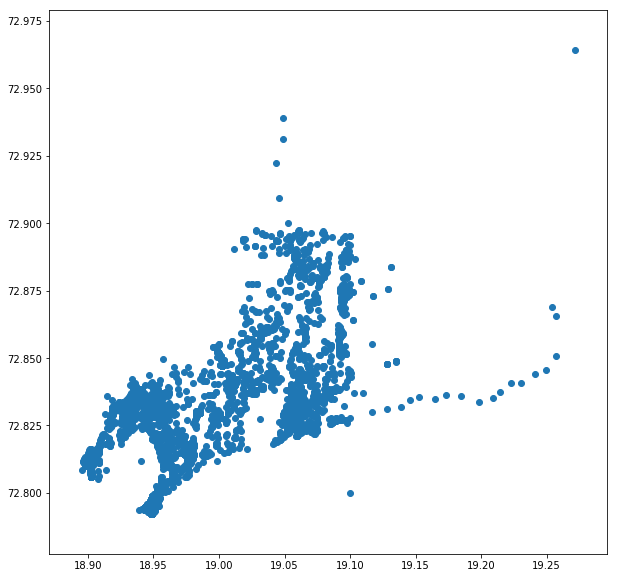

In [26]:
# lets plot all the points and look at the shape, This will help us to identiy what kind of clustering approach 
# we should follow

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.scatter(x=df_filtered.lat, y=df_filtered.lon)
plt.show()

In [27]:
# from the shape above, we can say that, the data is in irregular shape, so centroid based clustering algorithms
# such as k-means, k medoids won't work in this scenario. 
# lets implement density based algorithm(dbscan) to cluster these points, 
# but the problem with dbscan algorithm is that, there are two parameters, epsilon(the radious around the points)
# and min_points(the numbers which helps to identify wheather a point is core point or border point or outlier)
# the challenge is to find the values for these two parameters. 

In [28]:
# there are some way to determine the value of epsilon, for example, we can sort the distance of points and sort them
# if there is a certain peak, total number of points upto that is the value of epsilon, and the minpoints we can
# decide based on our understanding on the data.

In [29]:
# but our objective is to find optimum number of clusters, so each cluster should have some significant numbers from
# the categories, but hwo to find which number is significant, to do this, lets look into the total data presents 
# from all categories,

points=[]  # the number of occurence of each categories to be stored, 
for i in list(Counter(df_filtered.category)):
    points.append(Counter(df_filtered.category).get(i))  # getting the numbers from the dictionary.
    
# Now look at the points first,

points_df=pd.DataFrame(columns=['pt'])
points_df.pt=points

points_df.pt.describe()  # check some important statistics, from the data

count      52.000000
mean      101.615385
std       366.959481
min         1.000000
25%        15.750000
50%        30.500000
75%        54.750000
max      2661.000000
Name: pt, dtype: float64

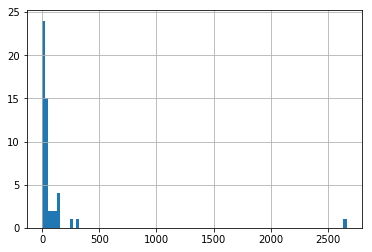

In [30]:
# lets plot is as well
points_df.pt.hist(bins=100)

In [31]:
# from the data we can find from the above statistics, anyting beyond first quartile looks a good number to be 
# in a particular category because distribution is very skewed.
# the first quartile value is 16 (rounded of)
# so we will consider those values to be a part of cluster, if there is more than 16 values are present for some
# percentage of categories out of total categories, 
# lets find that percentage first,

In [32]:
# from the above distribution we are making as assumption that, if 20 percent of total categories in a cluster
# having atleast 17 (first quartile value) data points presents in that cluster
# and the number of cluster should be less than 20, looking at the number of data points,

In [33]:
# so lets find which epsilon, and min points give maximum data points with opmimum number of clusters, 
# lets do the parameter tuning with dbscan

In [34]:
#lets make all the possible epsilons,

epsilon1=[] # all the possible epsilons from 0.5 to 29
p=0
for i in range(0,30):
    p=p+0.05
    epsilon1.append(p)

coords = df_filtered.as_matrix(columns=['lat', 'lon']) # lat and long values from the dataframe, converting it to matrix 
                                              # to calculate  the distance from each point
for i in range(1,50):  # all possible minimum points
    print('min points done '+str(i)) # printing the min point
    for j in epsilon1:
        kms_per_radian = 6371.0088
        epsilon = j / kms_per_radian  # j is the value to calculate epsilon comes from epsilon1 list
        db = DBSCAN(eps=epsilon, min_samples=i, algorithm='ball_tree', metric='haversine').fit(np.radians(coords)) # the algorithm
        cluster_labels = db.labels_
        num_clusters = len(set(cluster_labels)) # total number of cluster
        clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)]) # the clusters 
        clustered = pd.DataFrame({'lat': coords[:, 0], 'lon': coords[:, 1]}) # creating the data frame from the matrix
                                                                             # with lat and lon columns 
        # now I want to add the cluster no with each lat-long point, following code does that,
        clusters_no=[]
        lats_longs=[]
        for k in range(0,len(clustered)):
            for l in range(0,len(clusters)):
                if(clustered.values[k]) in clusters[l]:  # checking if the latlong value presents
                    # appending both lat-long and cluster no into the list, 
                    clusters_no.append(l)
                    lats_longs.append(clustered.values[k])
        # creating the dataframe with lat-lon value,
        df_target_points= pd.DataFrame({'lat': np.array(lats_longs)[:, 0], 'lon': np.array(lats_longs)[:, 1]})
        df_target_points['cluster_no']=clusters_no #assigning cluster no into it,
        
        # now we want to add the category as well with the lat-lon value,
        # a simple inner join will do the task
        df.lat=df.lat.astype(float)
        df.lon=df.lon.astype(float)
        df_target_points=df_target_points.merge(df,on=['lat','lon'])[['lat','lon','cluster_no','category']]
        #print(print('Number of clusters: {}'.format(num_clusters)))
        # now this dataframe will have all the columns we need,
        
        # now the prime task to check what parameters satisfies the conditions I have written above,
        for m in list(df_target_points.cluster_no.unique()):  # checking with every cluser values
            dfx=df_target_points[df_target_points.cluster_no==m]
            cats=list(Counter(dfx.category))  # the categories in a particular cluster
            #print(cats)
            #total_dps=len(list(Counter(df.category)))
            cat_nos=[]   # to store the values present in each category in a particular cluster
            for n in cats:
                cat_nos.append(Counter(dfx.category).get(n))
            if(len(cat_nos)>4):  # minimum category to be present is 5 because we need atleast 1 categoty having 16 plus records
                threshold=len(cat_nos)*0.2  # minimum categories to have 17 plus records, 
                #print(cat_nos)
                cat_nos=[o for o in cat_nos if int(o)>16]   # this will have only those values having >16 records,
                if((len(cat_nos)>=threshold)&(num_clusters<20)):  # This is our focus area, when all condition satisfies,
                    # printng the required value from each cluster, 
                    print('cluster no '+str(m)) 
                    print('min no of points: '+str(i))
                    print('epsilon '+str(j))
                    print(print('Number of clusters: {}'.format(num_clusters)))
                    print('categories with good numbers of points'+str(cat_nos))
                    print('all categories available'+str(Counter(dfx.category)))
        print("_________________________________________________________________________________") #seperator, from each epsilon, minpoint combination

/home/oto/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':


min points done 1
_________________________________________________________________________________
_________________________________________________________________________________
_________________________________________________________________________________
_________________________________________________________________________________
_________________________________________________________________________________
_________________________________________________________________________________
_________________________________________________________________________________
_________________________________________________________________________________
_________________________________________________________________________________
_________________________________________________________________________________
_________________________________________________________________________________
________________________________________________________________________________

cluster no 0
min no of points: 1
epsilon 1.4000000000000006
Number of clusters: 8
None
categories with good numbers of points[226, 310, 145, 75, 23, 122, 30, 108, 102, 40, 26, 35, 149, 27, 40, 80, 31, 25, 32, 43, 2661, 19, 134, 31, 44, 83, 35, 48, 138, 43, 24, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2661, 'restaurant': 310, 'railway_station': 226, 'housing': 149, 'place_of_worship': 145, 'bus_station': 138, 'bank': 134, 'parking': 122, 'monument': 108, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 80, 'road': 75, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 43, 'convenience': 42, 'local_shop': 41, 'fuel': 40, 'hospital': 40, 'police': 35, 'bakery': 35, 'cinema': 32, 'private_company': 31, 'leisure': 31, 'hotel': 30, 'salon': 30, 'bar': 27, 'marketplace': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hardw

cluster no 0
min no of points: 2
epsilon 0.7000000000000001
Number of clusters: 11
None
categories with good numbers of points[208, 310, 145, 75, 23, 122, 30, 103, 102, 40, 26, 35, 148, 27, 40, 80, 31, 25, 32, 43, 2659, 19, 134, 31, 44, 83, 35, 48, 137, 43, 24, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2659, 'restaurant': 310, 'railway_station': 208, 'housing': 148, 'place_of_worship': 145, 'bus_station': 137, 'bank': 134, 'parking': 122, 'monument': 103, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 80, 'road': 75, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 43, 'convenience': 42, 'local_shop': 41, 'fuel': 40, 'hospital': 40, 'police': 35, 'bakery': 35, 'cinema': 32, 'private_company': 31, 'leisure': 31, 'hotel': 30, 'salon': 30, 'bar': 27, 'marketplace': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hard

cluster no 0
min no of points: 2
epsilon 1.0500000000000003
Number of clusters: 11
None
categories with good numbers of points[211, 310, 145, 75, 23, 122, 30, 108, 102, 40, 26, 35, 149, 27, 40, 80, 31, 25, 32, 43, 2660, 19, 134, 31, 44, 83, 35, 48, 138, 43, 24, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2660, 'restaurant': 310, 'railway_station': 211, 'housing': 149, 'place_of_worship': 145, 'bus_station': 138, 'bank': 134, 'parking': 122, 'monument': 108, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 80, 'road': 75, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 43, 'convenience': 42, 'local_shop': 41, 'fuel': 40, 'hospital': 40, 'police': 35, 'bakery': 35, 'cinema': 32, 'private_company': 31, 'leisure': 31, 'hotel': 30, 'salon': 30, 'bar': 27, 'marketplace': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hard

cluster no 0
min no of points: 2
epsilon 1.4000000000000006
Number of clusters: 6
None
categories with good numbers of points[226, 310, 145, 75, 23, 122, 30, 108, 102, 40, 26, 35, 149, 27, 40, 80, 31, 25, 32, 43, 2661, 19, 134, 31, 44, 83, 35, 48, 138, 43, 24, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2661, 'restaurant': 310, 'railway_station': 226, 'housing': 149, 'place_of_worship': 145, 'bus_station': 138, 'bank': 134, 'parking': 122, 'monument': 108, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 80, 'road': 75, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 43, 'convenience': 42, 'local_shop': 41, 'fuel': 40, 'hospital': 40, 'police': 35, 'bakery': 35, 'cinema': 32, 'private_company': 31, 'leisure': 31, 'hotel': 30, 'salon': 30, 'bar': 27, 'marketplace': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hardw

cluster no 0
min no of points: 3
epsilon 0.6
Number of clusters: 8
None
categories with good numbers of points[68, 88, 25, 74, 34, 28, 107, 68, 86, 60, 17, 128, 27, 43, 19, 91, 20, 23, 20, 22, 31, 18]
all categories availableCounter({'restaurant': 128, 'parking': 107, 'bus_station': 91, 'housing': 88, 'tree': 86, 'bus_stop': 74, 'railway_station': 68, 'place_of_worship': 68, 'bank': 60, 'cafe': 43, 'monument': 34, 'road': 31, 'educational_institution': 28, 'pharmacy': 27, 'hospital': 25, 'convenience': 23, 'salon': 22, 'atm': 20, 'boutique': 20, 'toilets': 19, 'sabal_project': 18, 'leisure': 17, 'bakery': 14, 'private_company': 14, 'clinic': 14, 'vehicle': 13, 'cinema': 12, 'fuel': 11, 'police': 11, 'local_shop': 10, 'bar': 10, 'supermarket': 10, 'accessories': 9, 'hardware_shop': 8, 'wine_shop': 8, 'electronics': 8, 'hotel': 6, 'butcher': 6, 'travel_agency': 6, 'community_centre': 5, 'pub': 5, 'marketplace': 5, 'laundry': 5, 'hostel': 5, 'government_office': 4, 'books': 2, 'gift_shop'

cluster no 0
min no of points: 3
epsilon 0.9000000000000002
Number of clusters: 4
None
categories with good numbers of points[211, 310, 145, 75, 23, 122, 30, 108, 102, 40, 26, 35, 149, 27, 40, 80, 31, 25, 32, 43, 2659, 19, 134, 31, 44, 83, 35, 48, 138, 43, 24, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2659, 'restaurant': 310, 'railway_station': 211, 'housing': 149, 'place_of_worship': 145, 'bus_station': 138, 'bank': 134, 'parking': 122, 'monument': 108, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 80, 'road': 75, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 43, 'convenience': 42, 'local_shop': 41, 'fuel': 40, 'hospital': 40, 'police': 35, 'bakery': 35, 'cinema': 32, 'private_company': 31, 'leisure': 31, 'hotel': 30, 'salon': 30, 'bar': 27, 'marketplace': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hardw

cluster no 0
min no of points: 3
epsilon 1.2500000000000004
Number of clusters: 7
None
categories with good numbers of points[215, 310, 145, 75, 23, 122, 30, 108, 102, 40, 26, 35, 149, 27, 40, 80, 31, 25, 32, 43, 2660, 19, 134, 31, 44, 83, 35, 48, 138, 43, 24, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2660, 'restaurant': 310, 'railway_station': 215, 'housing': 149, 'place_of_worship': 145, 'bus_station': 138, 'bank': 134, 'parking': 122, 'monument': 108, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 80, 'road': 75, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 43, 'convenience': 42, 'local_shop': 41, 'fuel': 40, 'hospital': 40, 'police': 35, 'bakery': 35, 'cinema': 32, 'private_company': 31, 'leisure': 31, 'hotel': 30, 'salon': 30, 'bar': 27, 'marketplace': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hardw

_________________________________________________________________________________
_________________________________________________________________________________
_________________________________________________________________________________
cluster no 0
min no of points: 4
epsilon 0.49999999999999994
Number of clusters: 16
None
categories with good numbers of points[56, 84, 23, 72, 24, 22, 61, 41, 58, 117, 27, 36, 84, 18, 23, 20, 21, 20, 18]
all categories availableCounter({'restaurant': 117, 'housing': 84, 'bus_station': 84, 'bus_stop': 72, 'place_of_worship': 61, 'bank': 58, 'railway_station': 56, 'tree': 41, 'cafe': 36, 'pharmacy': 27, 'monument': 24, 'hospital': 23, 'convenience': 23, 'educational_institution': 22, 'salon': 21, 'boutique': 20, 'road': 20, 'atm': 18, 'sabal_project': 18, 'leisure': 15, 'bakery': 14, 'clinic': 14, 'vehicle': 13, 'private_company': 13, 'cinema': 11, 'fuel': 10, 'police': 10, 'toilets': 9, 'bar': 9, 'accessories': 9, 'hardware_shop': 8, 'supermark

cluster no 0
min no of points: 4
epsilon 0.7000000000000001
Number of clusters: 5
None
categories with good numbers of points[208, 310, 145, 75, 23, 122, 30, 103, 102, 40, 26, 35, 148, 27, 40, 80, 31, 25, 32, 43, 2659, 19, 134, 31, 44, 83, 35, 48, 137, 43, 24, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2659, 'restaurant': 310, 'railway_station': 208, 'housing': 148, 'place_of_worship': 145, 'bus_station': 137, 'bank': 134, 'parking': 122, 'monument': 103, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 80, 'road': 75, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 43, 'convenience': 42, 'local_shop': 41, 'fuel': 40, 'hospital': 40, 'police': 35, 'bakery': 35, 'cinema': 32, 'private_company': 31, 'leisure': 31, 'hotel': 30, 'salon': 30, 'bar': 27, 'marketplace': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hardw

cluster no 0
min no of points: 4
epsilon 1.0500000000000003
Number of clusters: 4
None
categories with good numbers of points[211, 310, 145, 75, 23, 122, 30, 108, 102, 40, 26, 35, 149, 27, 40, 80, 31, 25, 32, 43, 2660, 19, 134, 31, 44, 83, 35, 48, 138, 43, 24, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2660, 'restaurant': 310, 'railway_station': 211, 'housing': 149, 'place_of_worship': 145, 'bus_station': 138, 'bank': 134, 'parking': 122, 'monument': 108, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 80, 'road': 75, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 43, 'convenience': 42, 'local_shop': 41, 'fuel': 40, 'hospital': 40, 'police': 35, 'bakery': 35, 'cinema': 32, 'private_company': 31, 'leisure': 31, 'hotel': 30, 'salon': 30, 'bar': 27, 'marketplace': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hardw

cluster no 0
min no of points: 4
epsilon 1.4000000000000006
Number of clusters: 3
None
categories with good numbers of points[219, 310, 145, 75, 23, 122, 30, 108, 102, 40, 26, 35, 149, 27, 40, 80, 31, 25, 32, 43, 2661, 19, 134, 31, 44, 83, 35, 48, 138, 43, 24, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2661, 'restaurant': 310, 'railway_station': 219, 'housing': 149, 'place_of_worship': 145, 'bus_station': 138, 'bank': 134, 'parking': 122, 'monument': 108, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 80, 'road': 75, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 43, 'convenience': 42, 'local_shop': 41, 'fuel': 40, 'hospital': 40, 'police': 35, 'bakery': 35, 'cinema': 32, 'private_company': 31, 'leisure': 31, 'hotel': 30, 'salon': 30, 'bar': 27, 'marketplace': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hardw

cluster no 0
min no of points: 5
epsilon 0.6
Number of clusters: 8
None
categories with good numbers of points[68, 88, 25, 74, 34, 28, 107, 68, 86, 60, 17, 128, 27, 43, 19, 91, 20, 23, 20, 22, 31, 18]
all categories availableCounter({'restaurant': 128, 'parking': 107, 'bus_station': 91, 'housing': 88, 'tree': 86, 'bus_stop': 74, 'railway_station': 68, 'place_of_worship': 68, 'bank': 60, 'cafe': 43, 'monument': 34, 'road': 31, 'educational_institution': 28, 'pharmacy': 27, 'hospital': 25, 'convenience': 23, 'salon': 22, 'atm': 20, 'boutique': 20, 'toilets': 19, 'sabal_project': 18, 'leisure': 17, 'bakery': 14, 'private_company': 14, 'clinic': 14, 'vehicle': 13, 'cinema': 12, 'fuel': 11, 'police': 11, 'local_shop': 10, 'bar': 10, 'supermarket': 10, 'accessories': 9, 'hardware_shop': 8, 'wine_shop': 8, 'electronics': 8, 'hotel': 6, 'butcher': 6, 'travel_agency': 6, 'community_centre': 5, 'pub': 5, 'marketplace': 5, 'laundry': 5, 'hostel': 5, 'government_office': 4, 'books': 2, 'gift_shop'

cluster no 0
min no of points: 5
epsilon 0.9000000000000002
Number of clusters: 3
None
categories with good numbers of points[211, 310, 145, 75, 23, 122, 30, 108, 102, 40, 26, 35, 149, 27, 40, 80, 31, 25, 32, 43, 2659, 19, 134, 31, 44, 83, 35, 48, 138, 43, 24, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2659, 'restaurant': 310, 'railway_station': 211, 'housing': 149, 'place_of_worship': 145, 'bus_station': 138, 'bank': 134, 'parking': 122, 'monument': 108, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 80, 'road': 75, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 43, 'convenience': 42, 'local_shop': 41, 'fuel': 40, 'hospital': 40, 'police': 35, 'bakery': 35, 'cinema': 32, 'private_company': 31, 'leisure': 31, 'hotel': 30, 'salon': 30, 'bar': 27, 'marketplace': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hardw

cluster no 0
min no of points: 5
epsilon 1.2500000000000004
Number of clusters: 3
None
categories with good numbers of points[214, 310, 145, 75, 23, 122, 30, 108, 102, 40, 26, 35, 149, 27, 40, 80, 31, 25, 32, 43, 2660, 19, 134, 31, 44, 83, 35, 48, 138, 43, 24, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2660, 'restaurant': 310, 'railway_station': 214, 'housing': 149, 'place_of_worship': 145, 'bus_station': 138, 'bank': 134, 'parking': 122, 'monument': 108, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 80, 'road': 75, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 43, 'convenience': 42, 'local_shop': 41, 'fuel': 40, 'hospital': 40, 'police': 35, 'bakery': 35, 'cinema': 32, 'private_company': 31, 'leisure': 31, 'hotel': 30, 'salon': 30, 'bar': 27, 'marketplace': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hardw

_________________________________________________________________________________
_________________________________________________________________________________
cluster no 0
min no of points: 6
epsilon 0.44999999999999996
Number of clusters: 19
None
categories with good numbers of points[46, 79, 21, 72, 22, 20, 55, 41, 57, 115, 26, 36, 81, 18, 23, 20, 21, 17]
all categories availableCounter({'restaurant': 115, 'bus_station': 81, 'housing': 79, 'bus_stop': 72, 'bank': 57, 'place_of_worship': 55, 'railway_station': 46, 'tree': 41, 'cafe': 36, 'pharmacy': 26, 'convenience': 23, 'monument': 22, 'hospital': 21, 'salon': 21, 'educational_institution': 20, 'boutique': 20, 'atm': 18, 'road': 17, 'leisure': 15, 'bakery': 14, 'clinic': 14, 'vehicle': 13, 'private_company': 13, 'sabal_project': 12, 'cinema': 10, 'police': 10, 'fuel': 9, 'toilets': 9, 'bar': 9, 'accessories': 9, 'hardware_shop': 8, 'supermarket': 8, 'local_shop': 7, 'wine_shop': 7, 'electronics': 7, 'community_centre': 5, 'pub'

cluster no 0
min no of points: 6
epsilon 0.65
Number of clusters: 3
None
categories with good numbers of points[203, 310, 145, 75, 23, 122, 30, 102, 102, 38, 26, 35, 148, 27, 40, 77, 30, 25, 32, 43, 2659, 19, 134, 31, 44, 83, 35, 48, 136, 43, 24, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2659, 'restaurant': 310, 'railway_station': 203, 'housing': 148, 'place_of_worship': 145, 'bus_station': 136, 'bank': 134, 'parking': 122, 'monument': 102, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 77, 'road': 75, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 43, 'convenience': 42, 'local_shop': 41, 'hospital': 40, 'fuel': 38, 'police': 35, 'bakery': 35, 'cinema': 32, 'leisure': 31, 'hotel': 30, 'private_company': 30, 'salon': 30, 'bar': 27, 'marketplace': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hardware_shop': 15,

cluster no 0
min no of points: 6
epsilon 1.0000000000000002
Number of clusters: 3
None
categories with good numbers of points[211, 310, 145, 75, 23, 122, 30, 108, 102, 40, 26, 35, 149, 27, 40, 80, 31, 25, 32, 43, 2659, 19, 134, 31, 44, 83, 35, 48, 138, 43, 24, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2659, 'restaurant': 310, 'railway_station': 211, 'housing': 149, 'place_of_worship': 145, 'bus_station': 138, 'bank': 134, 'parking': 122, 'monument': 108, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 80, 'road': 75, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 43, 'convenience': 42, 'local_shop': 41, 'fuel': 40, 'hospital': 40, 'police': 35, 'bakery': 35, 'cinema': 32, 'private_company': 31, 'leisure': 31, 'hotel': 30, 'salon': 30, 'bar': 27, 'marketplace': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hardw

cluster no 0
min no of points: 6
epsilon 1.3500000000000005
Number of clusters: 3
None
categories with good numbers of points[219, 310, 145, 75, 23, 122, 30, 108, 102, 40, 26, 35, 149, 27, 40, 80, 31, 25, 32, 43, 2661, 19, 134, 31, 44, 83, 35, 48, 138, 43, 24, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2661, 'restaurant': 310, 'railway_station': 219, 'housing': 149, 'place_of_worship': 145, 'bus_station': 138, 'bank': 134, 'parking': 122, 'monument': 108, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 80, 'road': 75, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 43, 'convenience': 42, 'local_shop': 41, 'fuel': 40, 'hospital': 40, 'police': 35, 'bakery': 35, 'cinema': 32, 'private_company': 31, 'leisure': 31, 'hotel': 30, 'salon': 30, 'bar': 27, 'marketplace': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hardw

cluster no 0
min no of points: 7
epsilon 0.5499999999999999
Number of clusters: 10
None
categories with good numbers of points[56, 84, 24, 72, 25, 23, 59, 41, 58, 115, 26, 36, 84, 18, 23, 20, 21, 21, 18]
all categories availableCounter({'restaurant': 115, 'housing': 84, 'bus_station': 84, 'bus_stop': 72, 'place_of_worship': 59, 'bank': 58, 'railway_station': 56, 'tree': 41, 'cafe': 36, 'pharmacy': 26, 'monument': 25, 'hospital': 24, 'educational_institution': 23, 'convenience': 23, 'salon': 21, 'road': 21, 'boutique': 20, 'atm': 18, 'sabal_project': 18, 'leisure': 15, 'bakery': 14, 'clinic': 14, 'vehicle': 13, 'private_company': 13, 'cinema': 11, 'fuel': 10, 'police': 10, 'toilets': 9, 'bar': 9, 'accessories': 9, 'hardware_shop': 8, 'supermarket': 8, 'local_shop': 7, 'wine_shop': 7, 'electronics': 7, 'travel_agency': 6, 'community_centre': 5, 'pub': 5, 'hotel': 5, 'laundry': 5, 'butcher': 5, 'marketplace': 4, 'government_office': 4, 'parking': 3, 'books': 2, 'gift_shop': 2, 'hostel': 2

cluster no 0
min no of points: 7
epsilon 0.8000000000000002
Number of clusters: 3
None
categories with good numbers of points[210, 310, 145, 75, 23, 122, 30, 108, 102, 40, 26, 35, 148, 27, 40, 80, 31, 25, 32, 43, 2659, 19, 134, 31, 44, 83, 35, 48, 137, 43, 24, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2659, 'restaurant': 310, 'railway_station': 210, 'housing': 148, 'place_of_worship': 145, 'bus_station': 137, 'bank': 134, 'parking': 122, 'monument': 108, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 80, 'road': 75, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 43, 'convenience': 42, 'local_shop': 41, 'fuel': 40, 'hospital': 40, 'police': 35, 'bakery': 35, 'cinema': 32, 'private_company': 31, 'leisure': 31, 'hotel': 30, 'salon': 30, 'bar': 27, 'marketplace': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hardw

cluster no 0
min no of points: 7
epsilon 1.1500000000000004
Number of clusters: 3
None
categories with good numbers of points[211, 310, 145, 75, 23, 122, 30, 108, 102, 40, 26, 35, 149, 27, 40, 80, 31, 25, 32, 43, 2660, 19, 134, 31, 44, 83, 35, 48, 138, 43, 24, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2660, 'restaurant': 310, 'railway_station': 211, 'housing': 149, 'place_of_worship': 145, 'bus_station': 138, 'bank': 134, 'parking': 122, 'monument': 108, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 80, 'road': 75, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 43, 'convenience': 42, 'local_shop': 41, 'fuel': 40, 'hospital': 40, 'police': 35, 'bakery': 35, 'cinema': 32, 'private_company': 31, 'leisure': 31, 'hotel': 30, 'salon': 30, 'bar': 27, 'marketplace': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hardw

cluster no 0
min no of points: 7
epsilon 1.5000000000000007
Number of clusters: 3
None
categories with good numbers of points[215, 310, 145, 75, 23, 122, 30, 108, 102, 40, 26, 35, 149, 27, 40, 80, 31, 25, 32, 43, 2661, 19, 134, 31, 44, 83, 35, 48, 138, 43, 24, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2661, 'restaurant': 310, 'railway_station': 215, 'housing': 149, 'place_of_worship': 145, 'bus_station': 138, 'bank': 134, 'parking': 122, 'monument': 108, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 80, 'road': 75, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 43, 'convenience': 42, 'local_shop': 41, 'fuel': 40, 'hospital': 40, 'police': 35, 'bakery': 35, 'cinema': 32, 'private_company': 31, 'leisure': 31, 'hotel': 30, 'salon': 30, 'bar': 27, 'marketplace': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hardw

cluster no 0
min no of points: 8
epsilon 0.6
Number of clusters: 5
None
categories with good numbers of points[62, 87, 25, 74, 34, 27, 107, 67, 86, 60, 17, 128, 27, 43, 19, 89, 20, 23, 20, 22, 30, 18]
all categories availableCounter({'restaurant': 128, 'parking': 107, 'bus_station': 89, 'housing': 87, 'tree': 86, 'bus_stop': 74, 'place_of_worship': 67, 'railway_station': 62, 'bank': 60, 'cafe': 43, 'monument': 34, 'road': 30, 'educational_institution': 27, 'pharmacy': 27, 'hospital': 25, 'convenience': 23, 'salon': 22, 'atm': 20, 'boutique': 20, 'toilets': 19, 'sabal_project': 18, 'leisure': 17, 'bakery': 14, 'private_company': 14, 'clinic': 14, 'vehicle': 13, 'cinema': 12, 'fuel': 11, 'police': 11, 'local_shop': 10, 'bar': 10, 'supermarket': 10, 'accessories': 9, 'hardware_shop': 8, 'wine_shop': 8, 'electronics': 8, 'hotel': 6, 'butcher': 6, 'travel_agency': 6, 'community_centre': 5, 'pub': 5, 'marketplace': 5, 'laundry': 5, 'hostel': 5, 'government_office': 4, 'books': 2, 'gift_shop'

cluster no 0
min no of points: 8
epsilon 0.9000000000000002
Number of clusters: 3
None
categories with good numbers of points[211, 310, 145, 75, 23, 122, 30, 108, 102, 40, 26, 35, 148, 27, 40, 80, 31, 25, 32, 43, 2659, 19, 134, 31, 44, 83, 35, 48, 138, 43, 24, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2659, 'restaurant': 310, 'railway_station': 211, 'housing': 148, 'place_of_worship': 145, 'bus_station': 138, 'bank': 134, 'parking': 122, 'monument': 108, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 80, 'road': 75, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 43, 'convenience': 42, 'local_shop': 41, 'fuel': 40, 'hospital': 40, 'police': 35, 'bakery': 35, 'cinema': 32, 'private_company': 31, 'leisure': 31, 'hotel': 30, 'salon': 30, 'bar': 27, 'marketplace': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hardw

cluster no 0
min no of points: 8
epsilon 1.2500000000000004
Number of clusters: 3
None
categories with good numbers of points[214, 310, 145, 75, 23, 122, 30, 108, 102, 40, 26, 35, 149, 27, 40, 80, 31, 25, 32, 43, 2660, 19, 134, 31, 44, 83, 35, 48, 138, 43, 24, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2660, 'restaurant': 310, 'railway_station': 214, 'housing': 149, 'place_of_worship': 145, 'bus_station': 138, 'bank': 134, 'parking': 122, 'monument': 108, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 80, 'road': 75, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 43, 'convenience': 42, 'local_shop': 41, 'fuel': 40, 'hospital': 40, 'police': 35, 'bakery': 35, 'cinema': 32, 'private_company': 31, 'leisure': 31, 'hotel': 30, 'salon': 30, 'bar': 27, 'marketplace': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hardw

_________________________________________________________________________________
_________________________________________________________________________________
cluster no 0
min no of points: 9
epsilon 0.44999999999999996
Number of clusters: 14
None
categories with good numbers of points[44, 79, 21, 72, 22, 20, 54, 41, 57, 114, 26, 36, 78, 18, 23, 20, 21, 17]
all categories availableCounter({'restaurant': 114, 'housing': 79, 'bus_station': 78, 'bus_stop': 72, 'bank': 57, 'place_of_worship': 54, 'railway_station': 44, 'tree': 41, 'cafe': 36, 'pharmacy': 26, 'convenience': 23, 'monument': 22, 'hospital': 21, 'salon': 21, 'educational_institution': 20, 'boutique': 20, 'atm': 18, 'road': 17, 'leisure': 15, 'bakery': 14, 'clinic': 14, 'vehicle': 13, 'private_company': 13, 'cinema': 10, 'police': 10, 'sabal_project': 10, 'fuel': 9, 'bar': 9, 'accessories': 9, 'toilets': 8, 'hardware_shop': 8, 'supermarket': 8, 'local_shop': 7, 'wine_shop': 7, 'electronics': 7, 'community_centre': 5, 'pub'

cluster no 0
min no of points: 9
epsilon 0.65
Number of clusters: 3
None
categories with good numbers of points[192, 310, 143, 74, 23, 122, 30, 101, 102, 26, 37, 35, 146, 27, 40, 76, 30, 25, 32, 43, 2659, 19, 132, 31, 44, 83, 35, 48, 134, 42, 24, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2659, 'restaurant': 310, 'railway_station': 192, 'housing': 146, 'place_of_worship': 143, 'bus_station': 134, 'bank': 132, 'parking': 122, 'bus_stop': 102, 'monument': 101, 'cafe': 83, 'educational_institution': 76, 'road': 74, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 42, 'convenience': 42, 'local_shop': 41, 'hospital': 40, 'fuel': 37, 'police': 35, 'bakery': 35, 'cinema': 32, 'leisure': 31, 'hotel': 30, 'private_company': 30, 'salon': 30, 'bar': 27, 'marketplace': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hardware_shop': 15,

cluster no 0
min no of points: 9
epsilon 1.0000000000000002
Number of clusters: 3
None
categories with good numbers of points[211, 310, 145, 75, 23, 122, 30, 108, 102, 40, 26, 35, 149, 27, 40, 80, 31, 25, 32, 43, 2659, 19, 134, 31, 44, 83, 35, 48, 138, 43, 24, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2659, 'restaurant': 310, 'railway_station': 211, 'housing': 149, 'place_of_worship': 145, 'bus_station': 138, 'bank': 134, 'parking': 122, 'monument': 108, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 80, 'road': 75, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 43, 'convenience': 42, 'local_shop': 41, 'fuel': 40, 'hospital': 40, 'police': 35, 'bakery': 35, 'cinema': 32, 'private_company': 31, 'leisure': 31, 'hotel': 30, 'salon': 30, 'bar': 27, 'marketplace': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hardw

cluster no 0
min no of points: 9
epsilon 1.3500000000000005
Number of clusters: 3
None
categories with good numbers of points[214, 310, 145, 75, 23, 122, 30, 108, 102, 40, 26, 35, 149, 27, 40, 80, 31, 25, 32, 43, 2661, 19, 134, 31, 44, 83, 35, 48, 138, 43, 24, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2661, 'restaurant': 310, 'railway_station': 214, 'housing': 149, 'place_of_worship': 145, 'bus_station': 138, 'bank': 134, 'parking': 122, 'monument': 108, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 80, 'road': 75, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 43, 'convenience': 42, 'local_shop': 41, 'fuel': 40, 'hospital': 40, 'police': 35, 'bakery': 35, 'cinema': 32, 'private_company': 31, 'leisure': 31, 'hotel': 30, 'salon': 30, 'bar': 27, 'marketplace': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hardw

cluster no 0
min no of points: 10
epsilon 0.5499999999999999
Number of clusters: 8
None
categories with good numbers of points[50, 82, 24, 72, 25, 23, 56, 41, 58, 115, 26, 36, 81, 18, 23, 20, 21, 19, 18]
all categories availableCounter({'restaurant': 115, 'housing': 82, 'bus_station': 81, 'bus_stop': 72, 'bank': 58, 'place_of_worship': 56, 'railway_station': 50, 'tree': 41, 'cafe': 36, 'pharmacy': 26, 'monument': 25, 'hospital': 24, 'educational_institution': 23, 'convenience': 23, 'salon': 21, 'boutique': 20, 'road': 19, 'atm': 18, 'sabal_project': 18, 'leisure': 15, 'bakery': 14, 'clinic': 14, 'vehicle': 13, 'private_company': 13, 'fuel': 10, 'cinema': 10, 'police': 10, 'toilets': 9, 'bar': 9, 'accessories': 9, 'hardware_shop': 8, 'supermarket': 8, 'local_shop': 7, 'wine_shop': 7, 'electronics': 7, 'travel_agency': 6, 'community_centre': 5, 'pub': 5, 'hotel': 5, 'laundry': 5, 'butcher': 5, 'marketplace': 4, 'government_office': 4, 'parking': 3, 'books': 2, 'gift_shop': 2, 'hostel': 2

cluster no 0
min no of points: 10
epsilon 0.8000000000000002
Number of clusters: 3
None
categories with good numbers of points[207, 310, 145, 75, 23, 122, 30, 104, 102, 39, 26, 35, 148, 27, 40, 80, 31, 25, 32, 43, 2659, 19, 134, 31, 44, 83, 35, 48, 137, 43, 24, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2659, 'restaurant': 310, 'railway_station': 207, 'housing': 148, 'place_of_worship': 145, 'bus_station': 137, 'bank': 134, 'parking': 122, 'monument': 104, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 80, 'road': 75, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 43, 'convenience': 42, 'local_shop': 41, 'hospital': 40, 'fuel': 39, 'police': 35, 'bakery': 35, 'cinema': 32, 'private_company': 31, 'leisure': 31, 'hotel': 30, 'salon': 30, 'bar': 27, 'marketplace': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hard

cluster no 0
min no of points: 10
epsilon 1.1500000000000004
Number of clusters: 3
None
categories with good numbers of points[211, 310, 145, 75, 23, 122, 30, 108, 102, 40, 26, 35, 149, 27, 40, 80, 31, 25, 32, 43, 2660, 19, 134, 31, 44, 83, 35, 48, 138, 43, 24, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2660, 'restaurant': 310, 'railway_station': 211, 'housing': 149, 'place_of_worship': 145, 'bus_station': 138, 'bank': 134, 'parking': 122, 'monument': 108, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 80, 'road': 75, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 43, 'convenience': 42, 'local_shop': 41, 'fuel': 40, 'hospital': 40, 'police': 35, 'bakery': 35, 'cinema': 32, 'private_company': 31, 'leisure': 31, 'hotel': 30, 'salon': 30, 'bar': 27, 'marketplace': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hard

cluster no 0
min no of points: 10
epsilon 1.5000000000000007
Number of clusters: 3
None
categories with good numbers of points[215, 310, 145, 75, 23, 122, 30, 108, 102, 40, 26, 35, 149, 27, 40, 80, 31, 25, 32, 43, 2661, 19, 134, 31, 44, 83, 35, 48, 138, 43, 24, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2661, 'restaurant': 310, 'railway_station': 215, 'housing': 149, 'place_of_worship': 145, 'bus_station': 138, 'bank': 134, 'parking': 122, 'monument': 108, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 80, 'road': 75, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 43, 'convenience': 42, 'local_shop': 41, 'fuel': 40, 'hospital': 40, 'police': 35, 'bakery': 35, 'cinema': 32, 'private_company': 31, 'leisure': 31, 'hotel': 30, 'salon': 30, 'bar': 27, 'marketplace': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hard

cluster no 0
min no of points: 11
epsilon 0.6
Number of clusters: 4
None
categories with good numbers of points[55, 84, 24, 73, 29, 23, 57, 86, 58, 117, 27, 38, 82, 19, 23, 20, 21, 20, 18]
all categories availableCounter({'restaurant': 117, 'tree': 86, 'housing': 84, 'bus_station': 82, 'bus_stop': 73, 'bank': 58, 'place_of_worship': 57, 'railway_station': 55, 'cafe': 38, 'monument': 29, 'pharmacy': 27, 'hospital': 24, 'educational_institution': 23, 'convenience': 23, 'salon': 21, 'boutique': 20, 'road': 20, 'atm': 19, 'sabal_project': 18, 'leisure': 15, 'bakery': 14, 'private_company': 14, 'clinic': 14, 'vehicle': 13, 'fuel': 11, 'cinema': 11, 'police': 11, 'toilets': 9, 'bar': 9, 'accessories': 9, 'hardware_shop': 8, 'supermarket': 8, 'electronics': 8, 'local_shop': 7, 'wine_shop': 7, 'hotel': 6, 'travel_agency': 6, 'parking': 5, 'community_centre': 5, 'pub': 5, 'laundry': 5, 'butcher': 5, 'marketplace': 4, 'government_office': 4, 'books': 2, 'gift_shop': 2, 'hostel': 2, 'post_office'

cluster no 0
min no of points: 11
epsilon 0.8500000000000002
Number of clusters: 2
None
categories with good numbers of points[207, 310, 145, 75, 23, 122, 30, 104, 102, 39, 26, 35, 148, 27, 40, 80, 31, 25, 32, 43, 2659, 19, 134, 31, 44, 83, 35, 48, 138, 43, 24, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2659, 'restaurant': 310, 'railway_station': 207, 'housing': 148, 'place_of_worship': 145, 'bus_station': 138, 'bank': 134, 'parking': 122, 'monument': 104, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 80, 'road': 75, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 43, 'convenience': 42, 'local_shop': 41, 'hospital': 40, 'fuel': 39, 'police': 35, 'bakery': 35, 'cinema': 32, 'private_company': 31, 'leisure': 31, 'hotel': 30, 'salon': 30, 'bar': 27, 'marketplace': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hard

cluster no 0
min no of points: 11
epsilon 1.2000000000000004
Number of clusters: 2
None
categories with good numbers of points[214, 310, 145, 75, 23, 122, 30, 108, 102, 40, 26, 35, 149, 27, 40, 80, 31, 25, 32, 43, 2660, 19, 134, 31, 44, 83, 35, 48, 138, 43, 24, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2660, 'restaurant': 310, 'railway_station': 214, 'housing': 149, 'place_of_worship': 145, 'bus_station': 138, 'bank': 134, 'parking': 122, 'monument': 108, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 80, 'road': 75, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 43, 'convenience': 42, 'local_shop': 41, 'fuel': 40, 'hospital': 40, 'police': 35, 'bakery': 35, 'cinema': 32, 'private_company': 31, 'leisure': 31, 'hotel': 30, 'salon': 30, 'bar': 27, 'marketplace': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hard

_________________________________________________________________________________
_________________________________________________________________________________
_________________________________________________________________________________
_________________________________________________________________________________
_________________________________________________________________________________
_________________________________________________________________________________
_________________________________________________________________________________
_________________________________________________________________________________
cluster no 0
min no of points: 12
epsilon 0.44999999999999996
Number of clusters: 15
None
categories with good numbers of points[22, 69, 26, 40, 43, 96, 21, 34, 60, 48, 23, 19, 21]
all categories availableCounter({'restaurant': 96, 'bus_stop': 69, 'housing': 60, 'bus_station': 48, 'bank': 43, 'tree': 40, 'cafe': 34, 'place_of_worship': 26, 'c

cluster no 0
min no of points: 12
epsilon 0.65
Number of clusters: 3
None
categories with good numbers of points[63, 88, 25, 74, 34, 27, 107, 67, 86, 60, 17, 128, 27, 43, 19, 89, 20, 23, 20, 22, 30, 18]
all categories availableCounter({'restaurant': 128, 'parking': 107, 'bus_station': 89, 'housing': 88, 'tree': 86, 'bus_stop': 74, 'place_of_worship': 67, 'railway_station': 63, 'bank': 60, 'cafe': 43, 'monument': 34, 'road': 30, 'educational_institution': 27, 'pharmacy': 27, 'hospital': 25, 'convenience': 23, 'salon': 22, 'atm': 20, 'boutique': 20, 'toilets': 19, 'sabal_project': 18, 'leisure': 17, 'bakery': 14, 'private_company': 14, 'clinic': 14, 'vehicle': 13, 'cinema': 12, 'fuel': 11, 'police': 11, 'local_shop': 10, 'bar': 10, 'supermarket': 10, 'accessories': 9, 'hardware_shop': 8, 'wine_shop': 8, 'electronics': 8, 'hotel': 6, 'butcher': 6, 'travel_agency': 6, 'community_centre': 5, 'pub': 5, 'marketplace': 5, 'laundry': 5, 'hostel': 5, 'government_office': 4, 'books': 2, 'gift_sho

cluster no 0
min no of points: 12
epsilon 0.9500000000000003
Number of clusters: 2
None
categories with good numbers of points[211, 310, 145, 75, 23, 122, 30, 104, 102, 40, 26, 35, 148, 27, 40, 80, 31, 25, 32, 43, 2659, 19, 134, 31, 44, 83, 35, 48, 138, 43, 24, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2659, 'restaurant': 310, 'railway_station': 211, 'housing': 148, 'place_of_worship': 145, 'bus_station': 138, 'bank': 134, 'parking': 122, 'monument': 104, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 80, 'road': 75, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 43, 'convenience': 42, 'local_shop': 41, 'fuel': 40, 'hospital': 40, 'police': 35, 'bakery': 35, 'cinema': 32, 'private_company': 31, 'leisure': 31, 'hotel': 30, 'salon': 30, 'bar': 27, 'marketplace': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hard

cluster no 0
min no of points: 12
epsilon 1.3000000000000005
Number of clusters: 2
None
categories with good numbers of points[214, 310, 145, 75, 23, 122, 30, 108, 102, 40, 26, 35, 149, 27, 40, 80, 31, 25, 32, 43, 2661, 19, 134, 31, 44, 83, 35, 48, 138, 43, 24, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2661, 'restaurant': 310, 'railway_station': 214, 'housing': 149, 'place_of_worship': 145, 'bus_station': 138, 'bank': 134, 'parking': 122, 'monument': 108, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 80, 'road': 75, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 43, 'convenience': 42, 'local_shop': 41, 'fuel': 40, 'hospital': 40, 'police': 35, 'bakery': 35, 'cinema': 32, 'private_company': 31, 'leisure': 31, 'hotel': 30, 'salon': 30, 'bar': 27, 'marketplace': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hard

cluster no 0
min no of points: 13
epsilon 0.49999999999999994
Number of clusters: 10
None
categories with good numbers of points[45, 79, 21, 71, 22, 20, 55, 41, 57, 114, 26, 36, 80, 18, 23, 20, 21, 17]
all categories availableCounter({'restaurant': 114, 'bus_station': 80, 'housing': 79, 'bus_stop': 71, 'bank': 57, 'place_of_worship': 55, 'railway_station': 45, 'tree': 41, 'cafe': 36, 'pharmacy': 26, 'convenience': 23, 'monument': 22, 'hospital': 21, 'salon': 21, 'educational_institution': 20, 'boutique': 20, 'atm': 18, 'road': 17, 'leisure': 15, 'bakery': 14, 'clinic': 14, 'vehicle': 13, 'private_company': 13, 'cinema': 10, 'police': 10, 'sabal_project': 10, 'fuel': 9, 'bar': 9, 'accessories': 9, 'toilets': 8, 'hardware_shop': 8, 'supermarket': 8, 'local_shop': 7, 'wine_shop': 7, 'electronics': 7, 'community_centre': 5, 'pub': 5, 'hotel': 5, 'laundry': 5, 'butcher': 5, 'travel_agency': 5, 'marketplace': 4, 'government_office': 4, 'parking': 3, 'books': 2, 'gift_shop': 2, 'hostel': 2, '

cluster no 0
min no of points: 13
epsilon 0.7000000000000001
Number of clusters: 2
None
categories with good numbers of points[191, 310, 144, 73, 23, 122, 30, 102, 102, 26, 37, 35, 147, 27, 40, 77, 30, 25, 32, 43, 2659, 19, 132, 31, 44, 83, 35, 48, 134, 42, 24, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2659, 'restaurant': 310, 'railway_station': 191, 'housing': 147, 'place_of_worship': 144, 'bus_station': 134, 'bank': 132, 'parking': 122, 'monument': 102, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 77, 'road': 73, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 42, 'convenience': 42, 'local_shop': 41, 'hospital': 40, 'fuel': 37, 'police': 35, 'bakery': 35, 'cinema': 32, 'leisure': 31, 'hotel': 30, 'private_company': 30, 'salon': 30, 'bar': 27, 'marketplace': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hard

cluster no 0
min no of points: 13
epsilon 1.0500000000000003
Number of clusters: 2
None
categories with good numbers of points[211, 310, 145, 75, 23, 122, 30, 105, 102, 40, 26, 35, 148, 27, 40, 80, 31, 25, 32, 43, 2660, 19, 134, 31, 44, 83, 35, 48, 138, 43, 24, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2660, 'restaurant': 310, 'railway_station': 211, 'housing': 148, 'place_of_worship': 145, 'bus_station': 138, 'bank': 134, 'parking': 122, 'monument': 105, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 80, 'road': 75, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 43, 'convenience': 42, 'local_shop': 41, 'fuel': 40, 'hospital': 40, 'police': 35, 'bakery': 35, 'cinema': 32, 'private_company': 31, 'leisure': 31, 'hotel': 30, 'salon': 30, 'bar': 27, 'marketplace': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hard

cluster no 0
min no of points: 13
epsilon 1.4000000000000006
Number of clusters: 2
None
categories with good numbers of points[214, 310, 145, 75, 23, 122, 30, 108, 102, 40, 26, 35, 148, 27, 40, 80, 31, 25, 32, 43, 2661, 19, 134, 31, 44, 83, 35, 48, 138, 43, 24, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2661, 'restaurant': 310, 'railway_station': 214, 'housing': 148, 'place_of_worship': 145, 'bus_station': 138, 'bank': 134, 'parking': 122, 'monument': 108, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 80, 'road': 75, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 43, 'convenience': 42, 'local_shop': 41, 'fuel': 40, 'hospital': 40, 'police': 35, 'bakery': 35, 'cinema': 32, 'private_company': 31, 'leisure': 31, 'hotel': 30, 'salon': 30, 'bar': 27, 'marketplace': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hard

cluster no 0
min no of points: 14
epsilon 0.5499999999999999
Number of clusters: 8
None
categories with good numbers of points[49, 80, 23, 71, 22, 21, 55, 41, 57, 115, 26, 36, 81, 18, 23, 20, 21, 18]
all categories availableCounter({'restaurant': 115, 'bus_station': 81, 'housing': 80, 'bus_stop': 71, 'bank': 57, 'place_of_worship': 55, 'railway_station': 49, 'tree': 41, 'cafe': 36, 'pharmacy': 26, 'hospital': 23, 'convenience': 23, 'monument': 22, 'educational_institution': 21, 'salon': 21, 'boutique': 20, 'atm': 18, 'road': 18, 'leisure': 15, 'bakery': 14, 'clinic': 14, 'vehicle': 13, 'private_company': 13, 'sabal_project': 12, 'fuel': 10, 'cinema': 10, 'police': 10, 'toilets': 9, 'bar': 9, 'accessories': 9, 'hardware_shop': 8, 'supermarket': 8, 'local_shop': 7, 'wine_shop': 7, 'electronics': 7, 'travel_agency': 6, 'community_centre': 5, 'pub': 5, 'hotel': 5, 'laundry': 5, 'butcher': 5, 'marketplace': 4, 'government_office': 4, 'parking': 3, 'books': 2, 'gift_shop': 2, 'hostel': 2, 'p

cluster no 0
min no of points: 14
epsilon 0.8000000000000002
Number of clusters: 2
None
categories with good numbers of points[194, 310, 144, 74, 23, 122, 30, 103, 102, 26, 38, 35, 147, 27, 40, 78, 30, 25, 32, 43, 2659, 19, 134, 31, 44, 83, 35, 48, 134, 42, 24, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2659, 'restaurant': 310, 'railway_station': 194, 'housing': 147, 'place_of_worship': 144, 'bank': 134, 'bus_station': 134, 'parking': 122, 'monument': 103, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 78, 'road': 74, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 42, 'convenience': 42, 'local_shop': 41, 'hospital': 40, 'fuel': 38, 'police': 35, 'bakery': 35, 'cinema': 32, 'leisure': 31, 'hotel': 30, 'private_company': 30, 'salon': 30, 'bar': 27, 'marketplace': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hard

cluster no 0
min no of points: 14
epsilon 1.1500000000000004
Number of clusters: 2
None
categories with good numbers of points[211, 310, 145, 75, 23, 122, 30, 108, 102, 40, 26, 35, 148, 27, 40, 80, 31, 25, 32, 43, 2660, 19, 134, 31, 44, 83, 35, 48, 138, 43, 24, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2660, 'restaurant': 310, 'railway_station': 211, 'housing': 148, 'place_of_worship': 145, 'bus_station': 138, 'bank': 134, 'parking': 122, 'monument': 108, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 80, 'road': 75, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 43, 'convenience': 42, 'local_shop': 41, 'fuel': 40, 'hospital': 40, 'police': 35, 'bakery': 35, 'cinema': 32, 'private_company': 31, 'leisure': 31, 'hotel': 30, 'salon': 30, 'bar': 27, 'marketplace': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hard

cluster no 0
min no of points: 14
epsilon 1.5000000000000007
Number of clusters: 2
None
categories with good numbers of points[214, 310, 145, 75, 23, 122, 30, 108, 102, 40, 26, 35, 149, 27, 40, 80, 31, 25, 32, 43, 2661, 19, 134, 31, 44, 83, 35, 48, 138, 43, 24, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2661, 'restaurant': 310, 'railway_station': 214, 'housing': 149, 'place_of_worship': 145, 'bus_station': 138, 'bank': 134, 'parking': 122, 'monument': 108, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 80, 'road': 75, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 43, 'convenience': 42, 'local_shop': 41, 'fuel': 40, 'hospital': 40, 'police': 35, 'bakery': 35, 'cinema': 32, 'private_company': 31, 'leisure': 31, 'hotel': 30, 'salon': 30, 'bar': 27, 'marketplace': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hard

cluster no 0
min no of points: 15
epsilon 0.6
Number of clusters: 4
None
categories with good numbers of points[50, 83, 23, 73, 29, 23, 56, 86, 58, 117, 27, 38, 81, 19, 23, 20, 21, 20, 18]
all categories availableCounter({'restaurant': 117, 'tree': 86, 'housing': 83, 'bus_station': 81, 'bus_stop': 73, 'bank': 58, 'place_of_worship': 56, 'railway_station': 50, 'cafe': 38, 'monument': 29, 'pharmacy': 27, 'hospital': 23, 'educational_institution': 23, 'convenience': 23, 'salon': 21, 'boutique': 20, 'road': 20, 'atm': 19, 'sabal_project': 18, 'leisure': 15, 'bakery': 14, 'private_company': 14, 'clinic': 14, 'vehicle': 13, 'fuel': 11, 'police': 11, 'cinema': 10, 'toilets': 9, 'bar': 9, 'accessories': 9, 'hardware_shop': 8, 'supermarket': 8, 'electronics': 8, 'local_shop': 7, 'wine_shop': 7, 'hotel': 6, 'travel_agency': 6, 'parking': 5, 'community_centre': 5, 'pub': 5, 'laundry': 5, 'butcher': 5, 'marketplace': 4, 'government_office': 4, 'books': 2, 'gift_shop': 2, 'hostel': 2, 'post_office'

cluster no 0
min no of points: 15
epsilon 0.8500000000000002
Number of clusters: 2
None
categories with good numbers of points[198, 310, 144, 75, 23, 122, 30, 103, 102, 26, 38, 35, 147, 27, 40, 79, 30, 25, 32, 43, 2659, 19, 134, 31, 44, 83, 35, 48, 137, 42, 24, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2659, 'restaurant': 310, 'railway_station': 198, 'housing': 147, 'place_of_worship': 144, 'bus_station': 137, 'bank': 134, 'parking': 122, 'monument': 103, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 79, 'road': 75, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 42, 'convenience': 42, 'local_shop': 41, 'hospital': 40, 'fuel': 38, 'police': 35, 'bakery': 35, 'cinema': 32, 'leisure': 31, 'hotel': 30, 'private_company': 30, 'salon': 30, 'bar': 27, 'marketplace': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hard

cluster no 0
min no of points: 15
epsilon 1.2000000000000004
Number of clusters: 2
None
categories with good numbers of points[214, 310, 145, 75, 23, 122, 30, 108, 102, 40, 26, 35, 148, 27, 40, 80, 31, 25, 32, 43, 2660, 19, 134, 31, 44, 83, 35, 48, 138, 43, 24, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2660, 'restaurant': 310, 'railway_station': 214, 'housing': 148, 'place_of_worship': 145, 'bus_station': 138, 'bank': 134, 'parking': 122, 'monument': 108, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 80, 'road': 75, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 43, 'convenience': 42, 'local_shop': 41, 'fuel': 40, 'hospital': 40, 'police': 35, 'bakery': 35, 'cinema': 32, 'private_company': 31, 'leisure': 31, 'hotel': 30, 'salon': 30, 'bar': 27, 'marketplace': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hard

_________________________________________________________________________________
_________________________________________________________________________________
_________________________________________________________________________________
_________________________________________________________________________________
_________________________________________________________________________________
_________________________________________________________________________________
_________________________________________________________________________________
_________________________________________________________________________________
_________________________________________________________________________________
cluster no 3
min no of points: 16
epsilon 0.49999999999999994
Number of clusters: 17
None
categories with good numbers of points[23, 69, 26, 40, 43, 97, 21, 34, 60, 49, 23, 19, 21]
all categories availableCounter({'restaurant': 97, 'bus_stop': 69, 'housing': 60,

cluster no 0
min no of points: 16
epsilon 0.7000000000000001
Number of clusters: 3
None
categories with good numbers of points[59, 86, 26, 74, 34, 27, 107, 65, 86, 60, 17, 128, 27, 43, 19, 89, 20, 23, 20, 22, 30, 18]
all categories availableCounter({'restaurant': 128, 'parking': 107, 'bus_station': 89, 'housing': 86, 'tree': 86, 'bus_stop': 74, 'place_of_worship': 65, 'bank': 60, 'railway_station': 59, 'cafe': 43, 'monument': 34, 'road': 30, 'educational_institution': 27, 'pharmacy': 27, 'hospital': 26, 'convenience': 23, 'salon': 22, 'atm': 20, 'boutique': 20, 'toilets': 19, 'sabal_project': 18, 'leisure': 17, 'bakery': 14, 'private_company': 14, 'clinic': 14, 'vehicle': 13, 'fuel': 11, 'cinema': 11, 'police': 11, 'local_shop': 10, 'bar': 10, 'supermarket': 10, 'accessories': 9, 'hardware_shop': 8, 'wine_shop': 8, 'electronics': 8, 'hotel': 6, 'butcher': 6, 'travel_agency': 6, 'community_centre': 5, 'pub': 5, 'marketplace': 5, 'laundry': 5, 'hostel': 5, 'government_office': 4, 'books'

cluster no 0
min no of points: 16
epsilon 1.0000000000000002
Number of clusters: 2
None
categories with good numbers of points[210, 310, 145, 75, 23, 122, 30, 103, 102, 40, 26, 35, 148, 27, 40, 80, 31, 25, 32, 43, 2659, 19, 134, 31, 44, 83, 35, 48, 138, 43, 24, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2659, 'restaurant': 310, 'railway_station': 210, 'housing': 148, 'place_of_worship': 145, 'bus_station': 138, 'bank': 134, 'parking': 122, 'monument': 103, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 80, 'road': 75, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 43, 'convenience': 42, 'local_shop': 41, 'fuel': 40, 'hospital': 40, 'police': 35, 'bakery': 35, 'cinema': 32, 'private_company': 31, 'leisure': 31, 'hotel': 30, 'salon': 30, 'bar': 27, 'marketplace': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hard

cluster no 0
min no of points: 16
epsilon 1.3500000000000005
Number of clusters: 2
None
categories with good numbers of points[214, 310, 145, 75, 23, 122, 30, 108, 102, 40, 26, 35, 148, 27, 40, 80, 31, 25, 32, 43, 2661, 19, 134, 31, 44, 83, 35, 48, 138, 43, 24, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2661, 'restaurant': 310, 'railway_station': 214, 'housing': 148, 'place_of_worship': 145, 'bus_station': 138, 'bank': 134, 'parking': 122, 'monument': 108, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 80, 'road': 75, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 43, 'convenience': 42, 'local_shop': 41, 'fuel': 40, 'hospital': 40, 'police': 35, 'bakery': 35, 'cinema': 32, 'private_company': 31, 'leisure': 31, 'hotel': 30, 'salon': 30, 'bar': 27, 'marketplace': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hard

cluster no 0
min no of points: 17
epsilon 0.6
Number of clusters: 8
None
categories with good numbers of points[30, 70, 19, 27, 40, 53, 104, 21, 36, 68, 51, 23, 19, 21]
all categories availableCounter({'restaurant': 104, 'bus_stop': 70, 'housing': 68, 'bank': 53, 'bus_station': 51, 'tree': 40, 'cafe': 36, 'railway_station': 30, 'place_of_worship': 27, 'convenience': 23, 'pharmacy': 21, 'salon': 21, 'monument': 19, 'boutique': 19, 'educational_institution': 16, 'atm': 16, 'bakery': 14, 'clinic': 14, 'vehicle': 13, 'leisure': 13, 'private_company': 13, 'road': 13, 'sabal_project': 12, 'hospital': 8, 'hardware_shop': 8, 'accessories': 8, 'police': 7, 'wine_shop': 7, 'fuel': 6, 'cinema': 6, 'bar': 6, 'electronics': 6, 'community_centre': 5, 'pub': 5, 'toilets': 5, 'laundry': 5, 'local_shop': 5, 'butcher': 5, 'travel_agency': 5, 'supermarket': 4, 'government_office': 4, 'parking': 3, 'marketplace': 3, 'hotel': 3, 'books': 2, 'gift_shop': 2, 'hostel': 2, 'post_office': 1, 'embassy': 1, 'cour

cluster no 0
min no of points: 17
epsilon 0.8500000000000002
Number of clusters: 2
None
categories with good numbers of points[198, 310, 144, 74, 23, 122, 30, 103, 102, 26, 38, 35, 147, 27, 40, 79, 30, 25, 32, 43, 2659, 19, 134, 31, 44, 83, 35, 48, 135, 42, 24, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2659, 'restaurant': 310, 'railway_station': 198, 'housing': 147, 'place_of_worship': 144, 'bus_station': 135, 'bank': 134, 'parking': 122, 'monument': 103, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 79, 'road': 74, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 42, 'convenience': 42, 'local_shop': 41, 'hospital': 40, 'fuel': 38, 'police': 35, 'bakery': 35, 'cinema': 32, 'leisure': 31, 'hotel': 30, 'private_company': 30, 'salon': 30, 'bar': 27, 'marketplace': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hard

cluster no 0
min no of points: 17
epsilon 1.2000000000000004
Number of clusters: 2
None
categories with good numbers of points[214, 310, 145, 75, 23, 122, 30, 108, 102, 40, 26, 35, 148, 27, 40, 80, 31, 25, 32, 43, 2660, 19, 134, 31, 44, 83, 35, 48, 138, 43, 24, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2660, 'restaurant': 310, 'railway_station': 214, 'housing': 148, 'place_of_worship': 145, 'bus_station': 138, 'bank': 134, 'parking': 122, 'monument': 108, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 80, 'road': 75, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 43, 'convenience': 42, 'local_shop': 41, 'fuel': 40, 'hospital': 40, 'police': 35, 'bakery': 35, 'cinema': 32, 'private_company': 31, 'leisure': 31, 'hotel': 30, 'salon': 30, 'bar': 27, 'marketplace': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hard

_________________________________________________________________________________
_________________________________________________________________________________
_________________________________________________________________________________
_________________________________________________________________________________
_________________________________________________________________________________
_________________________________________________________________________________
_________________________________________________________________________________
_________________________________________________________________________________
cluster no 2
min no of points: 18
epsilon 0.44999999999999996
Number of clusters: 19
None
categories with good numbers of points[20, 69, 25, 40, 43, 96, 21, 34, 60, 48, 23, 19, 21]
all categories availableCounter({'restaurant': 96, 'bus_stop': 69, 'housing': 60, 'bus_station': 48, 'bank': 43, 'tree': 40, 'cafe': 34, 'place_of_worship': 25, 'c

cluster no 0
min no of points: 18
epsilon 0.65
Number of clusters: 5
None
categories with good numbers of points[50, 84, 22, 73, 28, 23, 54, 86, 58, 117, 26, 38, 79, 19, 23, 20, 21, 20, 18]
all categories availableCounter({'restaurant': 117, 'tree': 86, 'housing': 84, 'bus_station': 79, 'bus_stop': 73, 'bank': 58, 'place_of_worship': 54, 'railway_station': 50, 'cafe': 38, 'monument': 28, 'pharmacy': 26, 'educational_institution': 23, 'convenience': 23, 'hospital': 22, 'salon': 21, 'boutique': 20, 'road': 20, 'atm': 19, 'sabal_project': 18, 'leisure': 15, 'bakery': 14, 'private_company': 14, 'clinic': 14, 'vehicle': 13, 'police': 11, 'fuel': 10, 'cinema': 10, 'toilets': 9, 'bar': 9, 'accessories': 9, 'hardware_shop': 8, 'supermarket': 8, 'electronics': 8, 'local_shop': 7, 'wine_shop': 7, 'hotel': 6, 'travel_agency': 6, 'parking': 5, 'community_centre': 5, 'pub': 5, 'laundry': 5, 'butcher': 5, 'marketplace': 4, 'government_office': 4, 'books': 2, 'gift_shop': 2, 'hostel': 2, 'post_office

cluster no 0
min no of points: 18
epsilon 0.9000000000000002
Number of clusters: 2
None
categories with good numbers of points[195, 310, 144, 74, 23, 122, 30, 103, 102, 39, 26, 35, 147, 27, 40, 78, 31, 25, 32, 43, 2659, 19, 134, 31, 44, 83, 35, 48, 135, 42, 24, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2659, 'restaurant': 310, 'railway_station': 195, 'housing': 147, 'place_of_worship': 144, 'bus_station': 135, 'bank': 134, 'parking': 122, 'monument': 103, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 78, 'road': 74, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 42, 'convenience': 42, 'local_shop': 41, 'hospital': 40, 'fuel': 39, 'police': 35, 'bakery': 35, 'cinema': 32, 'private_company': 31, 'leisure': 31, 'hotel': 30, 'salon': 30, 'bar': 27, 'marketplace': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hard

cluster no 0
min no of points: 18
epsilon 1.2500000000000004
Number of clusters: 2
None
categories with good numbers of points[214, 310, 145, 75, 23, 122, 30, 108, 102, 40, 26, 35, 148, 27, 40, 80, 31, 25, 32, 43, 2660, 19, 134, 31, 44, 83, 35, 48, 138, 43, 24, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2660, 'restaurant': 310, 'railway_station': 214, 'housing': 148, 'place_of_worship': 145, 'bus_station': 138, 'bank': 134, 'parking': 122, 'monument': 108, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 80, 'road': 75, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 43, 'convenience': 42, 'local_shop': 41, 'fuel': 40, 'hospital': 40, 'police': 35, 'bakery': 35, 'cinema': 32, 'private_company': 31, 'leisure': 31, 'hotel': 30, 'salon': 30, 'bar': 27, 'marketplace': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hard

_________________________________________________________________________________
_________________________________________________________________________________
cluster no 0
min no of points: 19
epsilon 0.44999999999999996
Number of clusters: 19
None
categories with good numbers of points[145, 57, 32, 22, 50, 75, 32, 17, 29, 18, 27, 51, 27, 17, 17, 25, 2134]
all categories availableCounter({'tree': 2134, 'restaurant': 145, 'railway_station': 75, 'place_of_worship': 57, 'bank': 51, 'monument': 50, 'road': 32, 'housing': 32, 'educational_institution': 29, 'toilets': 27, 'cafe': 27, 'local_shop': 25, 'hotel': 22, 'atm': 18, 'boutique': 17, 'police': 17, 'convenience': 17, 'community_centre': 16, 'fuel': 16, 'government_office': 15, 'cinema': 15, 'parking': 14, 'pharmacy': 13, 'bakery': 13, 'travel_agency': 13, 'post_office': 11, 'bar': 11, 'embassy': 11, 'bus_station': 11, 'marketplace': 10, 'bus_stop': 9, 'supermarket': 9, 'gift_shop': 9, 'private_company': 8, 'accessories': 8, 'hospi

cluster no 0
min no of points: 19
epsilon 0.65
Number of clusters: 5
None
categories with good numbers of points[50, 82, 22, 73, 28, 23, 54, 86, 58, 117, 26, 38, 79, 19, 23, 20, 21, 20]
all categories availableCounter({'restaurant': 117, 'tree': 86, 'housing': 82, 'bus_station': 79, 'bus_stop': 73, 'bank': 58, 'place_of_worship': 54, 'railway_station': 50, 'cafe': 38, 'monument': 28, 'pharmacy': 26, 'educational_institution': 23, 'convenience': 23, 'hospital': 22, 'salon': 21, 'boutique': 20, 'road': 20, 'atm': 19, 'leisure': 15, 'bakery': 14, 'private_company': 14, 'clinic': 14, 'vehicle': 13, 'sabal_project': 12, 'police': 11, 'fuel': 10, 'cinema': 10, 'toilets': 9, 'bar': 9, 'accessories': 9, 'hardware_shop': 8, 'supermarket': 8, 'electronics': 8, 'local_shop': 7, 'wine_shop': 7, 'hotel': 6, 'travel_agency': 6, 'parking': 5, 'community_centre': 5, 'pub': 5, 'laundry': 5, 'butcher': 5, 'marketplace': 4, 'government_office': 4, 'books': 2, 'gift_shop': 2, 'hostel': 2, 'post_office': 1

cluster no 0
min no of points: 19
epsilon 0.9000000000000002
Number of clusters: 2
None
categories with good numbers of points[195, 310, 144, 74, 23, 122, 30, 103, 102, 39, 26, 35, 147, 27, 40, 78, 31, 25, 32, 43, 2659, 19, 134, 31, 44, 83, 35, 48, 135, 42, 24, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2659, 'restaurant': 310, 'railway_station': 195, 'housing': 147, 'place_of_worship': 144, 'bus_station': 135, 'bank': 134, 'parking': 122, 'monument': 103, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 78, 'road': 74, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 42, 'convenience': 42, 'local_shop': 41, 'hospital': 40, 'fuel': 39, 'police': 35, 'bakery': 35, 'cinema': 32, 'private_company': 31, 'leisure': 31, 'hotel': 30, 'salon': 30, 'bar': 27, 'marketplace': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hard

cluster no 0
min no of points: 19
epsilon 1.2500000000000004
Number of clusters: 2
None
categories with good numbers of points[214, 310, 145, 75, 23, 122, 30, 103, 102, 40, 26, 35, 148, 27, 40, 80, 31, 25, 32, 43, 2660, 19, 134, 31, 44, 83, 35, 48, 138, 43, 24, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2660, 'restaurant': 310, 'railway_station': 214, 'housing': 148, 'place_of_worship': 145, 'bus_station': 138, 'bank': 134, 'parking': 122, 'monument': 103, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 80, 'road': 75, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 43, 'convenience': 42, 'local_shop': 41, 'fuel': 40, 'hospital': 40, 'police': 35, 'bakery': 35, 'cinema': 32, 'private_company': 31, 'leisure': 31, 'hotel': 30, 'salon': 30, 'bar': 27, 'marketplace': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hard

cluster no 0
min no of points: 20
epsilon 0.35
Number of clusters: 19
None
categories with good numbers of points[125, 52, 26, 19, 45, 55, 29, 25, 46, 25, 24, 25, 1475]
all categories availableCounter({'tree': 1475, 'restaurant': 125, 'railway_station': 55, 'place_of_worship': 52, 'bank': 46, 'monument': 45, 'housing': 29, 'road': 26, 'toilets': 25, 'cafe': 25, 'local_shop': 25, 'educational_institution': 24, 'hotel': 19, 'boutique': 15, 'atm': 15, 'community_centre': 14, 'police': 14, 'convenience': 14, 'travel_agency': 13, 'cinema': 12, 'fuel': 12, 'pharmacy': 12, 'bakery': 12, 'government_office': 11, 'post_office': 11, 'parking': 10, 'bar': 9, 'marketplace': 9, 'gift_shop': 9, 'embassy': 8, 'bus_station': 8, 'bus_stop': 7, 'hostel': 7, 'accessories': 7, 'private_company': 7, 'supermarket': 6, 'leisure': 6, 'clinic': 6, 'hospital': 5, 'salon': 5, 'hardware_shop': 5, 'electronics': 5, 'fire_station': 4, 'books': 4, 'vehicle': 3, 'pub': 2, 'wine_shop': 1, 'court': 1, None: 1})
cluster

cluster no 0
min no of points: 20
epsilon 0.6
Number of clusters: 13
None
categories with good numbers of points[26, 70, 18, 27, 40, 46, 98, 21, 34, 60, 49, 23, 19, 21]
all categories availableCounter({'restaurant': 98, 'bus_stop': 70, 'housing': 60, 'bus_station': 49, 'bank': 46, 'tree': 40, 'cafe': 34, 'place_of_worship': 27, 'railway_station': 26, 'convenience': 23, 'pharmacy': 21, 'salon': 21, 'boutique': 19, 'monument': 18, 'atm': 15, 'bakery': 14, 'clinic': 14, 'leisure': 13, 'educational_institution': 13, 'road': 12, 'private_company': 11, 'vehicle': 10, 'sabal_project': 9, 'accessories': 8, 'hardware_shop': 7, 'wine_shop': 7, 'cinema': 6, 'hospital': 6, 'bar': 6, 'electronics': 6, 'fuel': 5, 'community_centre': 5, 'police': 5, 'pub': 5, 'laundry': 5, 'local_shop': 5, 'butcher': 5, 'travel_agency': 5, 'toilets': 4, 'supermarket': 4, 'government_office': 4, 'hotel': 3, 'parking': 2, 'marketplace': 2, 'books': 2, 'gift_shop': 2, 'hostel': 2, 'post_office': 1, 'court': 1})
cluster 

cluster no 0
min no of points: 20
epsilon 0.8000000000000002
Number of clusters: 2
None
categories with good numbers of points[193, 310, 144, 73, 23, 122, 30, 102, 102, 26, 38, 35, 145, 40, 77, 30, 25, 31, 43, 2659, 19, 134, 31, 44, 83, 35, 48, 134, 42, 23, 26, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2659, 'restaurant': 310, 'railway_station': 193, 'housing': 145, 'place_of_worship': 144, 'bank': 134, 'bus_station': 134, 'parking': 122, 'monument': 102, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 77, 'road': 73, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 42, 'convenience': 42, 'local_shop': 41, 'hospital': 40, 'fuel': 38, 'police': 35, 'bakery': 35, 'cinema': 31, 'leisure': 31, 'hotel': 30, 'private_company': 30, 'salon': 30, 'marketplace': 26, 'bar': 26, 'community_centre': 25, 'clinic': 24, 'government_office': 23, 'supermarket': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hard

cluster no 0
min no of points: 20
epsilon 1.1500000000000004
Number of clusters: 2
None
categories with good numbers of points[210, 310, 145, 75, 23, 122, 30, 103, 102, 40, 26, 35, 148, 27, 40, 80, 31, 25, 32, 43, 2660, 19, 134, 31, 44, 83, 35, 48, 138, 43, 24, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2660, 'restaurant': 310, 'railway_station': 210, 'housing': 148, 'place_of_worship': 145, 'bus_station': 138, 'bank': 134, 'parking': 122, 'monument': 103, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 80, 'road': 75, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 43, 'convenience': 42, 'local_shop': 41, 'fuel': 40, 'hospital': 40, 'police': 35, 'bakery': 35, 'cinema': 32, 'private_company': 31, 'leisure': 31, 'hotel': 30, 'salon': 30, 'bar': 27, 'marketplace': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hard

cluster no 0
min no of points: 20
epsilon 1.5000000000000007
Number of clusters: 2
None
categories with good numbers of points[214, 310, 145, 75, 23, 122, 30, 108, 102, 40, 26, 35, 148, 27, 40, 80, 31, 25, 32, 43, 2661, 19, 134, 31, 44, 83, 35, 48, 138, 43, 24, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2661, 'restaurant': 310, 'railway_station': 214, 'housing': 148, 'place_of_worship': 145, 'bus_station': 138, 'bank': 134, 'parking': 122, 'monument': 108, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 80, 'road': 75, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 43, 'convenience': 42, 'local_shop': 41, 'fuel': 40, 'hospital': 40, 'police': 35, 'bakery': 35, 'cinema': 32, 'private_company': 31, 'leisure': 31, 'hotel': 30, 'salon': 30, 'bar': 27, 'marketplace': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hard

cluster no 0
min no of points: 21
epsilon 0.6
Number of clusters: 16
None
categories with good numbers of points[26, 70, 18, 27, 40, 46, 98, 21, 34, 60, 49, 23, 19, 21]
all categories availableCounter({'restaurant': 98, 'bus_stop': 70, 'housing': 60, 'bus_station': 49, 'bank': 46, 'tree': 40, 'cafe': 34, 'place_of_worship': 27, 'railway_station': 26, 'convenience': 23, 'pharmacy': 21, 'salon': 21, 'boutique': 19, 'monument': 18, 'atm': 15, 'bakery': 14, 'clinic': 14, 'leisure': 13, 'educational_institution': 13, 'road': 12, 'private_company': 11, 'vehicle': 10, 'sabal_project': 9, 'accessories': 8, 'hardware_shop': 7, 'wine_shop': 7, 'cinema': 6, 'hospital': 6, 'bar': 6, 'electronics': 6, 'fuel': 5, 'community_centre': 5, 'police': 5, 'pub': 5, 'laundry': 5, 'local_shop': 5, 'butcher': 5, 'travel_agency': 5, 'toilets': 4, 'supermarket': 4, 'government_office': 4, 'hotel': 3, 'parking': 2, 'marketplace': 2, 'books': 2, 'gift_shop': 2, 'hostel': 2, 'post_office': 1, 'court': 1})
cluster 

cluster no 0
min no of points: 21
epsilon 0.8000000000000002
Number of clusters: 2
None
categories with good numbers of points[193, 310, 144, 73, 23, 122, 30, 102, 102, 26, 38, 35, 145, 40, 77, 30, 25, 31, 43, 2659, 19, 134, 31, 44, 83, 35, 48, 134, 42, 23, 26, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2659, 'restaurant': 310, 'railway_station': 193, 'housing': 145, 'place_of_worship': 144, 'bank': 134, 'bus_station': 134, 'parking': 122, 'monument': 102, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 77, 'road': 73, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 42, 'convenience': 42, 'local_shop': 41, 'hospital': 40, 'fuel': 38, 'police': 35, 'bakery': 35, 'cinema': 31, 'leisure': 31, 'hotel': 30, 'private_company': 30, 'salon': 30, 'marketplace': 26, 'bar': 26, 'community_centre': 25, 'clinic': 24, 'government_office': 23, 'supermarket': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hard

cluster no 0
min no of points: 21
epsilon 1.1500000000000004
Number of clusters: 2
None
categories with good numbers of points[205, 310, 145, 75, 23, 122, 30, 103, 102, 40, 26, 35, 148, 27, 40, 80, 31, 25, 32, 43, 2660, 19, 134, 31, 44, 83, 35, 48, 138, 43, 24, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2660, 'restaurant': 310, 'railway_station': 205, 'housing': 148, 'place_of_worship': 145, 'bus_station': 138, 'bank': 134, 'parking': 122, 'monument': 103, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 80, 'road': 75, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 43, 'convenience': 42, 'local_shop': 41, 'fuel': 40, 'hospital': 40, 'police': 35, 'bakery': 35, 'cinema': 32, 'private_company': 31, 'leisure': 31, 'hotel': 30, 'salon': 30, 'bar': 27, 'marketplace': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hard

cluster no 0
min no of points: 21
epsilon 1.5000000000000007
Number of clusters: 2
None
categories with good numbers of points[214, 310, 145, 75, 23, 122, 30, 108, 102, 40, 26, 35, 148, 27, 40, 80, 31, 25, 32, 43, 2661, 19, 134, 31, 44, 83, 35, 48, 138, 43, 24, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2661, 'restaurant': 310, 'railway_station': 214, 'housing': 148, 'place_of_worship': 145, 'bus_station': 138, 'bank': 134, 'parking': 122, 'monument': 108, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 80, 'road': 75, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 43, 'convenience': 42, 'local_shop': 41, 'fuel': 40, 'hospital': 40, 'police': 35, 'bakery': 35, 'cinema': 32, 'private_company': 31, 'leisure': 31, 'hotel': 30, 'salon': 30, 'bar': 27, 'marketplace': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hard

cluster no 2
min no of points: 22
epsilon 0.5499999999999999
Number of clusters: 15
None
categories with good numbers of points[22, 69, 26, 43, 97, 21, 34, 60, 49, 23, 19, 21, 39]
all categories availableCounter({'restaurant': 97, 'bus_stop': 69, 'housing': 60, 'bus_station': 49, 'bank': 43, 'tree': 39, 'cafe': 34, 'place_of_worship': 26, 'convenience': 23, 'railway_station': 22, 'pharmacy': 21, 'salon': 21, 'boutique': 19, 'atm': 15, 'bakery': 14, 'monument': 13, 'leisure': 13, 'clinic': 13, 'road': 12, 'educational_institution': 11, 'vehicle': 10, 'private_company': 9, 'sabal_project': 9, 'accessories': 8, 'hardware_shop': 7, 'wine_shop': 7, 'cinema': 6, 'bar': 6, 'electronics': 6, 'fuel': 5, 'community_centre': 5, 'hospital': 5, 'police': 5, 'pub': 5, 'laundry': 5, 'local_shop': 5, 'butcher': 5, 'toilets': 4, 'supermarket': 4, 'travel_agency': 4, 'hotel': 3, 'parking': 2, 'marketplace': 2, 'books': 2, 'gift_shop': 2, 'government_office': 2, 'hostel': 2, 'post_office': 1})
cluster no

cluster no 0
min no of points: 22
epsilon 0.7500000000000001
Number of clusters: 3
None
categories with good numbers of points[58, 86, 25, 74, 33, 27, 107, 65, 86, 60, 17, 128, 26, 43, 19, 88, 20, 23, 20, 22, 30, 18]
all categories availableCounter({'restaurant': 128, 'parking': 107, 'bus_station': 88, 'housing': 86, 'tree': 86, 'bus_stop': 74, 'place_of_worship': 65, 'bank': 60, 'railway_station': 58, 'cafe': 43, 'monument': 33, 'road': 30, 'educational_institution': 27, 'pharmacy': 26, 'hospital': 25, 'convenience': 23, 'salon': 22, 'atm': 20, 'boutique': 20, 'toilets': 19, 'sabal_project': 18, 'leisure': 17, 'bakery': 14, 'private_company': 14, 'clinic': 14, 'vehicle': 13, 'fuel': 11, 'cinema': 11, 'police': 11, 'local_shop': 10, 'bar': 10, 'supermarket': 10, 'accessories': 9, 'hardware_shop': 8, 'wine_shop': 8, 'electronics': 8, 'hotel': 6, 'butcher': 6, 'travel_agency': 6, 'community_centre': 5, 'pub': 5, 'laundry': 5, 'hostel': 5, 'marketplace': 4, 'government_office': 4, 'books'

cluster no 0
min no of points: 22
epsilon 1.0500000000000003
Number of clusters: 2
None
categories with good numbers of points[197, 310, 145, 74, 23, 122, 30, 103, 102, 39, 26, 35, 147, 27, 40, 79, 31, 25, 32, 43, 2660, 19, 134, 31, 44, 83, 35, 48, 136, 42, 24, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2660, 'restaurant': 310, 'railway_station': 197, 'housing': 147, 'place_of_worship': 145, 'bus_station': 136, 'bank': 134, 'parking': 122, 'monument': 103, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 79, 'road': 74, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 42, 'convenience': 42, 'local_shop': 41, 'hospital': 40, 'fuel': 39, 'police': 35, 'bakery': 35, 'cinema': 32, 'private_company': 31, 'leisure': 31, 'hotel': 30, 'salon': 30, 'bar': 27, 'marketplace': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hard

cluster no 0
min no of points: 22
epsilon 1.4000000000000006
Number of clusters: 2
None
categories with good numbers of points[214, 310, 145, 75, 23, 122, 30, 103, 102, 40, 26, 35, 148, 27, 40, 80, 31, 25, 32, 43, 2661, 19, 134, 31, 44, 83, 35, 48, 138, 43, 24, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2661, 'restaurant': 310, 'railway_station': 214, 'housing': 148, 'place_of_worship': 145, 'bus_station': 138, 'bank': 134, 'parking': 122, 'monument': 103, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 80, 'road': 75, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 43, 'convenience': 42, 'local_shop': 41, 'fuel': 40, 'hospital': 40, 'police': 35, 'bakery': 35, 'cinema': 32, 'private_company': 31, 'leisure': 31, 'hotel': 30, 'salon': 30, 'bar': 27, 'marketplace': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hard

cluster no 0
min no of points: 23
epsilon 0.44999999999999996
Number of clusters: 18
None
categories with good numbers of points[141, 56, 31, 21, 50, 74, 30, 17, 25, 17, 27, 49, 26, 25, 1927]
all categories availableCounter({'tree': 1927, 'restaurant': 141, 'railway_station': 74, 'place_of_worship': 56, 'monument': 50, 'bank': 49, 'road': 31, 'housing': 30, 'toilets': 27, 'cafe': 26, 'educational_institution': 25, 'local_shop': 25, 'hotel': 21, 'boutique': 17, 'atm': 17, 'fuel': 16, 'community_centre': 15, 'cinema': 15, 'police': 15, 'convenience': 14, 'parking': 13, 'bakery': 13, 'travel_agency': 13, 'government_office': 12, 'pharmacy': 12, 'post_office': 11, 'bar': 11, 'marketplace': 10, 'bus_stop': 9, 'embassy': 9, 'bus_station': 9, 'gift_shop': 9, 'supermarket': 8, 'hostel': 7, 'leisure': 7, 'accessories': 7, 'clinic': 7, 'private_company': 7, 'hospital': 6, 'salon': 6, 'hardware_shop': 6, 'electronics': 5, 'fire_station': 4, 'books': 4, 'vehicle': 3, 'pub': 2, 'wine_shop': 1, 'cou

cluster no 0
min no of points: 23
epsilon 0.65
Number of clusters: 7
None
categories with good numbers of points[30, 71, 18, 23, 27, 85, 53, 106, 21, 38, 70, 51, 17, 23, 19, 21]
all categories availableCounter({'restaurant': 106, 'tree': 85, 'bus_stop': 71, 'housing': 70, 'bank': 53, 'bus_station': 51, 'cafe': 38, 'railway_station': 30, 'place_of_worship': 27, 'monument': 23, 'convenience': 23, 'pharmacy': 21, 'salon': 21, 'boutique': 19, 'educational_institution': 18, 'atm': 17, 'bakery': 14, 'private_company': 14, 'clinic': 14, 'vehicle': 13, 'leisure': 13, 'road': 13, 'sabal_project': 10, 'hospital': 8, 'police': 8, 'hardware_shop': 8, 'accessories': 8, 'wine_shop': 7, 'electronics': 7, 'fuel': 6, 'cinema': 6, 'bar': 6, 'parking': 5, 'community_centre': 5, 'pub': 5, 'toilets': 5, 'laundry': 5, 'local_shop': 5, 'butcher': 5, 'travel_agency': 5, 'hotel': 4, 'supermarket': 4, 'government_office': 4, 'marketplace': 3, 'books': 2, 'gift_shop': 2, 'hostel': 2, 'post_office': 1, 'embassy':

cluster no 0
min no of points: 23
epsilon 0.9000000000000002
Number of clusters: 2
None
categories with good numbers of points[195, 310, 144, 74, 23, 122, 30, 103, 102, 26, 38, 35, 147, 27, 40, 78, 30, 25, 32, 43, 2659, 19, 134, 31, 44, 83, 35, 48, 135, 42, 24, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2659, 'restaurant': 310, 'railway_station': 195, 'housing': 147, 'place_of_worship': 144, 'bus_station': 135, 'bank': 134, 'parking': 122, 'monument': 103, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 78, 'road': 74, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 42, 'convenience': 42, 'local_shop': 41, 'hospital': 40, 'fuel': 38, 'police': 35, 'bakery': 35, 'cinema': 32, 'leisure': 31, 'hotel': 30, 'private_company': 30, 'salon': 30, 'bar': 27, 'marketplace': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hard

cluster no 0
min no of points: 23
epsilon 1.2500000000000004
Number of clusters: 2
None
categories with good numbers of points[209, 310, 145, 75, 23, 122, 30, 103, 102, 40, 26, 35, 148, 27, 40, 80, 31, 25, 32, 43, 2660, 19, 134, 31, 44, 83, 35, 48, 138, 43, 24, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2660, 'restaurant': 310, 'railway_station': 209, 'housing': 148, 'place_of_worship': 145, 'bus_station': 138, 'bank': 134, 'parking': 122, 'monument': 103, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 80, 'road': 75, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 43, 'convenience': 42, 'local_shop': 41, 'fuel': 40, 'hospital': 40, 'police': 35, 'bakery': 35, 'cinema': 32, 'private_company': 31, 'leisure': 31, 'hotel': 30, 'salon': 30, 'bar': 27, 'marketplace': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hard

cluster no 0
min no of points: 24
epsilon 0.35
Number of clusters: 18
None
categories with good numbers of points[97, 17, 30, 40, 21, 20, 18, 25, 39, 122]
all categories availableCounter({'tree': 122, 'restaurant': 97, 'railway_station': 40, 'bank': 39, 'monument': 30, 'local_shop': 25, 'cafe': 21, 'housing': 20, 'educational_institution': 18, 'place_of_worship': 17, 'road': 14, 'hotel': 14, 'travel_agency': 12, 'atm': 10, 'community_centre': 9, 'pharmacy': 9, 'boutique': 9, 'fuel': 8, 'toilets': 8, 'gift_shop': 8, 'government_office': 8, 'cinema': 7, 'convenience': 7, 'bakery': 7, 'post_office': 6, 'police': 6, 'bar': 6, 'bus_station': 6, 'private_company': 6, 'parking': 5, 'supermarket': 5, 'hostel': 5, 'salon': 5, 'accessories': 5, 'books': 4, 'electronics': 4, 'fire_station': 3, 'leisure': 3, 'bus_stop': 3, 'embassy': 3, 'hardware_shop': 2, 'clinic': 2, 'hospital': 1, 'pub': 1, 'marketplace': 1, 'court': 1, 'vehicle': 1})
cluster no 4
min no of points: 24
epsilon 0.35
Number of clu

cluster no 2
min no of points: 24
epsilon 0.5499999999999999
Number of clusters: 15
None
categories with good numbers of points[22, 69, 26, 43, 97, 21, 34, 60, 49, 23, 19, 21, 39]
all categories availableCounter({'restaurant': 97, 'bus_stop': 69, 'housing': 60, 'bus_station': 49, 'bank': 43, 'tree': 39, 'cafe': 34, 'place_of_worship': 26, 'convenience': 23, 'railway_station': 22, 'pharmacy': 21, 'salon': 21, 'boutique': 19, 'atm': 15, 'bakery': 14, 'monument': 13, 'leisure': 13, 'clinic': 13, 'road': 12, 'educational_institution': 11, 'vehicle': 10, 'private_company': 9, 'accessories': 8, 'hardware_shop': 7, 'wine_shop': 7, 'sabal_project': 7, 'cinema': 6, 'bar': 6, 'electronics': 6, 'fuel': 5, 'community_centre': 5, 'hospital': 5, 'police': 5, 'pub': 5, 'laundry': 5, 'local_shop': 5, 'butcher': 5, 'toilets': 4, 'supermarket': 4, 'travel_agency': 4, 'hotel': 3, 'parking': 2, 'marketplace': 2, 'books': 2, 'gift_shop': 2, 'government_office': 2, 'hostel': 2, 'post_office': 1})
cluster no

cluster no 0
min no of points: 24
epsilon 0.7500000000000001
Number of clusters: 3
None
categories with good numbers of points[58, 86, 25, 74, 32, 27, 107, 65, 86, 60, 17, 128, 26, 43, 19, 88, 20, 23, 20, 22, 29, 18]
all categories availableCounter({'restaurant': 128, 'parking': 107, 'bus_station': 88, 'housing': 86, 'tree': 86, 'bus_stop': 74, 'place_of_worship': 65, 'bank': 60, 'railway_station': 58, 'cafe': 43, 'monument': 32, 'road': 29, 'educational_institution': 27, 'pharmacy': 26, 'hospital': 25, 'convenience': 23, 'salon': 22, 'atm': 20, 'boutique': 20, 'toilets': 19, 'sabal_project': 18, 'leisure': 17, 'bakery': 14, 'private_company': 14, 'clinic': 14, 'vehicle': 13, 'cinema': 11, 'police': 11, 'fuel': 10, 'local_shop': 10, 'bar': 10, 'supermarket': 10, 'accessories': 9, 'hardware_shop': 8, 'wine_shop': 8, 'electronics': 8, 'hotel': 6, 'butcher': 6, 'travel_agency': 6, 'community_centre': 5, 'pub': 5, 'laundry': 5, 'hostel': 5, 'marketplace': 4, 'government_office': 4, 'books'

cluster no 0
min no of points: 24
epsilon 1.0500000000000003
Number of clusters: 2
None
categories with good numbers of points[197, 310, 145, 74, 23, 122, 30, 103, 102, 39, 26, 35, 147, 27, 40, 79, 31, 25, 32, 43, 2660, 19, 134, 31, 44, 83, 35, 48, 136, 42, 24, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2660, 'restaurant': 310, 'railway_station': 197, 'housing': 147, 'place_of_worship': 145, 'bus_station': 136, 'bank': 134, 'parking': 122, 'monument': 103, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 79, 'road': 74, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 42, 'convenience': 42, 'local_shop': 41, 'hospital': 40, 'fuel': 39, 'police': 35, 'bakery': 35, 'cinema': 32, 'private_company': 31, 'leisure': 31, 'hotel': 30, 'salon': 30, 'bar': 27, 'marketplace': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hard

cluster no 0
min no of points: 24
epsilon 1.4000000000000006
Number of clusters: 2
None
categories with good numbers of points[214, 310, 145, 75, 23, 122, 30, 103, 102, 40, 26, 35, 148, 27, 40, 80, 31, 25, 32, 43, 2661, 19, 134, 31, 44, 83, 35, 48, 138, 43, 24, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2661, 'restaurant': 310, 'railway_station': 214, 'housing': 148, 'place_of_worship': 145, 'bus_station': 138, 'bank': 134, 'parking': 122, 'monument': 103, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 80, 'road': 75, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 43, 'convenience': 42, 'local_shop': 41, 'fuel': 40, 'hospital': 40, 'police': 35, 'bakery': 35, 'cinema': 32, 'private_company': 31, 'leisure': 31, 'hotel': 30, 'salon': 30, 'bar': 27, 'marketplace': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hard

cluster no 0
min no of points: 25
epsilon 0.44999999999999996
Number of clusters: 17
None
categories with good numbers of points[140, 56, 31, 21, 50, 74, 30, 17, 25, 17, 27, 49, 26, 25, 1927]
all categories availableCounter({'tree': 1927, 'restaurant': 140, 'railway_station': 74, 'place_of_worship': 56, 'monument': 50, 'bank': 49, 'road': 31, 'housing': 30, 'toilets': 27, 'cafe': 26, 'educational_institution': 25, 'local_shop': 25, 'hotel': 21, 'boutique': 17, 'atm': 17, 'fuel': 16, 'community_centre': 15, 'cinema': 15, 'police': 14, 'convenience': 14, 'parking': 13, 'bakery': 13, 'travel_agency': 13, 'government_office': 12, 'pharmacy': 12, 'post_office': 11, 'bar': 11, 'marketplace': 10, 'bus_stop': 9, 'embassy': 9, 'bus_station': 9, 'gift_shop': 9, 'supermarket': 8, 'hostel': 7, 'leisure': 7, 'accessories': 7, 'clinic': 7, 'private_company': 7, 'hospital': 6, 'salon': 6, 'hardware_shop': 6, 'electronics': 5, 'fire_station': 4, 'books': 4, 'vehicle': 3, 'pub': 2, 'wine_shop': 1, 'cou

cluster no 0
min no of points: 25
epsilon 0.65
Number of clusters: 11
None
categories with good numbers of points[29, 70, 18, 19, 27, 40, 53, 104, 21, 36, 69, 51, 23, 19, 21]
all categories availableCounter({'restaurant': 104, 'bus_stop': 70, 'housing': 69, 'bank': 53, 'bus_station': 51, 'tree': 40, 'cafe': 36, 'railway_station': 29, 'place_of_worship': 27, 'convenience': 23, 'pharmacy': 21, 'salon': 21, 'monument': 19, 'boutique': 19, 'educational_institution': 18, 'atm': 16, 'bakery': 14, 'clinic': 14, 'vehicle': 13, 'leisure': 13, 'private_company': 13, 'road': 13, 'sabal_project': 10, 'hardware_shop': 8, 'accessories': 8, 'hospital': 7, 'police': 7, 'wine_shop': 7, 'fuel': 6, 'cinema': 6, 'bar': 6, 'electronics': 6, 'community_centre': 5, 'pub': 5, 'toilets': 5, 'laundry': 5, 'local_shop': 5, 'butcher': 5, 'travel_agency': 5, 'supermarket': 4, 'government_office': 4, 'parking': 3, 'marketplace': 3, 'hotel': 3, 'books': 2, 'gift_shop': 2, 'hostel': 2, 'post_office': 1, 'embassy': 1,

cluster no 0
min no of points: 25
epsilon 0.9000000000000002
Number of clusters: 2
None
categories with good numbers of points[195, 310, 144, 73, 23, 122, 30, 103, 102, 26, 38, 35, 147, 40, 78, 30, 25, 32, 43, 2659, 19, 134, 31, 44, 83, 35, 48, 135, 42, 24, 26, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2659, 'restaurant': 310, 'railway_station': 195, 'housing': 147, 'place_of_worship': 144, 'bus_station': 135, 'bank': 134, 'parking': 122, 'monument': 103, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 78, 'road': 73, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 42, 'convenience': 42, 'local_shop': 41, 'hospital': 40, 'fuel': 38, 'police': 35, 'bakery': 35, 'cinema': 32, 'leisure': 31, 'hotel': 30, 'private_company': 30, 'salon': 30, 'marketplace': 26, 'bar': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hard

cluster no 0
min no of points: 25
epsilon 1.2500000000000004
Number of clusters: 2
None
categories with good numbers of points[209, 310, 145, 75, 23, 122, 30, 103, 102, 40, 26, 35, 147, 27, 40, 80, 31, 25, 32, 43, 2660, 19, 134, 31, 44, 83, 35, 48, 138, 43, 24, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2660, 'restaurant': 310, 'railway_station': 209, 'housing': 147, 'place_of_worship': 145, 'bus_station': 138, 'bank': 134, 'parking': 122, 'monument': 103, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 80, 'road': 75, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 43, 'convenience': 42, 'local_shop': 41, 'fuel': 40, 'hospital': 40, 'police': 35, 'bakery': 35, 'cinema': 32, 'private_company': 31, 'leisure': 31, 'hotel': 30, 'salon': 30, 'bar': 27, 'marketplace': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hard

_________________________________________________________________________________
_________________________________________________________________________________
cluster no 0
min no of points: 26
epsilon 0.35
Number of clusters: 17
None
categories with good numbers of points[96, 17, 30, 40, 21, 20, 17, 25, 39, 122]
all categories availableCounter({'tree': 122, 'restaurant': 96, 'railway_station': 40, 'bank': 39, 'monument': 30, 'local_shop': 25, 'cafe': 21, 'housing': 20, 'place_of_worship': 17, 'educational_institution': 17, 'road': 14, 'hotel': 14, 'travel_agency': 12, 'atm': 10, 'community_centre': 9, 'pharmacy': 9, 'boutique': 9, 'fuel': 8, 'toilets': 8, 'gift_shop': 8, 'government_office': 8, 'cinema': 7, 'convenience': 7, 'bakery': 7, 'post_office': 6, 'police': 6, 'bar': 6, 'bus_station': 6, 'private_company': 6, 'parking': 5, 'supermarket': 5, 'hostel': 5, 'salon': 5, 'accessories': 5, 'books': 4, 'electronics': 4, 'fire_station': 3, 'leisure': 3, 'bus_stop': 3, 'hardware_sho

cluster no 2
min no of points: 26
epsilon 0.5499999999999999
Number of clusters: 14
None
categories with good numbers of points[22, 69, 25, 43, 97, 21, 34, 60, 49, 23, 19, 21, 39]
all categories availableCounter({'restaurant': 97, 'bus_stop': 69, 'housing': 60, 'bus_station': 49, 'bank': 43, 'tree': 39, 'cafe': 34, 'place_of_worship': 25, 'convenience': 23, 'railway_station': 22, 'pharmacy': 21, 'salon': 21, 'boutique': 19, 'atm': 15, 'bakery': 14, 'leisure': 13, 'clinic': 13, 'monument': 12, 'educational_institution': 11, 'road': 11, 'vehicle': 10, 'private_company': 9, 'accessories': 8, 'hardware_shop': 7, 'wine_shop': 7, 'cinema': 6, 'bar': 6, 'electronics': 6, 'fuel': 5, 'community_centre': 5, 'hospital': 5, 'police': 5, 'pub': 5, 'laundry': 5, 'local_shop': 5, 'butcher': 5, 'sabal_project': 5, 'supermarket': 4, 'travel_agency': 4, 'toilets': 3, 'hotel': 3, 'parking': 2, 'marketplace': 2, 'books': 2, 'gift_shop': 2, 'government_office': 2, 'hostel': 2, 'post_office': 1})
cluster no

cluster no 0
min no of points: 26
epsilon 0.7500000000000001
Number of clusters: 5
None
categories with good numbers of points[30, 71, 18, 23, 28, 85, 53, 106, 21, 38, 70, 52, 17, 23, 19, 21]
all categories availableCounter({'restaurant': 106, 'tree': 85, 'bus_stop': 71, 'housing': 70, 'bank': 53, 'bus_station': 52, 'cafe': 38, 'railway_station': 30, 'place_of_worship': 28, 'monument': 23, 'convenience': 23, 'pharmacy': 21, 'salon': 21, 'boutique': 19, 'educational_institution': 18, 'atm': 17, 'bakery': 14, 'private_company': 14, 'clinic': 14, 'vehicle': 13, 'leisure': 13, 'road': 13, 'sabal_project': 13, 'hospital': 9, 'police': 8, 'hardware_shop': 8, 'accessories': 8, 'fuel': 7, 'wine_shop': 7, 'electronics': 7, 'cinema': 6, 'bar': 6, 'parking': 5, 'community_centre': 5, 'pub': 5, 'toilets': 5, 'laundry': 5, 'local_shop': 5, 'butcher': 5, 'travel_agency': 5, 'hotel': 4, 'supermarket': 4, 'government_office': 4, 'marketplace': 3, 'books': 2, 'gift_shop': 2, 'hostel': 2, 'post_office':

cluster no 0
min no of points: 26
epsilon 1.0500000000000003
Number of clusters: 2
None
categories with good numbers of points[197, 310, 145, 74, 23, 122, 30, 103, 102, 39, 26, 35, 147, 27, 40, 79, 31, 25, 32, 43, 2660, 19, 134, 31, 44, 83, 35, 48, 136, 42, 24, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2660, 'restaurant': 310, 'railway_station': 197, 'housing': 147, 'place_of_worship': 145, 'bus_station': 136, 'bank': 134, 'parking': 122, 'monument': 103, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 79, 'road': 74, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 42, 'convenience': 42, 'local_shop': 41, 'hospital': 40, 'fuel': 39, 'police': 35, 'bakery': 35, 'cinema': 32, 'private_company': 31, 'leisure': 31, 'hotel': 30, 'salon': 30, 'bar': 27, 'marketplace': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hard

cluster no 0
min no of points: 26
epsilon 1.4000000000000006
Number of clusters: 2
None
categories with good numbers of points[214, 310, 145, 75, 23, 122, 30, 103, 102, 40, 26, 35, 148, 27, 40, 80, 31, 25, 32, 43, 2661, 19, 134, 31, 44, 83, 35, 48, 138, 43, 24, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2661, 'restaurant': 310, 'railway_station': 214, 'housing': 148, 'place_of_worship': 145, 'bus_station': 138, 'bank': 134, 'parking': 122, 'monument': 103, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 80, 'road': 75, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 43, 'convenience': 42, 'local_shop': 41, 'fuel': 40, 'hospital': 40, 'police': 35, 'bakery': 35, 'cinema': 32, 'private_company': 31, 'leisure': 31, 'hotel': 30, 'salon': 30, 'bar': 27, 'marketplace': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hard

cluster no 0
min no of points: 27
epsilon 0.44999999999999996
Number of clusters: 18
None
categories with good numbers of points[130, 55, 28, 20, 49, 61, 29, 27, 48, 26, 24, 25, 1475]
all categories availableCounter({'tree': 1475, 'restaurant': 130, 'railway_station': 61, 'place_of_worship': 55, 'monument': 49, 'bank': 48, 'housing': 29, 'road': 28, 'toilets': 27, 'cafe': 26, 'local_shop': 25, 'educational_institution': 24, 'hotel': 20, 'atm': 16, 'boutique': 15, 'community_centre': 14, 'cinema': 14, 'police': 14, 'convenience': 14, 'fuel': 13, 'bakery': 13, 'travel_agency': 13, 'parking': 12, 'pharmacy': 12, 'government_office': 11, 'post_office': 11, 'marketplace': 10, 'bar': 9, 'bus_station': 9, 'gift_shop': 9, 'embassy': 8, 'bus_stop': 7, 'supermarket': 7, 'hostel': 7, 'leisure': 7, 'accessories': 7, 'clinic': 7, 'private_company': 7, 'hospital': 6, 'salon': 6, 'hardware_shop': 6, 'electronics': 5, 'fire_station': 4, 'books': 4, 'vehicle': 3, 'pub': 2, 'wine_shop': 1, 'court': 1, N

cluster no 0
min no of points: 27
epsilon 0.65
Number of clusters: 10
None
categories with good numbers of points[29, 70, 18, 18, 27, 40, 53, 104, 21, 36, 69, 51, 23, 19, 21]
all categories availableCounter({'restaurant': 104, 'bus_stop': 70, 'housing': 69, 'bank': 53, 'bus_station': 51, 'tree': 40, 'cafe': 36, 'railway_station': 29, 'place_of_worship': 27, 'convenience': 23, 'pharmacy': 21, 'salon': 21, 'boutique': 19, 'educational_institution': 18, 'monument': 18, 'atm': 16, 'bakery': 14, 'clinic': 14, 'vehicle': 13, 'leisure': 13, 'private_company': 13, 'road': 13, 'sabal_project': 10, 'hardware_shop': 8, 'accessories': 8, 'hospital': 7, 'police': 7, 'wine_shop': 7, 'fuel': 6, 'cinema': 6, 'bar': 6, 'electronics': 6, 'community_centre': 5, 'pub': 5, 'toilets': 5, 'laundry': 5, 'local_shop': 5, 'butcher': 5, 'travel_agency': 5, 'supermarket': 4, 'government_office': 4, 'parking': 3, 'marketplace': 3, 'hotel': 3, 'books': 2, 'gift_shop': 2, 'hostel': 2, 'post_office': 1, 'embassy': 1,

cluster no 0
min no of points: 27
epsilon 0.9000000000000002
Number of clusters: 2
None
categories with good numbers of points[192, 310, 144, 73, 23, 122, 30, 103, 102, 25, 38, 35, 145, 40, 77, 30, 25, 31, 43, 2659, 19, 134, 31, 44, 83, 35, 48, 135, 42, 24, 26, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2659, 'restaurant': 310, 'railway_station': 192, 'housing': 145, 'place_of_worship': 144, 'bus_station': 135, 'bank': 134, 'parking': 122, 'monument': 103, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 77, 'road': 73, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 42, 'convenience': 42, 'local_shop': 41, 'hospital': 40, 'fuel': 38, 'police': 35, 'bakery': 35, 'cinema': 31, 'leisure': 31, 'hotel': 30, 'private_company': 30, 'salon': 30, 'bar': 26, 'marketplace': 25, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hard

cluster no 0
min no of points: 27
epsilon 1.2500000000000004
Number of clusters: 2
None
categories with good numbers of points[206, 310, 145, 75, 23, 122, 30, 103, 102, 40, 26, 35, 147, 27, 40, 80, 31, 25, 32, 43, 2660, 19, 134, 31, 44, 83, 35, 48, 138, 43, 24, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2660, 'restaurant': 310, 'railway_station': 206, 'housing': 147, 'place_of_worship': 145, 'bus_station': 138, 'bank': 134, 'parking': 122, 'monument': 103, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 80, 'road': 75, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 43, 'convenience': 42, 'local_shop': 41, 'fuel': 40, 'hospital': 40, 'police': 35, 'bakery': 35, 'cinema': 32, 'private_company': 31, 'leisure': 31, 'hotel': 30, 'salon': 30, 'bar': 27, 'marketplace': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hard

cluster no 2
min no of points: 28
epsilon 0.2
Number of clusters: 19
None
categories with good numbers of points[26]
all categories availableCounter({'tree': 26, 'bus_stop': 4, 'bus_station': 2, 'leisure': 1, 'housing': 1})
cluster no 11
min no of points: 28
epsilon 0.2
Number of clusters: 19
None
categories with good numbers of points[77]
all categories availableCounter({'tree': 77, 'restaurant': 2, 'educational_institution': 1, 'railway_station': 1, 'housing': 1})
_________________________________________________________________________________
cluster no 2
min no of points: 28
epsilon 0.25
Number of clusters: 19
None
categories with good numbers of points[17, 35]
all categories availableCounter({'tree': 35, 'bus_stop': 17, 'bus_station': 6, 'restaurant': 4, 'housing': 2, 'cafe': 2, 'leisure': 1, 'salon': 1, 'pharmacy': 1})
cluster no 3
min no of points: 28
epsilon 0.25
Number of clusters: 19
None
categories with good numbers of points[41]
all categories availableCounter({'tree': 41,

cluster no 2
min no of points: 28
epsilon 0.6
Number of clusters: 13
None
categories with good numbers of points[25, 69, 27, 45, 98, 21, 34, 60, 49, 23, 19, 21, 39]
all categories availableCounter({'restaurant': 98, 'bus_stop': 69, 'housing': 60, 'bus_station': 49, 'bank': 45, 'tree': 39, 'cafe': 34, 'place_of_worship': 27, 'railway_station': 25, 'convenience': 23, 'pharmacy': 21, 'salon': 21, 'boutique': 19, 'atm': 15, 'monument': 14, 'bakery': 14, 'clinic': 14, 'leisure': 13, 'educational_institution': 12, 'road': 12, 'vehicle': 10, 'private_company': 10, 'accessories': 8, 'hardware_shop': 7, 'wine_shop': 7, 'sabal_project': 7, 'cinema': 6, 'hospital': 6, 'bar': 6, 'electronics': 6, 'fuel': 5, 'community_centre': 5, 'police': 5, 'pub': 5, 'laundry': 5, 'local_shop': 5, 'butcher': 5, 'toilets': 4, 'supermarket': 4, 'travel_agency': 4, 'hotel': 3, 'government_office': 3, 'parking': 2, 'marketplace': 2, 'books': 2, 'gift_shop': 2, 'hostel': 2, 'post_office': 1, 'court': 1})
cluster no 0

cluster no 0
min no of points: 28
epsilon 0.8000000000000002
Number of clusters: 2
None
categories with good numbers of points[174, 310, 140, 70, 23, 122, 30, 101, 102, 25, 36, 35, 143, 39, 76, 30, 25, 31, 43, 2659, 19, 134, 30, 44, 83, 35, 48, 133, 42, 23, 26, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2659, 'restaurant': 310, 'railway_station': 174, 'housing': 143, 'place_of_worship': 140, 'bank': 134, 'bus_station': 133, 'parking': 122, 'bus_stop': 102, 'monument': 101, 'cafe': 83, 'educational_institution': 76, 'road': 70, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 42, 'convenience': 42, 'local_shop': 41, 'hospital': 39, 'fuel': 36, 'police': 35, 'bakery': 35, 'cinema': 31, 'hotel': 30, 'private_company': 30, 'leisure': 30, 'salon': 30, 'bar': 26, 'marketplace': 25, 'community_centre': 25, 'clinic': 24, 'government_office': 23, 'supermarket': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hard

cluster no 0
min no of points: 28
epsilon 1.1500000000000004
Number of clusters: 2
None
categories with good numbers of points[205, 310, 145, 74, 23, 122, 30, 103, 102, 39, 26, 35, 147, 27, 40, 79, 31, 25, 32, 43, 2660, 19, 134, 31, 44, 83, 35, 48, 136, 42, 24, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2660, 'restaurant': 310, 'railway_station': 205, 'housing': 147, 'place_of_worship': 145, 'bus_station': 136, 'bank': 134, 'parking': 122, 'monument': 103, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 79, 'road': 74, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 42, 'convenience': 42, 'local_shop': 41, 'hospital': 40, 'fuel': 39, 'police': 35, 'bakery': 35, 'cinema': 32, 'private_company': 31, 'leisure': 31, 'hotel': 30, 'salon': 30, 'bar': 27, 'marketplace': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hard

cluster no 0
min no of points: 28
epsilon 1.5000000000000007
Number of clusters: 2
None
categories with good numbers of points[214, 310, 145, 75, 23, 122, 30, 103, 102, 40, 26, 35, 148, 27, 40, 80, 31, 25, 32, 43, 2661, 19, 134, 31, 44, 83, 35, 48, 138, 43, 24, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2661, 'restaurant': 310, 'railway_station': 214, 'housing': 148, 'place_of_worship': 145, 'bus_station': 138, 'bank': 134, 'parking': 122, 'monument': 103, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 80, 'road': 75, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 43, 'convenience': 42, 'local_shop': 41, 'fuel': 40, 'hospital': 40, 'police': 35, 'bakery': 35, 'cinema': 32, 'private_company': 31, 'leisure': 31, 'hotel': 30, 'salon': 30, 'bar': 27, 'marketplace': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hard

cluster no 2
min no of points: 29
epsilon 0.5499999999999999
Number of clusters: 13
None
categories with good numbers of points[22, 69, 25, 43, 97, 21, 34, 60, 49, 23, 19, 21, 39]
all categories availableCounter({'restaurant': 97, 'bus_stop': 69, 'housing': 60, 'bus_station': 49, 'bank': 43, 'tree': 39, 'cafe': 34, 'place_of_worship': 25, 'convenience': 23, 'railway_station': 22, 'pharmacy': 21, 'salon': 21, 'boutique': 19, 'atm': 15, 'bakery': 14, 'leisure': 13, 'clinic': 13, 'monument': 12, 'educational_institution': 11, 'road': 11, 'vehicle': 10, 'private_company': 9, 'accessories': 8, 'hardware_shop': 7, 'wine_shop': 7, 'cinema': 6, 'bar': 6, 'electronics': 6, 'fuel': 5, 'community_centre': 5, 'hospital': 5, 'police': 5, 'pub': 5, 'laundry': 5, 'local_shop': 5, 'butcher': 5, 'sabal_project': 5, 'supermarket': 4, 'travel_agency': 4, 'toilets': 3, 'hotel': 3, 'parking': 2, 'marketplace': 2, 'books': 2, 'gift_shop': 2, 'government_office': 2, 'hostel': 2, 'post_office': 1})
cluster no

cluster no 0
min no of points: 29
epsilon 0.7500000000000001
Number of clusters: 6
None
categories with good numbers of points[30, 71, 18, 23, 28, 85, 53, 106, 21, 38, 70, 52, 17, 23, 19, 21]
all categories availableCounter({'restaurant': 106, 'tree': 85, 'bus_stop': 71, 'housing': 70, 'bank': 53, 'bus_station': 52, 'cafe': 38, 'railway_station': 30, 'place_of_worship': 28, 'monument': 23, 'convenience': 23, 'pharmacy': 21, 'salon': 21, 'boutique': 19, 'educational_institution': 18, 'atm': 17, 'bakery': 14, 'private_company': 14, 'clinic': 14, 'vehicle': 13, 'leisure': 13, 'road': 13, 'sabal_project': 13, 'hospital': 9, 'police': 8, 'hardware_shop': 8, 'accessories': 8, 'fuel': 7, 'wine_shop': 7, 'electronics': 7, 'cinema': 6, 'bar': 6, 'parking': 5, 'community_centre': 5, 'pub': 5, 'toilets': 5, 'laundry': 5, 'local_shop': 5, 'butcher': 5, 'travel_agency': 5, 'hotel': 4, 'supermarket': 4, 'government_office': 4, 'marketplace': 3, 'books': 2, 'gift_shop': 2, 'hostel': 2, 'post_office':

cluster no 0
min no of points: 29
epsilon 1.0500000000000003
Number of clusters: 2
None
categories with good numbers of points[197, 310, 145, 74, 23, 122, 30, 103, 102, 39, 26, 35, 147, 27, 40, 79, 31, 25, 32, 43, 2660, 19, 134, 31, 44, 83, 35, 48, 136, 42, 24, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2660, 'restaurant': 310, 'railway_station': 197, 'housing': 147, 'place_of_worship': 145, 'bus_station': 136, 'bank': 134, 'parking': 122, 'monument': 103, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 79, 'road': 74, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 42, 'convenience': 42, 'local_shop': 41, 'hospital': 40, 'fuel': 39, 'police': 35, 'bakery': 35, 'cinema': 32, 'private_company': 31, 'leisure': 31, 'hotel': 30, 'salon': 30, 'bar': 27, 'marketplace': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hard

cluster no 0
min no of points: 29
epsilon 1.4000000000000006
Number of clusters: 2
None
categories with good numbers of points[209, 310, 145, 75, 23, 122, 30, 103, 102, 40, 26, 35, 147, 27, 40, 80, 31, 25, 32, 43, 2661, 19, 134, 31, 44, 83, 35, 48, 138, 43, 24, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2661, 'restaurant': 310, 'railway_station': 209, 'housing': 147, 'place_of_worship': 145, 'bus_station': 138, 'bank': 134, 'parking': 122, 'monument': 103, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 80, 'road': 75, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 43, 'convenience': 42, 'local_shop': 41, 'fuel': 40, 'hospital': 40, 'police': 35, 'bakery': 35, 'cinema': 32, 'private_company': 31, 'leisure': 31, 'hotel': 30, 'salon': 30, 'bar': 27, 'marketplace': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hard

cluster no 0
min no of points: 30
epsilon 0.49999999999999994
Number of clusters: 13
None
categories with good numbers of points[143, 57, 30, 21, 50, 80, 30, 18, 25, 18, 28, 49, 26, 26, 2098]
all categories availableCounter({'tree': 2098, 'restaurant': 143, 'railway_station': 80, 'place_of_worship': 57, 'monument': 50, 'bank': 49, 'road': 30, 'housing': 30, 'toilets': 28, 'cafe': 26, 'local_shop': 26, 'educational_institution': 25, 'hotel': 21, 'boutique': 18, 'atm': 18, 'fuel': 16, 'community_centre': 15, 'cinema': 15, 'police': 15, 'convenience': 14, 'parking': 13, 'bakery': 13, 'travel_agency': 13, 'government_office': 12, 'pharmacy': 12, 'bus_stop': 11, 'post_office': 11, 'bar': 11, 'marketplace': 10, 'bus_station': 10, 'embassy': 9, 'gift_shop': 9, 'supermarket': 8, 'hostel': 7, 'leisure': 7, 'accessories': 7, 'clinic': 7, 'private_company': 7, 'hospital': 6, 'salon': 6, 'hardware_shop': 6, 'electronics': 5, 'fire_station': 4, 'books': 4, 'vehicle': 3, 'pub': 2, 'wine_shop': 1, 'c

cluster no 0
min no of points: 30
epsilon 0.7000000000000001
Number of clusters: 9
None
categories with good numbers of points[30, 70, 18, 19, 27, 40, 53, 104, 21, 36, 69, 52, 23, 19, 21]
all categories availableCounter({'restaurant': 104, 'bus_stop': 70, 'housing': 69, 'bank': 53, 'bus_station': 52, 'tree': 40, 'cafe': 36, 'railway_station': 30, 'place_of_worship': 27, 'convenience': 23, 'pharmacy': 21, 'salon': 21, 'monument': 19, 'boutique': 19, 'educational_institution': 18, 'atm': 16, 'bakery': 14, 'clinic': 14, 'vehicle': 13, 'leisure': 13, 'private_company': 13, 'road': 13, 'sabal_project': 12, 'hospital': 9, 'hardware_shop': 8, 'accessories': 8, 'police': 7, 'wine_shop': 7, 'fuel': 6, 'cinema': 6, 'bar': 6, 'electronics': 6, 'community_centre': 5, 'pub': 5, 'toilets': 5, 'laundry': 5, 'local_shop': 5, 'butcher': 5, 'travel_agency': 5, 'supermarket': 4, 'government_office': 4, 'parking': 3, 'marketplace': 3, 'hotel': 3, 'books': 2, 'gift_shop': 2, 'hostel': 2, 'post_office': 1, 

cluster no 0
min no of points: 30
epsilon 1.0000000000000002
Number of clusters: 2
None
categories with good numbers of points[197, 310, 145, 73, 23, 122, 30, 103, 102, 39, 26, 35, 145, 40, 79, 31, 25, 31, 43, 2659, 19, 134, 31, 44, 83, 35, 48, 136, 42, 24, 26, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2659, 'restaurant': 310, 'railway_station': 197, 'place_of_worship': 145, 'housing': 145, 'bus_station': 136, 'bank': 134, 'parking': 122, 'monument': 103, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 79, 'road': 73, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 42, 'convenience': 42, 'local_shop': 41, 'hospital': 40, 'fuel': 39, 'police': 35, 'bakery': 35, 'private_company': 31, 'cinema': 31, 'leisure': 31, 'hotel': 30, 'salon': 30, 'marketplace': 26, 'bar': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hard

cluster no 0
min no of points: 30
epsilon 1.3500000000000005
Number of clusters: 2
None
categories with good numbers of points[209, 310, 145, 75, 23, 122, 30, 103, 102, 40, 26, 35, 147, 27, 40, 80, 31, 25, 32, 43, 2661, 19, 134, 31, 44, 83, 35, 48, 138, 43, 24, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2661, 'restaurant': 310, 'railway_station': 209, 'housing': 147, 'place_of_worship': 145, 'bus_station': 138, 'bank': 134, 'parking': 122, 'monument': 103, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 80, 'road': 75, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 43, 'convenience': 42, 'local_shop': 41, 'fuel': 40, 'hospital': 40, 'police': 35, 'bakery': 35, 'cinema': 32, 'private_company': 31, 'leisure': 31, 'hotel': 30, 'salon': 30, 'bar': 27, 'marketplace': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hard

cluster no 0
min no of points: 31
epsilon 0.44999999999999996
Number of clusters: 13
None
categories with good numbers of points[128, 53, 28, 20, 47, 55, 29, 25, 48, 26, 24, 25, 1475]
all categories availableCounter({'tree': 1475, 'restaurant': 128, 'railway_station': 55, 'place_of_worship': 53, 'bank': 48, 'monument': 47, 'housing': 29, 'road': 28, 'cafe': 26, 'toilets': 25, 'local_shop': 25, 'educational_institution': 24, 'hotel': 20, 'boutique': 15, 'atm': 15, 'community_centre': 14, 'police': 14, 'convenience': 14, 'cinema': 13, 'fuel': 13, 'bakery': 13, 'pharmacy': 12, 'travel_agency': 12, 'government_office': 11, 'post_office': 11, 'parking': 10, 'marketplace': 10, 'bar': 9, 'bus_station': 9, 'gift_shop': 9, 'bus_stop': 7, 'hostel': 7, 'leisure': 7, 'accessories': 7, 'clinic': 7, 'private_company': 7, 'hospital': 6, 'supermarket': 6, 'salon': 6, 'hardware_shop': 6, 'electronics': 5, 'embassy': 5, 'fire_station': 4, 'books': 4, 'vehicle': 3, 'pub': 2, 'wine_shop': 1, 'court': 1, N

cluster no 2
min no of points: 31
epsilon 0.65
Number of clusters: 8
None
categories with good numbers of points[28, 69, 18, 18, 27, 40, 53, 104, 21, 36, 68, 51, 23, 19, 21]
all categories availableCounter({'restaurant': 104, 'bus_stop': 69, 'housing': 68, 'bank': 53, 'bus_station': 51, 'tree': 40, 'cafe': 36, 'railway_station': 28, 'place_of_worship': 27, 'convenience': 23, 'pharmacy': 21, 'salon': 21, 'boutique': 19, 'educational_institution': 18, 'monument': 18, 'atm': 16, 'bakery': 14, 'clinic': 14, 'vehicle': 13, 'leisure': 13, 'private_company': 13, 'road': 13, 'sabal_project': 9, 'hardware_shop': 8, 'accessories': 8, 'hospital': 7, 'police': 7, 'wine_shop': 7, 'fuel': 6, 'cinema': 6, 'bar': 6, 'electronics': 6, 'community_centre': 5, 'pub': 5, 'toilets': 5, 'laundry': 5, 'local_shop': 5, 'butcher': 5, 'travel_agency': 5, 'supermarket': 4, 'government_office': 4, 'parking': 3, 'marketplace': 3, 'hotel': 3, 'books': 2, 'gift_shop': 2, 'hostel': 2, 'post_office': 1, 'embassy': 1, '

cluster no 0
min no of points: 31
epsilon 0.8500000000000002
Number of clusters: 3
None
categories with good numbers of points[59, 86, 25, 74, 34, 29, 107, 66, 86, 60, 17, 128, 27, 43, 19, 89, 20, 23, 20, 22, 30, 18]
all categories availableCounter({'restaurant': 128, 'parking': 107, 'bus_station': 89, 'housing': 86, 'tree': 86, 'bus_stop': 74, 'place_of_worship': 66, 'bank': 60, 'railway_station': 59, 'cafe': 43, 'monument': 34, 'road': 30, 'educational_institution': 29, 'pharmacy': 27, 'hospital': 25, 'convenience': 23, 'salon': 22, 'atm': 20, 'boutique': 20, 'toilets': 19, 'sabal_project': 18, 'leisure': 17, 'bakery': 14, 'private_company': 14, 'clinic': 14, 'vehicle': 13, 'fuel': 12, 'cinema': 11, 'police': 11, 'local_shop': 10, 'bar': 10, 'supermarket': 10, 'accessories': 9, 'hardware_shop': 8, 'wine_shop': 8, 'electronics': 8, 'hotel': 6, 'butcher': 6, 'travel_agency': 6, 'community_centre': 5, 'pub': 5, 'laundry': 5, 'hostel': 5, 'marketplace': 4, 'government_office': 4, 'books'

cluster no 0
min no of points: 31
epsilon 1.1500000000000004
Number of clusters: 2
None
categories with good numbers of points[205, 310, 145, 74, 23, 122, 30, 103, 102, 39, 26, 35, 147, 27, 40, 79, 31, 25, 32, 43, 2660, 19, 134, 31, 44, 83, 35, 48, 136, 42, 24, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2660, 'restaurant': 310, 'railway_station': 205, 'housing': 147, 'place_of_worship': 145, 'bus_station': 136, 'bank': 134, 'parking': 122, 'monument': 103, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 79, 'road': 74, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 42, 'convenience': 42, 'local_shop': 41, 'hospital': 40, 'fuel': 39, 'police': 35, 'bakery': 35, 'cinema': 32, 'private_company': 31, 'leisure': 31, 'hotel': 30, 'salon': 30, 'bar': 27, 'marketplace': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hard

cluster no 0
min no of points: 31
epsilon 1.5000000000000007
Number of clusters: 2
None
categories with good numbers of points[214, 310, 145, 75, 23, 122, 30, 103, 102, 40, 26, 35, 148, 27, 40, 80, 31, 25, 32, 43, 2661, 19, 134, 31, 44, 83, 35, 48, 138, 43, 24, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2661, 'restaurant': 310, 'railway_station': 214, 'housing': 148, 'place_of_worship': 145, 'bus_station': 138, 'bank': 134, 'parking': 122, 'monument': 103, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 80, 'road': 75, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 43, 'convenience': 42, 'local_shop': 41, 'fuel': 40, 'hospital': 40, 'police': 35, 'bakery': 35, 'cinema': 32, 'private_company': 31, 'leisure': 31, 'hotel': 30, 'salon': 30, 'bar': 27, 'marketplace': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hard

cluster no 0
min no of points: 32
epsilon 0.5499999999999999
Number of clusters: 13
None
categories with good numbers of points[149, 59, 32, 22, 51, 81, 32, 18, 29, 19, 28, 51, 27, 18, 17, 26, 2305]
all categories availableCounter({'tree': 2305, 'restaurant': 149, 'railway_station': 81, 'place_of_worship': 59, 'monument': 51, 'bank': 51, 'road': 32, 'housing': 32, 'educational_institution': 29, 'toilets': 28, 'cafe': 27, 'local_shop': 26, 'hotel': 22, 'atm': 19, 'boutique': 18, 'police': 18, 'convenience': 17, 'community_centre': 16, 'cinema': 16, 'fuel': 16, 'government_office': 15, 'parking': 14, 'pharmacy': 13, 'bakery': 13, 'travel_agency': 13, 'bus_station': 12, 'bus_stop': 11, 'post_office': 11, 'bar': 11, 'embassy': 11, 'marketplace': 10, 'supermarket': 9, 'gift_shop': 9, 'private_company': 8, 'accessories': 8, 'hospital': 7, 'hostel': 7, 'leisure': 7, 'clinic': 7, 'salon': 6, 'hardware_shop': 6, 'electronics': 5, 'fire_station': 4, 'books': 4, 'vehicle': 3, 'pub': 2, 'wine_shop

cluster no 0
min no of points: 32
epsilon 0.7500000000000001
Number of clusters: 7
None
categories with good numbers of points[30, 71, 18, 23, 28, 85, 53, 106, 21, 38, 70, 52, 17, 23, 19, 21]
all categories availableCounter({'restaurant': 106, 'tree': 85, 'bus_stop': 71, 'housing': 70, 'bank': 53, 'bus_station': 52, 'cafe': 38, 'railway_station': 30, 'place_of_worship': 28, 'monument': 23, 'convenience': 23, 'pharmacy': 21, 'salon': 21, 'boutique': 19, 'educational_institution': 18, 'atm': 17, 'bakery': 14, 'private_company': 14, 'clinic': 14, 'vehicle': 13, 'leisure': 13, 'road': 13, 'sabal_project': 13, 'hospital': 9, 'police': 8, 'hardware_shop': 8, 'accessories': 8, 'fuel': 7, 'wine_shop': 7, 'electronics': 7, 'cinema': 6, 'bar': 6, 'parking': 5, 'community_centre': 5, 'pub': 5, 'toilets': 5, 'laundry': 5, 'local_shop': 5, 'butcher': 5, 'travel_agency': 5, 'hotel': 4, 'supermarket': 4, 'government_office': 4, 'marketplace': 3, 'books': 2, 'gift_shop': 2, 'hostel': 2, 'post_office':

cluster no 0
min no of points: 32
epsilon 1.0000000000000002
Number of clusters: 2
None
categories with good numbers of points[196, 310, 145, 73, 23, 122, 30, 103, 102, 26, 38, 35, 145, 40, 77, 30, 25, 31, 43, 2659, 19, 134, 30, 44, 83, 35, 48, 135, 42, 24, 26, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2659, 'restaurant': 310, 'railway_station': 196, 'place_of_worship': 145, 'housing': 145, 'bus_station': 135, 'bank': 134, 'parking': 122, 'monument': 103, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 77, 'road': 73, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 42, 'convenience': 42, 'local_shop': 41, 'hospital': 40, 'fuel': 38, 'police': 35, 'bakery': 35, 'cinema': 31, 'hotel': 30, 'private_company': 30, 'leisure': 30, 'salon': 30, 'marketplace': 26, 'bar': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hard

cluster no 0
min no of points: 32
epsilon 1.3500000000000005
Number of clusters: 2
None
categories with good numbers of points[209, 310, 145, 75, 23, 122, 30, 103, 102, 40, 26, 35, 147, 27, 40, 80, 31, 25, 32, 43, 2661, 19, 134, 31, 44, 83, 35, 48, 138, 43, 24, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2661, 'restaurant': 310, 'railway_station': 209, 'housing': 147, 'place_of_worship': 145, 'bus_station': 138, 'bank': 134, 'parking': 122, 'monument': 103, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 80, 'road': 75, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 43, 'convenience': 42, 'local_shop': 41, 'fuel': 40, 'hospital': 40, 'police': 35, 'bakery': 35, 'cinema': 32, 'private_company': 31, 'leisure': 31, 'hotel': 30, 'salon': 30, 'bar': 27, 'marketplace': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hard

cluster no 0
min no of points: 33
epsilon 0.49999999999999994
Number of clusters: 10
None
categories with good numbers of points[143, 57, 30, 21, 50, 80, 30, 18, 25, 18, 28, 49, 26, 26, 2098]
all categories availableCounter({'tree': 2098, 'restaurant': 143, 'railway_station': 80, 'place_of_worship': 57, 'monument': 50, 'bank': 49, 'road': 30, 'housing': 30, 'toilets': 28, 'cafe': 26, 'local_shop': 26, 'educational_institution': 25, 'hotel': 21, 'boutique': 18, 'atm': 18, 'fuel': 16, 'community_centre': 15, 'cinema': 15, 'police': 15, 'convenience': 14, 'parking': 13, 'bakery': 13, 'travel_agency': 13, 'government_office': 12, 'pharmacy': 12, 'bus_stop': 11, 'post_office': 11, 'bar': 11, 'marketplace': 10, 'bus_station': 10, 'embassy': 9, 'gift_shop': 9, 'supermarket': 8, 'hostel': 7, 'leisure': 7, 'accessories': 7, 'clinic': 7, 'private_company': 7, 'hospital': 6, 'salon': 6, 'hardware_shop': 6, 'electronics': 5, 'fire_station': 4, 'books': 4, 'vehicle': 3, 'pub': 2, 'wine_shop': 1, 'c

cluster no 2
min no of points: 33
epsilon 0.7000000000000001
Number of clusters: 9
None
categories with good numbers of points[30, 69, 18, 18, 27, 40, 53, 104, 21, 36, 68, 51, 23, 19, 21]
all categories availableCounter({'restaurant': 104, 'bus_stop': 69, 'housing': 68, 'bank': 53, 'bus_station': 51, 'tree': 40, 'cafe': 36, 'railway_station': 30, 'place_of_worship': 27, 'convenience': 23, 'pharmacy': 21, 'salon': 21, 'boutique': 19, 'educational_institution': 18, 'monument': 18, 'atm': 16, 'bakery': 14, 'clinic': 14, 'vehicle': 13, 'leisure': 13, 'private_company': 13, 'road': 13, 'sabal_project': 10, 'hospital': 8, 'hardware_shop': 8, 'accessories': 8, 'police': 7, 'wine_shop': 7, 'fuel': 6, 'cinema': 6, 'bar': 6, 'electronics': 6, 'community_centre': 5, 'pub': 5, 'toilets': 5, 'laundry': 5, 'local_shop': 5, 'butcher': 5, 'travel_agency': 5, 'supermarket': 4, 'government_office': 4, 'parking': 3, 'marketplace': 3, 'hotel': 3, 'books': 2, 'gift_shop': 2, 'hostel': 2, 'post_office': 1, 

cluster no 0
min no of points: 33
epsilon 0.9000000000000002
Number of clusters: 3
None
categories with good numbers of points[60, 87, 25, 74, 35, 29, 107, 66, 86, 60, 17, 128, 27, 43, 19, 89, 20, 23, 20, 22, 30, 18]
all categories availableCounter({'restaurant': 128, 'parking': 107, 'bus_station': 89, 'housing': 87, 'tree': 86, 'bus_stop': 74, 'place_of_worship': 66, 'railway_station': 60, 'bank': 60, 'cafe': 43, 'monument': 35, 'road': 30, 'educational_institution': 29, 'pharmacy': 27, 'hospital': 25, 'convenience': 23, 'salon': 22, 'atm': 20, 'boutique': 20, 'toilets': 19, 'sabal_project': 18, 'leisure': 17, 'bakery': 14, 'private_company': 14, 'clinic': 14, 'vehicle': 13, 'fuel': 12, 'cinema': 11, 'police': 11, 'local_shop': 10, 'bar': 10, 'supermarket': 10, 'accessories': 9, 'hardware_shop': 8, 'wine_shop': 8, 'electronics': 8, 'hotel': 6, 'butcher': 6, 'travel_agency': 6, 'community_centre': 5, 'pub': 5, 'laundry': 5, 'hostel': 5, 'marketplace': 4, 'government_office': 4, 'books'

cluster no 0
min no of points: 33
epsilon 1.2000000000000004
Number of clusters: 2
None
categories with good numbers of points[206, 310, 145, 75, 23, 122, 30, 103, 102, 40, 26, 35, 147, 27, 40, 80, 31, 25, 32, 43, 2660, 19, 134, 31, 44, 83, 35, 48, 136, 42, 24, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2660, 'restaurant': 310, 'railway_station': 206, 'housing': 147, 'place_of_worship': 145, 'bus_station': 136, 'bank': 134, 'parking': 122, 'monument': 103, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 80, 'road': 75, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 42, 'convenience': 42, 'local_shop': 41, 'fuel': 40, 'hospital': 40, 'police': 35, 'bakery': 35, 'cinema': 32, 'private_company': 31, 'leisure': 31, 'hotel': 30, 'salon': 30, 'bar': 27, 'marketplace': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hard

_________________________________________________________________________________
_________________________________________________________________________________
cluster no 3
min no of points: 34
epsilon 0.15000000000000002
Number of clusters: 15
None
categories with good numbers of points[425]
all categories availableCounter({'tree': 425, 'restaurant': 4, 'educational_institution': 1, 'government_office': 1, 'monument': 1})
_________________________________________________________________________________
cluster no 6
min no of points: 34
epsilon 0.2
Number of clusters: 17
None
categories with good numbers of points[448]
all categories availableCounter({'tree': 448, 'restaurant': 6, 'educational_institution': 1, 'government_office': 1, 'monument': 1})
cluster no 10
min no of points: 34
epsilon 0.2
Number of clusters: 17
None
categories with good numbers of points[77]
all categories availableCounter({'tree': 77, 'educational_institution': 1, 'railway_station': 1, 'restaurant': 1, 'hou

cluster no 2
min no of points: 34
epsilon 0.6
Number of clusters: 11
None
categories with good numbers of points[22, 69, 24, 43, 97, 21, 34, 60, 49, 23, 19, 21, 39]
all categories availableCounter({'restaurant': 97, 'bus_stop': 69, 'housing': 60, 'bus_station': 49, 'bank': 43, 'tree': 39, 'cafe': 34, 'place_of_worship': 24, 'convenience': 23, 'railway_station': 22, 'pharmacy': 21, 'salon': 21, 'boutique': 19, 'atm': 15, 'bakery': 14, 'leisure': 13, 'clinic': 13, 'monument': 12, 'educational_institution': 11, 'road': 11, 'vehicle': 10, 'private_company': 9, 'accessories': 8, 'hardware_shop': 7, 'wine_shop': 7, 'cinema': 6, 'bar': 6, 'electronics': 6, 'sabal_project': 6, 'fuel': 5, 'community_centre': 5, 'hospital': 5, 'police': 5, 'pub': 5, 'laundry': 5, 'local_shop': 5, 'butcher': 5, 'supermarket': 4, 'travel_agency': 4, 'toilets': 3, 'hotel': 3, 'parking': 2, 'marketplace': 2, 'books': 2, 'gift_shop': 2, 'government_office': 2, 'hostel': 2, 'post_office': 1})
cluster no 0
min no of po

cluster no 0
min no of points: 34
epsilon 0.8000000000000002
Number of clusters: 6
None
categories with good numbers of points[31, 71, 19, 23, 28, 85, 53, 107, 21, 38, 70, 52, 17, 23, 19, 21]
all categories availableCounter({'restaurant': 107, 'tree': 85, 'bus_stop': 71, 'housing': 70, 'bank': 53, 'bus_station': 52, 'cafe': 38, 'railway_station': 31, 'place_of_worship': 28, 'monument': 23, 'convenience': 23, 'pharmacy': 21, 'salon': 21, 'educational_institution': 19, 'boutique': 19, 'atm': 17, 'bakery': 14, 'private_company': 14, 'clinic': 14, 'vehicle': 13, 'leisure': 13, 'road': 13, 'sabal_project': 13, 'hospital': 9, 'police': 8, 'hardware_shop': 8, 'accessories': 8, 'fuel': 7, 'wine_shop': 7, 'electronics': 7, 'cinema': 6, 'bar': 6, 'parking': 5, 'community_centre': 5, 'pub': 5, 'toilets': 5, 'laundry': 5, 'local_shop': 5, 'butcher': 5, 'travel_agency': 5, 'hotel': 4, 'supermarket': 4, 'government_office': 4, 'marketplace': 3, 'books': 2, 'gift_shop': 2, 'hostel': 2, 'post_office':

cluster no 0
min no of points: 34
epsilon 1.0500000000000003
Number of clusters: 2
None
categories with good numbers of points[196, 310, 145, 73, 23, 122, 30, 103, 102, 26, 38, 35, 145, 40, 77, 30, 25, 31, 43, 2660, 19, 134, 30, 44, 83, 35, 48, 135, 42, 24, 26, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2660, 'restaurant': 310, 'railway_station': 196, 'place_of_worship': 145, 'housing': 145, 'bus_station': 135, 'bank': 134, 'parking': 122, 'monument': 103, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 77, 'road': 73, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 42, 'convenience': 42, 'local_shop': 41, 'hospital': 40, 'fuel': 38, 'police': 35, 'bakery': 35, 'cinema': 31, 'hotel': 30, 'private_company': 30, 'leisure': 30, 'salon': 30, 'marketplace': 26, 'bar': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hard

cluster no 0
min no of points: 34
epsilon 1.4000000000000006
Number of clusters: 2
None
categories with good numbers of points[209, 310, 145, 75, 23, 122, 30, 103, 102, 40, 26, 35, 147, 27, 40, 80, 31, 25, 32, 43, 2661, 19, 134, 31, 44, 83, 35, 48, 138, 43, 24, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2661, 'restaurant': 310, 'railway_station': 209, 'housing': 147, 'place_of_worship': 145, 'bus_station': 138, 'bank': 134, 'parking': 122, 'monument': 103, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 80, 'road': 75, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 43, 'convenience': 42, 'local_shop': 41, 'fuel': 40, 'hospital': 40, 'police': 35, 'bakery': 35, 'cinema': 32, 'private_company': 31, 'leisure': 31, 'hotel': 30, 'salon': 30, 'bar': 27, 'marketplace': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hard

cluster no 0
min no of points: 35
epsilon 0.49999999999999994
Number of clusters: 9
None
categories with good numbers of points[142, 57, 30, 21, 49, 80, 30, 18, 25, 18, 27, 49, 26, 25, 2098]
all categories availableCounter({'tree': 2098, 'restaurant': 142, 'railway_station': 80, 'place_of_worship': 57, 'monument': 49, 'bank': 49, 'road': 30, 'housing': 30, 'toilets': 27, 'cafe': 26, 'educational_institution': 25, 'local_shop': 25, 'hotel': 21, 'boutique': 18, 'atm': 18, 'fuel': 16, 'community_centre': 15, 'cinema': 14, 'police': 14, 'convenience': 14, 'bakery': 13, 'government_office': 12, 'pharmacy': 12, 'travel_agency': 12, 'parking': 11, 'bus_stop': 11, 'post_office': 11, 'bar': 11, 'marketplace': 10, 'bus_station': 10, 'embassy': 9, 'gift_shop': 9, 'supermarket': 8, 'hostel': 7, 'leisure': 7, 'accessories': 7, 'clinic': 7, 'private_company': 7, 'hospital': 6, 'salon': 6, 'hardware_shop': 6, 'electronics': 5, 'fire_station': 4, 'books': 4, 'vehicle': 3, 'pub': 2, 'wine_shop': 1, 'co

cluster no 2
min no of points: 35
epsilon 0.7000000000000001
Number of clusters: 9
None
categories with good numbers of points[29, 69, 17, 18, 27, 40, 53, 104, 21, 36, 69, 51, 23, 19, 21]
all categories availableCounter({'restaurant': 104, 'bus_stop': 69, 'housing': 69, 'bank': 53, 'bus_station': 51, 'tree': 40, 'cafe': 36, 'railway_station': 29, 'place_of_worship': 27, 'convenience': 23, 'pharmacy': 21, 'salon': 21, 'boutique': 19, 'monument': 18, 'educational_institution': 17, 'atm': 16, 'bakery': 14, 'clinic': 14, 'vehicle': 13, 'leisure': 13, 'private_company': 13, 'road': 13, 'sabal_project': 9, 'hospital': 8, 'hardware_shop': 8, 'accessories': 8, 'police': 7, 'wine_shop': 7, 'fuel': 6, 'cinema': 6, 'bar': 6, 'electronics': 6, 'community_centre': 5, 'pub': 5, 'toilets': 5, 'laundry': 5, 'local_shop': 5, 'butcher': 5, 'travel_agency': 5, 'supermarket': 4, 'government_office': 4, 'parking': 3, 'marketplace': 3, 'hotel': 3, 'books': 2, 'gift_shop': 2, 'hostel': 2, 'post_office': 1, '

cluster no 0
min no of points: 35
epsilon 0.9000000000000002
Number of clusters: 3
None
categories with good numbers of points[60, 87, 25, 74, 35, 29, 107, 66, 86, 60, 17, 128, 27, 43, 19, 89, 20, 23, 20, 22, 30, 18]
all categories availableCounter({'restaurant': 128, 'parking': 107, 'bus_station': 89, 'housing': 87, 'tree': 86, 'bus_stop': 74, 'place_of_worship': 66, 'railway_station': 60, 'bank': 60, 'cafe': 43, 'monument': 35, 'road': 30, 'educational_institution': 29, 'pharmacy': 27, 'hospital': 25, 'convenience': 23, 'salon': 22, 'atm': 20, 'boutique': 20, 'toilets': 19, 'sabal_project': 18, 'leisure': 17, 'bakery': 14, 'private_company': 14, 'clinic': 14, 'vehicle': 13, 'fuel': 11, 'cinema': 11, 'police': 11, 'local_shop': 10, 'bar': 10, 'supermarket': 10, 'accessories': 9, 'hardware_shop': 8, 'wine_shop': 8, 'electronics': 8, 'hotel': 6, 'butcher': 6, 'travel_agency': 6, 'community_centre': 5, 'pub': 5, 'laundry': 5, 'hostel': 5, 'marketplace': 4, 'government_office': 4, 'books'

cluster no 0
min no of points: 35
epsilon 1.2000000000000004
Number of clusters: 2
None
categories with good numbers of points[203, 310, 145, 74, 23, 122, 30, 103, 102, 40, 26, 35, 147, 27, 40, 79, 31, 25, 31, 43, 2660, 19, 134, 31, 44, 83, 35, 48, 136, 42, 24, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2660, 'restaurant': 310, 'railway_station': 203, 'housing': 147, 'place_of_worship': 145, 'bus_station': 136, 'bank': 134, 'parking': 122, 'monument': 103, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 79, 'road': 74, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 42, 'convenience': 42, 'local_shop': 41, 'fuel': 40, 'hospital': 40, 'police': 35, 'bakery': 35, 'private_company': 31, 'cinema': 31, 'leisure': 31, 'hotel': 30, 'salon': 30, 'bar': 27, 'marketplace': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hard

cluster no 9
min no of points: 36
epsilon 0.05
Number of clusters: 12
None
categories with good numbers of points[126]
all categories availableCounter({'tree': 126, 'restaurant': 1, 'bus_station': 1, 'atm': 1, 'boutique': 1})
_________________________________________________________________________________
_________________________________________________________________________________
cluster no 3
min no of points: 36
epsilon 0.15000000000000002
Number of clusters: 15
None
categories with good numbers of points[425]
all categories availableCounter({'tree': 425, 'restaurant': 4, 'educational_institution': 1, 'government_office': 1, 'monument': 1})
_________________________________________________________________________________
cluster no 6
min no of points: 36
epsilon 0.2
Number of clusters: 17
None
categories with good numbers of points[448]
all categories availableCounter({'tree': 448, 'restaurant': 6, 'educational_institution': 1, 'government_office': 1, 'monument': 1})
cluster no

cluster no 0
min no of points: 36
epsilon 0.6
Number of clusters: 12
None
categories with good numbers of points[149, 59, 32, 22, 53, 81, 32, 18, 29, 19, 28, 51, 27, 18, 17, 26, 2305]
all categories availableCounter({'tree': 2305, 'restaurant': 149, 'railway_station': 81, 'place_of_worship': 59, 'monument': 53, 'bank': 51, 'road': 32, 'housing': 32, 'educational_institution': 29, 'toilets': 28, 'cafe': 27, 'local_shop': 26, 'hotel': 22, 'atm': 19, 'boutique': 18, 'police': 18, 'convenience': 17, 'community_centre': 16, 'cinema': 16, 'fuel': 16, 'government_office': 15, 'parking': 14, 'pharmacy': 13, 'bakery': 13, 'travel_agency': 13, 'bus_station': 12, 'bus_stop': 11, 'post_office': 11, 'bar': 11, 'embassy': 11, 'marketplace': 10, 'supermarket': 9, 'gift_shop': 9, 'private_company': 9, 'accessories': 8, 'hospital': 7, 'hostel': 7, 'leisure': 7, 'clinic': 7, 'salon': 6, 'hardware_shop': 6, 'electronics': 5, 'fire_station': 4, 'books': 4, 'vehicle': 3, 'pub': 2, 'wine_shop': 1, 'court': 

cluster no 0
min no of points: 36
epsilon 0.8000000000000002
Number of clusters: 6
None
categories with good numbers of points[31, 71, 19, 23, 28, 85, 53, 107, 21, 38, 70, 52, 17, 23, 19, 21]
all categories availableCounter({'restaurant': 107, 'tree': 85, 'bus_stop': 71, 'housing': 70, 'bank': 53, 'bus_station': 52, 'cafe': 38, 'railway_station': 31, 'place_of_worship': 28, 'monument': 23, 'convenience': 23, 'pharmacy': 21, 'salon': 21, 'educational_institution': 19, 'boutique': 19, 'atm': 17, 'bakery': 14, 'private_company': 14, 'clinic': 14, 'vehicle': 13, 'leisure': 13, 'road': 13, 'sabal_project': 13, 'hospital': 9, 'police': 8, 'hardware_shop': 8, 'accessories': 8, 'fuel': 7, 'wine_shop': 7, 'electronics': 7, 'cinema': 6, 'bar': 6, 'parking': 5, 'community_centre': 5, 'pub': 5, 'toilets': 5, 'laundry': 5, 'local_shop': 5, 'butcher': 5, 'travel_agency': 5, 'hotel': 4, 'supermarket': 4, 'government_office': 4, 'marketplace': 3, 'books': 2, 'gift_shop': 2, 'hostel': 2, 'post_office':

cluster no 0
min no of points: 36
epsilon 1.0500000000000003
Number of clusters: 2
None
categories with good numbers of points[196, 310, 145, 73, 23, 122, 30, 103, 102, 26, 38, 35, 145, 40, 77, 30, 25, 31, 43, 2660, 19, 134, 30, 44, 83, 35, 48, 135, 42, 24, 26, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2660, 'restaurant': 310, 'railway_station': 196, 'place_of_worship': 145, 'housing': 145, 'bus_station': 135, 'bank': 134, 'parking': 122, 'monument': 103, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 77, 'road': 73, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 42, 'convenience': 42, 'local_shop': 41, 'hospital': 40, 'fuel': 38, 'police': 35, 'bakery': 35, 'cinema': 31, 'hotel': 30, 'private_company': 30, 'leisure': 30, 'salon': 30, 'marketplace': 26, 'bar': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hard

cluster no 0
min no of points: 36
epsilon 1.4000000000000006
Number of clusters: 2
None
categories with good numbers of points[209, 310, 145, 75, 23, 122, 30, 103, 102, 40, 26, 35, 147, 27, 40, 80, 31, 25, 32, 43, 2661, 19, 134, 31, 44, 83, 35, 48, 138, 43, 24, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2661, 'restaurant': 310, 'railway_station': 209, 'housing': 147, 'place_of_worship': 145, 'bus_station': 138, 'bank': 134, 'parking': 122, 'monument': 103, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 80, 'road': 75, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 43, 'convenience': 42, 'local_shop': 41, 'fuel': 40, 'hospital': 40, 'police': 35, 'bakery': 35, 'cinema': 32, 'private_company': 31, 'leisure': 31, 'hotel': 30, 'salon': 30, 'bar': 27, 'marketplace': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hard

cluster no 0
min no of points: 37
epsilon 0.49999999999999994
Number of clusters: 8
None
categories with good numbers of points[141, 56, 30, 21, 49, 80, 30, 18, 25, 18, 27, 49, 26, 25, 2098]
all categories availableCounter({'tree': 2098, 'restaurant': 141, 'railway_station': 80, 'place_of_worship': 56, 'monument': 49, 'bank': 49, 'road': 30, 'housing': 30, 'toilets': 27, 'cafe': 26, 'educational_institution': 25, 'local_shop': 25, 'hotel': 21, 'boutique': 18, 'atm': 18, 'fuel': 16, 'community_centre': 15, 'cinema': 14, 'police': 14, 'convenience': 14, 'bakery': 13, 'government_office': 12, 'pharmacy': 12, 'travel_agency': 12, 'parking': 11, 'bus_stop': 11, 'post_office': 11, 'bar': 11, 'marketplace': 10, 'bus_station': 10, 'embassy': 9, 'gift_shop': 9, 'supermarket': 8, 'hostel': 7, 'leisure': 7, 'accessories': 7, 'clinic': 7, 'private_company': 7, 'hospital': 6, 'salon': 6, 'hardware_shop': 6, 'electronics': 5, 'fire_station': 4, 'books': 4, 'vehicle': 3, 'pub': 2, 'wine_shop': 1, 'co

cluster no 2
min no of points: 37
epsilon 0.7000000000000001
Number of clusters: 9
None
categories with good numbers of points[26, 69, 17, 17, 27, 40, 53, 104, 21, 36, 69, 51, 23, 19, 21]
all categories availableCounter({'restaurant': 104, 'bus_stop': 69, 'housing': 69, 'bank': 53, 'bus_station': 51, 'tree': 40, 'cafe': 36, 'place_of_worship': 27, 'railway_station': 26, 'convenience': 23, 'pharmacy': 21, 'salon': 21, 'boutique': 19, 'educational_institution': 17, 'monument': 17, 'atm': 16, 'bakery': 14, 'clinic': 14, 'vehicle': 13, 'leisure': 13, 'private_company': 13, 'road': 12, 'sabal_project': 9, 'hospital': 8, 'hardware_shop': 8, 'accessories': 8, 'police': 7, 'wine_shop': 7, 'fuel': 6, 'cinema': 6, 'bar': 6, 'electronics': 6, 'community_centre': 5, 'pub': 5, 'toilets': 5, 'laundry': 5, 'local_shop': 5, 'butcher': 5, 'supermarket': 4, 'travel_agency': 4, 'government_office': 4, 'parking': 3, 'marketplace': 3, 'hotel': 3, 'books': 2, 'gift_shop': 2, 'hostel': 2, 'post_office': 1, '

cluster no 0
min no of points: 37
epsilon 0.9000000000000002
Number of clusters: 3
None
categories with good numbers of points[60, 86, 25, 74, 35, 29, 107, 66, 86, 60, 17, 128, 27, 43, 19, 88, 20, 23, 20, 22, 29, 18]
all categories availableCounter({'restaurant': 128, 'parking': 107, 'bus_station': 88, 'housing': 86, 'tree': 86, 'bus_stop': 74, 'place_of_worship': 66, 'railway_station': 60, 'bank': 60, 'cafe': 43, 'monument': 35, 'educational_institution': 29, 'road': 29, 'pharmacy': 27, 'hospital': 25, 'convenience': 23, 'salon': 22, 'atm': 20, 'boutique': 20, 'toilets': 19, 'sabal_project': 18, 'leisure': 17, 'bakery': 14, 'private_company': 14, 'clinic': 14, 'vehicle': 13, 'fuel': 11, 'cinema': 11, 'police': 11, 'local_shop': 10, 'bar': 10, 'supermarket': 10, 'accessories': 9, 'hardware_shop': 8, 'wine_shop': 8, 'electronics': 8, 'hotel': 6, 'butcher': 6, 'travel_agency': 6, 'community_centre': 5, 'pub': 5, 'laundry': 5, 'hostel': 5, 'marketplace': 4, 'government_office': 4, 'books'

cluster no 0
min no of points: 37
epsilon 1.2000000000000004
Number of clusters: 2
None
categories with good numbers of points[202, 310, 145, 74, 23, 122, 30, 103, 102, 40, 26, 35, 147, 27, 40, 79, 31, 25, 31, 43, 2660, 19, 134, 31, 44, 83, 35, 48, 136, 42, 24, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2660, 'restaurant': 310, 'railway_station': 202, 'housing': 147, 'place_of_worship': 145, 'bus_station': 136, 'bank': 134, 'parking': 122, 'monument': 103, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 79, 'road': 74, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 42, 'convenience': 42, 'local_shop': 41, 'fuel': 40, 'hospital': 40, 'police': 35, 'bakery': 35, 'private_company': 31, 'cinema': 31, 'leisure': 31, 'hotel': 30, 'salon': 30, 'bar': 27, 'marketplace': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hard

cluster no 9
min no of points: 38
epsilon 0.05
Number of clusters: 12
None
categories with good numbers of points[126]
all categories availableCounter({'tree': 126, 'restaurant': 1, 'bus_station': 1, 'atm': 1, 'boutique': 1})
_________________________________________________________________________________
_________________________________________________________________________________
cluster no 2
min no of points: 38
epsilon 0.15000000000000002
Number of clusters: 15
None
categories with good numbers of points[425]
all categories availableCounter({'tree': 425, 'restaurant': 4, 'educational_institution': 1, 'government_office': 1, 'monument': 1})
_________________________________________________________________________________
cluster no 6
min no of points: 38
epsilon 0.2
Number of clusters: 16
None
categories with good numbers of points[448]
all categories availableCounter({'tree': 448, 'restaurant': 6, 'educational_institution': 1, 'government_office': 1, 'monument': 1})
cluster no

cluster no 0
min no of points: 38
epsilon 0.6
Number of clusters: 9
None
categories with good numbers of points[149, 59, 32, 22, 53, 81, 32, 18, 29, 19, 28, 51, 27, 17, 17, 26, 2305]
all categories availableCounter({'tree': 2305, 'restaurant': 149, 'railway_station': 81, 'place_of_worship': 59, 'monument': 53, 'bank': 51, 'road': 32, 'housing': 32, 'educational_institution': 29, 'toilets': 28, 'cafe': 27, 'local_shop': 26, 'hotel': 22, 'atm': 19, 'boutique': 18, 'police': 17, 'convenience': 17, 'community_centre': 16, 'cinema': 16, 'fuel': 16, 'government_office': 15, 'parking': 14, 'pharmacy': 13, 'bakery': 13, 'travel_agency': 13, 'bus_station': 12, 'bus_stop': 11, 'post_office': 11, 'bar': 11, 'embassy': 11, 'marketplace': 10, 'supermarket': 9, 'gift_shop': 9, 'private_company': 9, 'accessories': 8, 'hospital': 7, 'hostel': 7, 'leisure': 7, 'clinic': 7, 'salon': 6, 'hardware_shop': 6, 'electronics': 5, 'fire_station': 4, 'books': 4, 'vehicle': 3, 'pub': 2, 'wine_shop': 1, 'court': 1

cluster no 0
min no of points: 38
epsilon 0.8000000000000002
Number of clusters: 7
None
categories with good numbers of points[31, 71, 19, 23, 28, 85, 53, 107, 21, 38, 70, 52, 17, 23, 19, 21]
all categories availableCounter({'restaurant': 107, 'tree': 85, 'bus_stop': 71, 'housing': 70, 'bank': 53, 'bus_station': 52, 'cafe': 38, 'railway_station': 31, 'place_of_worship': 28, 'monument': 23, 'convenience': 23, 'pharmacy': 21, 'salon': 21, 'educational_institution': 19, 'boutique': 19, 'atm': 17, 'bakery': 14, 'private_company': 14, 'clinic': 14, 'vehicle': 13, 'leisure': 13, 'road': 13, 'sabal_project': 13, 'hospital': 9, 'police': 8, 'hardware_shop': 8, 'accessories': 8, 'fuel': 7, 'wine_shop': 7, 'electronics': 7, 'cinema': 6, 'bar': 6, 'parking': 5, 'community_centre': 5, 'pub': 5, 'toilets': 5, 'laundry': 5, 'local_shop': 5, 'butcher': 5, 'travel_agency': 5, 'hotel': 4, 'supermarket': 4, 'government_office': 4, 'marketplace': 3, 'books': 2, 'gift_shop': 2, 'hostel': 2, 'post_office':

cluster no 0
min no of points: 38
epsilon 1.0500000000000003
Number of clusters: 2
None
categories with good numbers of points[196, 310, 145, 73, 23, 122, 30, 103, 102, 26, 38, 35, 145, 40, 77, 30, 25, 31, 43, 2660, 19, 134, 30, 44, 83, 35, 48, 135, 42, 24, 26, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2660, 'restaurant': 310, 'railway_station': 196, 'place_of_worship': 145, 'housing': 145, 'bus_station': 135, 'bank': 134, 'parking': 122, 'monument': 103, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 77, 'road': 73, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 42, 'convenience': 42, 'local_shop': 41, 'hospital': 40, 'fuel': 38, 'police': 35, 'bakery': 35, 'cinema': 31, 'hotel': 30, 'private_company': 30, 'leisure': 30, 'salon': 30, 'marketplace': 26, 'bar': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hard

cluster no 0
min no of points: 38
epsilon 1.4000000000000006
Number of clusters: 2
None
categories with good numbers of points[209, 310, 145, 75, 23, 122, 30, 103, 102, 40, 26, 35, 147, 27, 40, 80, 31, 25, 32, 43, 2661, 19, 134, 31, 44, 83, 35, 48, 136, 43, 24, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2661, 'restaurant': 310, 'railway_station': 209, 'housing': 147, 'place_of_worship': 145, 'bus_station': 136, 'bank': 134, 'parking': 122, 'monument': 103, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 80, 'road': 75, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 43, 'convenience': 42, 'local_shop': 41, 'fuel': 40, 'hospital': 40, 'police': 35, 'bakery': 35, 'cinema': 32, 'private_company': 31, 'leisure': 31, 'hotel': 30, 'salon': 30, 'bar': 27, 'marketplace': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hard

cluster no 0
min no of points: 39
epsilon 0.5499999999999999
Number of clusters: 8
None
categories with good numbers of points[142, 58, 30, 21, 50, 80, 30, 18, 25, 18, 28, 49, 26, 26, 2098]
all categories availableCounter({'tree': 2098, 'restaurant': 142, 'railway_station': 80, 'place_of_worship': 58, 'monument': 50, 'bank': 49, 'road': 30, 'housing': 30, 'toilets': 28, 'cafe': 26, 'local_shop': 26, 'educational_institution': 25, 'hotel': 21, 'boutique': 18, 'atm': 18, 'fuel': 16, 'police': 16, 'community_centre': 15, 'cinema': 14, 'convenience': 14, 'bakery': 13, 'government_office': 12, 'pharmacy': 12, 'travel_agency': 12, 'parking': 11, 'bus_stop': 11, 'post_office': 11, 'bar': 11, 'marketplace': 10, 'bus_station': 10, 'embassy': 9, 'gift_shop': 9, 'supermarket': 8, 'hostel': 7, 'leisure': 7, 'accessories': 7, 'clinic': 7, 'private_company': 7, 'hospital': 6, 'salon': 6, 'hardware_shop': 6, 'electronics': 5, 'fire_station': 4, 'books': 4, 'vehicle': 3, 'pub': 2, 'wine_shop': 1, 'cou

cluster no 2
min no of points: 39
epsilon 0.7500000000000001
Number of clusters: 7
None
categories with good numbers of points[29, 70, 17, 22, 28, 85, 53, 106, 21, 38, 70, 51, 17, 23, 19, 21]
all categories availableCounter({'restaurant': 106, 'tree': 85, 'bus_stop': 70, 'housing': 70, 'bank': 53, 'bus_station': 51, 'cafe': 38, 'railway_station': 29, 'place_of_worship': 28, 'convenience': 23, 'monument': 22, 'pharmacy': 21, 'salon': 21, 'boutique': 19, 'educational_institution': 17, 'atm': 17, 'bakery': 14, 'private_company': 14, 'clinic': 14, 'vehicle': 13, 'leisure': 13, 'road': 12, 'sabal_project': 10, 'hospital': 8, 'police': 8, 'hardware_shop': 8, 'accessories': 8, 'wine_shop': 7, 'fuel': 6, 'cinema': 6, 'bar': 6, 'electronics': 6, 'parking': 5, 'community_centre': 5, 'pub': 5, 'toilets': 5, 'laundry': 5, 'local_shop': 5, 'butcher': 5, 'travel_agency': 5, 'hotel': 4, 'supermarket': 4, 'government_office': 4, 'marketplace': 3, 'books': 2, 'gift_shop': 2, 'hostel': 2, 'post_office':

cluster no 0
min no of points: 39
epsilon 0.9500000000000003
Number of clusters: 2
None
categories with good numbers of points[185, 310, 143, 73, 23, 122, 30, 103, 102, 26, 37, 35, 145, 39, 76, 30, 25, 31, 43, 2659, 19, 134, 30, 44, 83, 35, 48, 135, 42, 23, 26, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2659, 'restaurant': 310, 'railway_station': 185, 'housing': 145, 'place_of_worship': 143, 'bus_station': 135, 'bank': 134, 'parking': 122, 'monument': 103, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 76, 'road': 73, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 42, 'convenience': 42, 'local_shop': 41, 'hospital': 39, 'fuel': 37, 'police': 35, 'bakery': 35, 'cinema': 31, 'hotel': 30, 'private_company': 30, 'leisure': 30, 'salon': 30, 'marketplace': 26, 'bar': 26, 'community_centre': 25, 'clinic': 24, 'government_office': 23, 'supermarket': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hard

cluster no 0
min no of points: 39
epsilon 1.3000000000000005
Number of clusters: 2
None
categories with good numbers of points[203, 310, 145, 74, 23, 122, 30, 103, 102, 40, 26, 35, 147, 27, 40, 80, 31, 25, 32, 43, 2661, 19, 134, 31, 44, 83, 35, 48, 136, 43, 24, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2661, 'restaurant': 310, 'railway_station': 203, 'housing': 147, 'place_of_worship': 145, 'bus_station': 136, 'bank': 134, 'parking': 122, 'monument': 103, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 80, 'road': 74, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 43, 'convenience': 42, 'local_shop': 41, 'fuel': 40, 'hospital': 40, 'police': 35, 'bakery': 35, 'cinema': 32, 'private_company': 31, 'leisure': 31, 'hotel': 30, 'salon': 30, 'bar': 27, 'marketplace': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hard

_________________________________________________________________________________
cluster no 2
min no of points: 40
epsilon 0.35
Number of clusters: 15
None
categories with good numbers of points[142]
all categories availableCounter({'tree': 142, 'railway_station': 5, 'place_of_worship': 2, 'bus_stop': 1, 'housing': 1})
_________________________________________________________________________________
_________________________________________________________________________________
cluster no 0
min no of points: 40
epsilon 0.44999999999999996
Number of clusters: 14
None
categories with good numbers of points[102, 18, 17, 32, 41, 24, 21, 18, 25, 41, 122]
all categories availableCounter({'tree': 122, 'restaurant': 102, 'railway_station': 41, 'bank': 41, 'monument': 32, 'local_shop': 25, 'cafe': 24, 'housing': 21, 'place_of_worship': 18, 'educational_institution': 18, 'road': 17, 'hotel': 15, 'travel_agency': 12, 'police': 10, 'pharmacy': 10, 'atm': 10, 'boutique': 10, 'community_centre': 

cluster no 2
min no of points: 40
epsilon 0.7000000000000001
Number of clusters: 11
None
categories with good numbers of points[26, 69, 27, 40, 48, 103, 21, 35, 67, 51, 23, 19, 21]
all categories availableCounter({'restaurant': 103, 'bus_stop': 69, 'housing': 67, 'bus_station': 51, 'bank': 48, 'tree': 40, 'cafe': 35, 'place_of_worship': 27, 'railway_station': 26, 'convenience': 23, 'pharmacy': 21, 'salon': 21, 'boutique': 19, 'monument': 16, 'atm': 15, 'educational_institution': 14, 'bakery': 14, 'clinic': 14, 'leisure': 13, 'vehicle': 12, 'private_company': 11, 'road': 11, 'sabal_project': 9, 'hardware_shop': 8, 'accessories': 8, 'hospital': 7, 'police': 7, 'wine_shop': 7, 'fuel': 6, 'cinema': 6, 'bar': 6, 'electronics': 6, 'community_centre': 5, 'pub': 5, 'toilets': 5, 'laundry': 5, 'local_shop': 5, 'butcher': 5, 'supermarket': 4, 'travel_agency': 4, 'government_office': 4, 'parking': 3, 'hotel': 3, 'marketplace': 2, 'books': 2, 'gift_shop': 2, 'hostel': 2, 'post_office': 1, 'embassy

cluster no 0
min no of points: 40
epsilon 0.9000000000000002
Number of clusters: 3
None
categories with good numbers of points[59, 86, 24, 74, 33, 29, 107, 64, 86, 60, 17, 128, 27, 43, 19, 87, 20, 23, 20, 22, 28, 18]
all categories availableCounter({'restaurant': 128, 'parking': 107, 'bus_station': 87, 'housing': 86, 'tree': 86, 'bus_stop': 74, 'place_of_worship': 64, 'bank': 60, 'railway_station': 59, 'cafe': 43, 'monument': 33, 'educational_institution': 29, 'road': 28, 'pharmacy': 27, 'hospital': 24, 'convenience': 23, 'salon': 22, 'atm': 20, 'boutique': 20, 'toilets': 19, 'sabal_project': 18, 'leisure': 17, 'bakery': 14, 'private_company': 14, 'clinic': 14, 'vehicle': 13, 'cinema': 11, 'police': 11, 'fuel': 10, 'local_shop': 10, 'bar': 10, 'supermarket': 10, 'accessories': 9, 'hardware_shop': 8, 'wine_shop': 8, 'electronics': 8, 'hotel': 6, 'butcher': 6, 'travel_agency': 6, 'community_centre': 5, 'pub': 5, 'laundry': 5, 'hostel': 5, 'marketplace': 4, 'government_office': 4, 'books'

cluster no 0
min no of points: 40
epsilon 1.1500000000000004
Number of clusters: 2
None
categories with good numbers of points[197, 310, 145, 73, 23, 122, 30, 103, 102, 39, 26, 35, 147, 27, 40, 79, 31, 25, 31, 43, 2660, 19, 134, 31, 44, 83, 35, 48, 136, 42, 24, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2660, 'restaurant': 310, 'railway_station': 197, 'housing': 147, 'place_of_worship': 145, 'bus_station': 136, 'bank': 134, 'parking': 122, 'monument': 103, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 79, 'road': 73, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 42, 'convenience': 42, 'local_shop': 41, 'hospital': 40, 'fuel': 39, 'police': 35, 'bakery': 35, 'private_company': 31, 'cinema': 31, 'leisure': 31, 'hotel': 30, 'salon': 30, 'bar': 27, 'marketplace': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hard

cluster no 0
min no of points: 40
epsilon 1.5000000000000007
Number of clusters: 2
None
categories with good numbers of points[209, 310, 145, 75, 23, 122, 30, 103, 102, 40, 26, 35, 147, 27, 40, 80, 31, 25, 32, 43, 2661, 19, 134, 31, 44, 83, 35, 48, 138, 43, 24, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2661, 'restaurant': 310, 'railway_station': 209, 'housing': 147, 'place_of_worship': 145, 'bus_station': 138, 'bank': 134, 'parking': 122, 'monument': 103, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 80, 'road': 75, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 43, 'convenience': 42, 'local_shop': 41, 'fuel': 40, 'hospital': 40, 'police': 35, 'bakery': 35, 'cinema': 32, 'private_company': 31, 'leisure': 31, 'hotel': 30, 'salon': 30, 'bar': 27, 'marketplace': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hard

cluster no 0
min no of points: 41
epsilon 0.6
Number of clusters: 7
None
categories with good numbers of points[149, 59, 32, 22, 52, 81, 32, 18, 29, 19, 28, 51, 27, 17, 26, 2305]
all categories availableCounter({'tree': 2305, 'restaurant': 149, 'railway_station': 81, 'place_of_worship': 59, 'monument': 52, 'bank': 51, 'road': 32, 'housing': 32, 'educational_institution': 29, 'toilets': 28, 'cafe': 27, 'local_shop': 26, 'hotel': 22, 'atm': 19, 'boutique': 18, 'convenience': 17, 'community_centre': 16, 'cinema': 16, 'fuel': 16, 'police': 16, 'government_office': 15, 'parking': 14, 'pharmacy': 13, 'bakery': 13, 'travel_agency': 13, 'bus_station': 12, 'bus_stop': 11, 'post_office': 11, 'bar': 11, 'embassy': 11, 'marketplace': 10, 'supermarket': 9, 'gift_shop': 9, 'private_company': 9, 'accessories': 8, 'hospital': 7, 'hostel': 7, 'leisure': 7, 'clinic': 7, 'salon': 6, 'hardware_shop': 6, 'electronics': 5, 'fire_station': 4, 'books': 4, 'vehicle': 3, 'pub': 2, 'wine_shop': 1, 'court': 1, No

cluster no 2
min no of points: 41
epsilon 0.8000000000000002
Number of clusters: 6
None
categories with good numbers of points[30, 71, 18, 23, 28, 85, 53, 107, 21, 38, 70, 51, 17, 23, 19, 21]
all categories availableCounter({'restaurant': 107, 'tree': 85, 'bus_stop': 71, 'housing': 70, 'bank': 53, 'bus_station': 51, 'cafe': 38, 'railway_station': 30, 'place_of_worship': 28, 'monument': 23, 'convenience': 23, 'pharmacy': 21, 'salon': 21, 'boutique': 19, 'educational_institution': 18, 'atm': 17, 'bakery': 14, 'private_company': 14, 'clinic': 14, 'vehicle': 13, 'leisure': 13, 'road': 13, 'sabal_project': 12, 'police': 8, 'hardware_shop': 8, 'accessories': 8, 'hospital': 7, 'wine_shop': 7, 'electronics': 7, 'fuel': 6, 'cinema': 6, 'bar': 6, 'parking': 5, 'community_centre': 5, 'pub': 5, 'toilets': 5, 'laundry': 5, 'local_shop': 5, 'butcher': 5, 'travel_agency': 5, 'hotel': 4, 'supermarket': 4, 'government_office': 4, 'marketplace': 3, 'books': 2, 'gift_shop': 2, 'hostel': 2, 'post_office':

cluster no 0
min no of points: 41
epsilon 1.0000000000000002
Number of clusters: 2
None
categories with good numbers of points[191, 310, 143, 73, 23, 122, 30, 103, 102, 26, 38, 35, 145, 39, 77, 30, 25, 31, 43, 2659, 19, 134, 30, 44, 83, 35, 48, 135, 42, 24, 26, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2659, 'restaurant': 310, 'railway_station': 191, 'housing': 145, 'place_of_worship': 143, 'bus_station': 135, 'bank': 134, 'parking': 122, 'monument': 103, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 77, 'road': 73, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 42, 'convenience': 42, 'local_shop': 41, 'hospital': 39, 'fuel': 38, 'police': 35, 'bakery': 35, 'cinema': 31, 'hotel': 30, 'private_company': 30, 'leisure': 30, 'salon': 30, 'marketplace': 26, 'bar': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hard

cluster no 0
min no of points: 41
epsilon 1.3500000000000005
Number of clusters: 2
None
categories with good numbers of points[206, 310, 145, 75, 23, 122, 30, 103, 102, 40, 26, 35, 147, 27, 40, 80, 31, 25, 32, 43, 2661, 19, 134, 31, 44, 83, 35, 48, 136, 43, 24, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2661, 'restaurant': 310, 'railway_station': 206, 'housing': 147, 'place_of_worship': 145, 'bus_station': 136, 'bank': 134, 'parking': 122, 'monument': 103, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 80, 'road': 75, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 43, 'convenience': 42, 'local_shop': 41, 'fuel': 40, 'hospital': 40, 'police': 35, 'bakery': 35, 'cinema': 32, 'private_company': 31, 'leisure': 31, 'hotel': 30, 'salon': 30, 'bar': 27, 'marketplace': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hard

cluster no 0
min no of points: 42
epsilon 0.5499999999999999
Number of clusters: 8
None
categories with good numbers of points[142, 58, 30, 21, 50, 80, 30, 18, 25, 18, 28, 49, 26, 26, 2098]
all categories availableCounter({'tree': 2098, 'restaurant': 142, 'railway_station': 80, 'place_of_worship': 58, 'monument': 50, 'bank': 49, 'road': 30, 'housing': 30, 'toilets': 28, 'cafe': 26, 'local_shop': 26, 'educational_institution': 25, 'hotel': 21, 'boutique': 18, 'atm': 18, 'fuel': 16, 'police': 16, 'community_centre': 15, 'cinema': 14, 'convenience': 14, 'bakery': 13, 'government_office': 12, 'pharmacy': 12, 'travel_agency': 12, 'parking': 11, 'bus_stop': 11, 'post_office': 11, 'bar': 11, 'marketplace': 10, 'bus_station': 10, 'embassy': 9, 'gift_shop': 9, 'supermarket': 8, 'hostel': 7, 'leisure': 7, 'accessories': 7, 'clinic': 7, 'private_company': 7, 'hospital': 6, 'salon': 6, 'hardware_shop': 6, 'electronics': 5, 'fire_station': 4, 'books': 4, 'vehicle': 3, 'pub': 2, 'wine_shop': 1, 'cou

cluster no 2
min no of points: 42
epsilon 0.7500000000000001
Number of clusters: 10
None
categories with good numbers of points[29, 70, 21, 27, 85, 48, 106, 21, 37, 69, 51, 23, 19, 21]
all categories availableCounter({'restaurant': 106, 'tree': 85, 'bus_stop': 70, 'housing': 69, 'bus_station': 51, 'bank': 48, 'cafe': 37, 'railway_station': 29, 'place_of_worship': 27, 'convenience': 23, 'monument': 21, 'pharmacy': 21, 'salon': 21, 'boutique': 19, 'atm': 16, 'educational_institution': 14, 'bakery': 14, 'clinic': 14, 'leisure': 13, 'private_company': 13, 'vehicle': 12, 'road': 11, 'sabal_project': 10, 'hospital': 8, 'police': 8, 'hardware_shop': 8, 'accessories': 8, 'wine_shop': 7, 'fuel': 6, 'cinema': 6, 'bar': 6, 'electronics': 6, 'parking': 5, 'community_centre': 5, 'pub': 5, 'toilets': 5, 'laundry': 5, 'local_shop': 5, 'butcher': 5, 'travel_agency': 5, 'hotel': 4, 'supermarket': 4, 'government_office': 4, 'marketplace': 2, 'books': 2, 'gift_shop': 2, 'hostel': 2, 'post_office': 1, 'em

cluster no 0
min no of points: 42
epsilon 0.9500000000000003
Number of clusters: 3
None
categories with good numbers of points[64, 87, 25, 74, 34, 29, 107, 67, 86, 60, 17, 128, 27, 43, 19, 89, 20, 23, 20, 22, 30, 18]
all categories availableCounter({'restaurant': 128, 'parking': 107, 'bus_station': 89, 'housing': 87, 'tree': 86, 'bus_stop': 74, 'place_of_worship': 67, 'railway_station': 64, 'bank': 60, 'cafe': 43, 'monument': 34, 'road': 30, 'educational_institution': 29, 'pharmacy': 27, 'hospital': 25, 'convenience': 23, 'salon': 22, 'atm': 20, 'boutique': 20, 'toilets': 19, 'sabal_project': 18, 'leisure': 17, 'private_company': 15, 'bakery': 14, 'clinic': 14, 'vehicle': 13, 'cinema': 11, 'police': 11, 'fuel': 10, 'local_shop': 10, 'bar': 10, 'supermarket': 10, 'accessories': 9, 'hardware_shop': 8, 'wine_shop': 8, 'electronics': 8, 'hotel': 6, 'butcher': 6, 'travel_agency': 6, 'community_centre': 5, 'pub': 5, 'marketplace': 5, 'laundry': 5, 'hostel': 5, 'government_office': 4, 'books'

cluster no 0
min no of points: 42
epsilon 1.2500000000000004
Number of clusters: 2
None
categories with good numbers of points[202, 310, 145, 74, 23, 122, 30, 103, 102, 40, 26, 35, 147, 27, 40, 79, 31, 25, 31, 43, 2660, 19, 134, 31, 44, 83, 35, 48, 136, 43, 24, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2660, 'restaurant': 310, 'railway_station': 202, 'housing': 147, 'place_of_worship': 145, 'bus_station': 136, 'bank': 134, 'parking': 122, 'monument': 103, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 79, 'road': 74, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 43, 'convenience': 42, 'local_shop': 41, 'fuel': 40, 'hospital': 40, 'police': 35, 'bakery': 35, 'private_company': 31, 'cinema': 31, 'leisure': 31, 'hotel': 30, 'salon': 30, 'bar': 27, 'marketplace': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hard

cluster no 4
min no of points: 43
epsilon 0.2
Number of clusters: 15
None
categories with good numbers of points[448]
all categories availableCounter({'tree': 448, 'restaurant': 6, 'educational_institution': 1, 'government_office': 1, 'monument': 1})
cluster no 13
min no of points: 43
epsilon 0.2
Number of clusters: 15
None
categories with good numbers of points[48]
all categories availableCounter({'tree': 48, 'housing': 2, 'bank': 2, 'hotel': 1, 'railway_station': 1})
cluster no 12
min no of points: 43
epsilon 0.2
Number of clusters: 15
None
categories with good numbers of points[77]
all categories availableCounter({'tree': 77, 'educational_institution': 1, 'railway_station': 1, 'restaurant': 1, 'housing': 1})
_________________________________________________________________________________
cluster no 9
min no of points: 43
epsilon 0.25
Number of clusters: 14
None
categories with good numbers of points[77]
all categories availableCounter({'tree': 77, 'railway_station': 2, 'restaurant'

cluster no 2
min no of points: 43
epsilon 0.7000000000000001
Number of clusters: 8
None
categories with good numbers of points[26, 69, 27, 40, 48, 103, 21, 35, 67, 51, 23, 19, 21]
all categories availableCounter({'restaurant': 103, 'bus_stop': 69, 'housing': 67, 'bus_station': 51, 'bank': 48, 'tree': 40, 'cafe': 35, 'place_of_worship': 27, 'railway_station': 26, 'convenience': 23, 'pharmacy': 21, 'salon': 21, 'boutique': 19, 'monument': 16, 'atm': 15, 'educational_institution': 14, 'bakery': 14, 'clinic': 14, 'leisure': 13, 'vehicle': 12, 'private_company': 11, 'road': 11, 'sabal_project': 9, 'hardware_shop': 8, 'accessories': 8, 'hospital': 7, 'police': 7, 'wine_shop': 7, 'fuel': 6, 'cinema': 6, 'bar': 6, 'electronics': 6, 'community_centre': 5, 'pub': 5, 'toilets': 5, 'laundry': 5, 'local_shop': 5, 'butcher': 5, 'supermarket': 4, 'travel_agency': 4, 'government_office': 4, 'parking': 3, 'hotel': 3, 'marketplace': 2, 'books': 2, 'gift_shop': 2, 'hostel': 2, 'post_office': 1, 'embassy'

cluster no 0
min no of points: 43
epsilon 0.9000000000000002
Number of clusters: 3
None
categories with good numbers of points[58, 85, 24, 74, 33, 29, 107, 64, 86, 60, 17, 128, 27, 43, 19, 87, 20, 23, 20, 22, 28, 18]
all categories availableCounter({'restaurant': 128, 'parking': 107, 'bus_station': 87, 'tree': 86, 'housing': 85, 'bus_stop': 74, 'place_of_worship': 64, 'bank': 60, 'railway_station': 58, 'cafe': 43, 'monument': 33, 'educational_institution': 29, 'road': 28, 'pharmacy': 27, 'hospital': 24, 'convenience': 23, 'salon': 22, 'atm': 20, 'boutique': 20, 'toilets': 19, 'sabal_project': 18, 'leisure': 17, 'bakery': 14, 'private_company': 14, 'clinic': 14, 'vehicle': 13, 'cinema': 11, 'police': 11, 'local_shop': 10, 'bar': 10, 'supermarket': 10, 'fuel': 9, 'accessories': 9, 'hardware_shop': 8, 'wine_shop': 8, 'electronics': 8, 'hotel': 6, 'butcher': 6, 'travel_agency': 6, 'community_centre': 5, 'pub': 5, 'laundry': 5, 'hostel': 5, 'marketplace': 4, 'government_office': 4, 'books':

cluster no 0
min no of points: 43
epsilon 1.1500000000000004
Number of clusters: 2
None
categories with good numbers of points[197, 310, 145, 73, 23, 122, 30, 103, 102, 39, 26, 35, 147, 27, 40, 78, 31, 25, 31, 43, 2660, 19, 134, 31, 44, 83, 35, 48, 136, 42, 24, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2660, 'restaurant': 310, 'railway_station': 197, 'housing': 147, 'place_of_worship': 145, 'bus_station': 136, 'bank': 134, 'parking': 122, 'monument': 103, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 78, 'road': 73, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 42, 'convenience': 42, 'local_shop': 41, 'hospital': 40, 'fuel': 39, 'police': 35, 'bakery': 35, 'private_company': 31, 'cinema': 31, 'leisure': 31, 'hotel': 30, 'salon': 30, 'bar': 27, 'marketplace': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hard

cluster no 0
min no of points: 43
epsilon 1.5000000000000007
Number of clusters: 2
None
categories with good numbers of points[209, 310, 145, 75, 23, 122, 30, 103, 102, 40, 26, 35, 147, 27, 40, 80, 31, 25, 32, 43, 2661, 19, 134, 31, 44, 83, 35, 48, 138, 43, 24, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2661, 'restaurant': 310, 'railway_station': 209, 'housing': 147, 'place_of_worship': 145, 'bus_station': 138, 'bank': 134, 'parking': 122, 'monument': 103, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 80, 'road': 75, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 43, 'convenience': 42, 'local_shop': 41, 'fuel': 40, 'hospital': 40, 'police': 35, 'bakery': 35, 'cinema': 32, 'private_company': 31, 'leisure': 31, 'hotel': 30, 'salon': 30, 'bar': 27, 'marketplace': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hard

cluster no 0
min no of points: 44
epsilon 0.65
Number of clusters: 8
None
categories with good numbers of points[149, 59, 32, 22, 53, 81, 32, 18, 29, 19, 28, 51, 27, 18, 17, 26, 2305]
all categories availableCounter({'tree': 2305, 'restaurant': 149, 'railway_station': 81, 'place_of_worship': 59, 'monument': 53, 'bank': 51, 'road': 32, 'housing': 32, 'educational_institution': 29, 'toilets': 28, 'cafe': 27, 'local_shop': 26, 'hotel': 22, 'atm': 19, 'boutique': 18, 'police': 18, 'convenience': 17, 'community_centre': 16, 'cinema': 16, 'fuel': 16, 'government_office': 15, 'bus_station': 15, 'parking': 14, 'pharmacy': 13, 'bakery': 13, 'travel_agency': 13, 'bus_stop': 11, 'post_office': 11, 'bar': 11, 'embassy': 11, 'marketplace': 10, 'supermarket': 9, 'gift_shop': 9, 'private_company': 9, 'accessories': 8, 'hospital': 7, 'hostel': 7, 'leisure': 7, 'clinic': 7, 'salon': 6, 'hardware_shop': 6, 'electronics': 5, 'fire_station': 4, 'books': 4, 'vehicle': 3, 'pub': 2, 'wine_shop': 1, 'court': 

cluster no 0
min no of points: 44
epsilon 0.8500000000000002
Number of clusters: 7
None
categories with good numbers of points[30, 71, 20, 23, 28, 85, 53, 107, 21, 38, 71, 52, 17, 23, 19, 21]
all categories availableCounter({'restaurant': 107, 'tree': 85, 'bus_stop': 71, 'housing': 71, 'bank': 53, 'bus_station': 52, 'cafe': 38, 'railway_station': 30, 'place_of_worship': 28, 'monument': 23, 'convenience': 23, 'pharmacy': 21, 'salon': 21, 'educational_institution': 20, 'boutique': 19, 'atm': 17, 'bakery': 14, 'private_company': 14, 'clinic': 14, 'vehicle': 13, 'leisure': 13, 'road': 13, 'sabal_project': 13, 'hospital': 8, 'police': 8, 'hardware_shop': 8, 'accessories': 8, 'wine_shop': 7, 'electronics': 7, 'fuel': 6, 'cinema': 6, 'bar': 6, 'parking': 5, 'community_centre': 5, 'pub': 5, 'toilets': 5, 'laundry': 5, 'local_shop': 5, 'butcher': 5, 'travel_agency': 5, 'hotel': 4, 'supermarket': 4, 'government_office': 4, 'marketplace': 3, 'books': 2, 'gift_shop': 2, 'hostel': 2, 'post_office':

cluster no 0
min no of points: 44
epsilon 1.1000000000000003
Number of clusters: 2
None
categories with good numbers of points[197, 310, 145, 73, 23, 122, 30, 103, 102, 39, 26, 35, 147, 27, 40, 78, 30, 25, 31, 43, 2660, 19, 134, 30, 44, 83, 35, 48, 135, 42, 24, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2660, 'restaurant': 310, 'railway_station': 197, 'housing': 147, 'place_of_worship': 145, 'bus_station': 135, 'bank': 134, 'parking': 122, 'monument': 103, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 78, 'road': 73, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 42, 'convenience': 42, 'local_shop': 41, 'hospital': 40, 'fuel': 39, 'police': 35, 'bakery': 35, 'cinema': 31, 'hotel': 30, 'private_company': 30, 'leisure': 30, 'salon': 30, 'bar': 27, 'marketplace': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hard

cluster no 0
min no of points: 44
epsilon 1.4500000000000006
Number of clusters: 2
None
categories with good numbers of points[209, 310, 145, 75, 23, 122, 30, 103, 102, 40, 26, 35, 147, 27, 40, 80, 31, 25, 32, 43, 2661, 19, 134, 31, 44, 83, 35, 48, 136, 43, 24, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2661, 'restaurant': 310, 'railway_station': 209, 'housing': 147, 'place_of_worship': 145, 'bus_station': 136, 'bank': 134, 'parking': 122, 'monument': 103, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 80, 'road': 75, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 43, 'convenience': 42, 'local_shop': 41, 'fuel': 40, 'hospital': 40, 'police': 35, 'bakery': 35, 'cinema': 32, 'private_company': 31, 'leisure': 31, 'hotel': 30, 'salon': 30, 'bar': 27, 'marketplace': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hard

cluster no 0
min no of points: 45
epsilon 0.6
Number of clusters: 8
None
categories with good numbers of points[144, 58, 31, 21, 52, 80, 30, 18, 25, 18, 28, 49, 26, 26, 2098]
all categories availableCounter({'tree': 2098, 'restaurant': 144, 'railway_station': 80, 'place_of_worship': 58, 'monument': 52, 'bank': 49, 'road': 31, 'housing': 30, 'toilets': 28, 'cafe': 26, 'local_shop': 26, 'educational_institution': 25, 'hotel': 21, 'boutique': 18, 'atm': 18, 'fuel': 16, 'police': 16, 'community_centre': 15, 'cinema': 15, 'convenience': 14, 'parking': 13, 'bakery': 13, 'travel_agency': 13, 'government_office': 12, 'pharmacy': 12, 'bus_stop': 11, 'post_office': 11, 'bar': 11, 'marketplace': 10, 'bus_station': 10, 'embassy': 9, 'gift_shop': 9, 'supermarket': 8, 'private_company': 8, 'hostel': 7, 'leisure': 7, 'accessories': 7, 'clinic': 7, 'hospital': 6, 'salon': 6, 'hardware_shop': 6, 'electronics': 5, 'fire_station': 4, 'books': 4, 'vehicle': 3, 'pub': 2, 'wine_shop': 1, 'court': 1, None: 1

cluster no 2
min no of points: 45
epsilon 0.8000000000000002
Number of clusters: 9
None
categories with good numbers of points[29, 70, 21, 27, 85, 48, 106, 21, 37, 69, 51, 23, 19, 21]
all categories availableCounter({'restaurant': 106, 'tree': 85, 'bus_stop': 70, 'housing': 69, 'bus_station': 51, 'bank': 48, 'cafe': 37, 'railway_station': 29, 'place_of_worship': 27, 'convenience': 23, 'monument': 21, 'pharmacy': 21, 'salon': 21, 'boutique': 19, 'atm': 16, 'educational_institution': 15, 'bakery': 14, 'clinic': 14, 'leisure': 13, 'private_company': 13, 'vehicle': 12, 'road': 11, 'sabal_project': 10, 'hospital': 8, 'police': 8, 'hardware_shop': 8, 'accessories': 8, 'wine_shop': 7, 'electronics': 7, 'fuel': 6, 'cinema': 6, 'bar': 6, 'parking': 5, 'community_centre': 5, 'pub': 5, 'toilets': 5, 'laundry': 5, 'local_shop': 5, 'butcher': 5, 'travel_agency': 5, 'hotel': 4, 'supermarket': 4, 'government_office': 4, 'marketplace': 2, 'books': 2, 'gift_shop': 2, 'hostel': 2, 'post_office': 1, 'emb

cluster no 0
min no of points: 45
epsilon 1.0000000000000002
Number of clusters: 2
None
categories with good numbers of points[188, 309, 143, 73, 23, 122, 30, 102, 102, 26, 36, 35, 145, 39, 77, 30, 25, 31, 43, 2659, 19, 134, 30, 44, 83, 35, 47, 135, 42, 23, 26, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2659, 'restaurant': 309, 'railway_station': 188, 'housing': 145, 'place_of_worship': 143, 'bus_station': 135, 'bank': 134, 'parking': 122, 'monument': 102, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 77, 'road': 73, 'toilets': 47, 'pharmacy': 44, 'boutique': 43, 'atm': 42, 'convenience': 42, 'local_shop': 41, 'hospital': 39, 'fuel': 36, 'police': 35, 'bakery': 35, 'cinema': 31, 'hotel': 30, 'private_company': 30, 'leisure': 30, 'salon': 30, 'marketplace': 26, 'bar': 26, 'community_centre': 25, 'clinic': 24, 'government_office': 23, 'supermarket': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hard

cluster no 0
min no of points: 45
epsilon 1.3500000000000005
Number of clusters: 2
None
categories with good numbers of points[205, 310, 145, 75, 23, 122, 30, 103, 102, 40, 26, 35, 147, 27, 40, 80, 31, 25, 32, 43, 2661, 19, 134, 31, 44, 83, 35, 48, 136, 43, 24, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2661, 'restaurant': 310, 'railway_station': 205, 'housing': 147, 'place_of_worship': 145, 'bus_station': 136, 'bank': 134, 'parking': 122, 'monument': 103, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 80, 'road': 75, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 43, 'convenience': 42, 'local_shop': 41, 'fuel': 40, 'hospital': 40, 'police': 35, 'bakery': 35, 'cinema': 32, 'private_company': 31, 'leisure': 31, 'hotel': 30, 'salon': 30, 'bar': 27, 'marketplace': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hard

cluster no 0
min no of points: 46
epsilon 0.5499999999999999
Number of clusters: 8
None
categories with good numbers of points[142, 57, 30, 21, 50, 80, 30, 18, 25, 18, 27, 49, 26, 26, 2098]
all categories availableCounter({'tree': 2098, 'restaurant': 142, 'railway_station': 80, 'place_of_worship': 57, 'monument': 50, 'bank': 49, 'road': 30, 'housing': 30, 'toilets': 27, 'cafe': 26, 'local_shop': 26, 'educational_institution': 25, 'hotel': 21, 'boutique': 18, 'atm': 18, 'fuel': 16, 'police': 16, 'community_centre': 15, 'cinema': 14, 'convenience': 14, 'bakery': 13, 'government_office': 12, 'pharmacy': 12, 'travel_agency': 12, 'parking': 11, 'bus_stop': 11, 'post_office': 11, 'bar': 11, 'marketplace': 10, 'bus_station': 10, 'embassy': 9, 'gift_shop': 9, 'supermarket': 8, 'hostel': 7, 'leisure': 7, 'accessories': 7, 'clinic': 7, 'private_company': 7, 'hospital': 6, 'salon': 6, 'hardware_shop': 6, 'electronics': 5, 'fire_station': 4, 'books': 4, 'vehicle': 3, 'pub': 2, 'wine_shop': 1, 'cou

cluster no 2
min no of points: 46
epsilon 0.7500000000000001
Number of clusters: 7
None
categories with good numbers of points[26, 69, 27, 40, 48, 104, 21, 35, 69, 51, 23, 19, 21]
all categories availableCounter({'restaurant': 104, 'bus_stop': 69, 'housing': 69, 'bus_station': 51, 'bank': 48, 'tree': 40, 'cafe': 35, 'place_of_worship': 27, 'railway_station': 26, 'convenience': 23, 'pharmacy': 21, 'salon': 21, 'boutique': 19, 'monument': 16, 'atm': 15, 'educational_institution': 14, 'bakery': 14, 'clinic': 14, 'leisure': 13, 'vehicle': 12, 'private_company': 12, 'road': 11, 'sabal_project': 10, 'hardware_shop': 8, 'accessories': 8, 'hospital': 7, 'police': 7, 'wine_shop': 7, 'fuel': 6, 'cinema': 6, 'bar': 6, 'electronics': 6, 'community_centre': 5, 'pub': 5, 'toilets': 5, 'laundry': 5, 'local_shop': 5, 'butcher': 5, 'supermarket': 4, 'travel_agency': 4, 'government_office': 4, 'parking': 3, 'hotel': 3, 'marketplace': 2, 'books': 2, 'gift_shop': 2, 'hostel': 2, 'post_office': 1, 'embassy

cluster no 0
min no of points: 46
epsilon 0.9500000000000003
Number of clusters: 3
None
categories with good numbers of points[61, 87, 25, 74, 33, 29, 107, 65, 86, 60, 17, 128, 27, 43, 19, 88, 20, 23, 20, 22, 28, 18]
all categories availableCounter({'restaurant': 128, 'parking': 107, 'bus_station': 88, 'housing': 87, 'tree': 86, 'bus_stop': 74, 'place_of_worship': 65, 'railway_station': 61, 'bank': 60, 'cafe': 43, 'monument': 33, 'educational_institution': 29, 'road': 28, 'pharmacy': 27, 'hospital': 25, 'convenience': 23, 'salon': 22, 'atm': 20, 'boutique': 20, 'toilets': 19, 'sabal_project': 18, 'leisure': 17, 'private_company': 15, 'bakery': 14, 'clinic': 14, 'vehicle': 13, 'cinema': 11, 'police': 11, 'fuel': 10, 'local_shop': 10, 'bar': 10, 'supermarket': 10, 'accessories': 9, 'hardware_shop': 8, 'wine_shop': 8, 'electronics': 8, 'hotel': 6, 'butcher': 6, 'travel_agency': 6, 'community_centre': 5, 'pub': 5, 'laundry': 5, 'hostel': 5, 'marketplace': 4, 'government_office': 4, 'books'

cluster no 0
min no of points: 46
epsilon 1.2500000000000004
Number of clusters: 2
None
categories with good numbers of points[202, 310, 145, 74, 23, 122, 30, 103, 102, 40, 26, 35, 147, 27, 40, 79, 31, 25, 31, 43, 2660, 19, 134, 31, 44, 83, 35, 48, 136, 42, 24, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2660, 'restaurant': 310, 'railway_station': 202, 'housing': 147, 'place_of_worship': 145, 'bus_station': 136, 'bank': 134, 'parking': 122, 'monument': 103, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 79, 'road': 74, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 42, 'convenience': 42, 'local_shop': 41, 'fuel': 40, 'hospital': 40, 'police': 35, 'bakery': 35, 'private_company': 31, 'cinema': 31, 'leisure': 31, 'hotel': 30, 'salon': 30, 'bar': 27, 'marketplace': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hard

cluster no 3
min no of points: 47
epsilon 0.2
Number of clusters: 15
None
categories with good numbers of points[448]
all categories availableCounter({'tree': 448, 'restaurant': 5, 'educational_institution': 1, 'government_office': 1, 'monument': 1})
cluster no 12
min no of points: 47
epsilon 0.2
Number of clusters: 15
None
categories with good numbers of points[77]
all categories availableCounter({'tree': 77, 'educational_institution': 1, 'railway_station': 1, 'restaurant': 1, 'housing': 1})
_________________________________________________________________________________
cluster no 9
min no of points: 47
epsilon 0.25
Number of clusters: 14
None
categories with good numbers of points[77]
all categories availableCounter({'tree': 77, 'railway_station': 2, 'restaurant': 2, 'educational_institution': 1, 'housing': 1})
_________________________________________________________________________________
_________________________________________________________________________________
cluster n

cluster no 0
min no of points: 47
epsilon 0.7000000000000001
Number of clusters: 9
None
categories with good numbers of points[150, 61, 32, 22, 53, 83, 32, 17, 20, 29, 19, 28, 51, 27, 18, 17, 27, 22, 2305]
all categories availableCounter({'tree': 2305, 'restaurant': 150, 'railway_station': 83, 'place_of_worship': 61, 'monument': 53, 'bank': 51, 'road': 32, 'housing': 32, 'educational_institution': 29, 'toilets': 28, 'cafe': 27, 'local_shop': 27, 'hotel': 22, 'bus_station': 22, 'boutique': 20, 'atm': 19, 'police': 18, 'cinema': 17, 'convenience': 17, 'community_centre': 16, 'fuel': 16, 'government_office': 15, 'parking': 14, 'bakery': 14, 'pharmacy': 13, 'travel_agency': 13, 'bus_stop': 12, 'marketplace': 11, 'post_office': 11, 'bar': 11, 'embassy': 11, 'supermarket': 9, 'gift_shop': 9, 'private_company': 9, 'hostel': 8, 'accessories': 8, 'hospital': 7, 'leisure': 7, 'clinic': 7, 'salon': 6, 'hardware_shop': 6, 'electronics': 5, 'fire_station': 4, 'books': 4, 'vehicle': 3, 'pub': 2, 'wi

cluster no 0
min no of points: 47
epsilon 0.9000000000000002
Number of clusters: 7
None
categories with good numbers of points[30, 71, 20, 23, 28, 85, 53, 107, 21, 38, 71, 52, 17, 23, 19, 21]
all categories availableCounter({'restaurant': 107, 'tree': 85, 'bus_stop': 71, 'housing': 71, 'bank': 53, 'bus_station': 52, 'cafe': 38, 'railway_station': 30, 'place_of_worship': 28, 'monument': 23, 'convenience': 23, 'pharmacy': 21, 'salon': 21, 'educational_institution': 20, 'boutique': 19, 'atm': 17, 'bakery': 14, 'private_company': 14, 'clinic': 14, 'vehicle': 13, 'leisure': 13, 'road': 13, 'sabal_project': 13, 'hospital': 8, 'police': 8, 'hardware_shop': 8, 'accessories': 8, 'wine_shop': 7, 'electronics': 7, 'fuel': 6, 'cinema': 6, 'bar': 6, 'parking': 5, 'community_centre': 5, 'pub': 5, 'toilets': 5, 'laundry': 5, 'local_shop': 5, 'butcher': 5, 'travel_agency': 5, 'hotel': 4, 'supermarket': 4, 'government_office': 4, 'marketplace': 3, 'books': 2, 'gift_shop': 2, 'hostel': 2, 'post_office':

cluster no 0
min no of points: 47
epsilon 1.1500000000000004
Number of clusters: 2
None
categories with good numbers of points[197, 310, 145, 73, 23, 122, 30, 103, 102, 39, 26, 35, 147, 27, 40, 78, 31, 25, 31, 43, 2660, 19, 134, 31, 44, 83, 35, 48, 136, 42, 24, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2660, 'restaurant': 310, 'railway_station': 197, 'housing': 147, 'place_of_worship': 145, 'bus_station': 136, 'bank': 134, 'parking': 122, 'monument': 103, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 78, 'road': 73, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 42, 'convenience': 42, 'local_shop': 41, 'hospital': 40, 'fuel': 39, 'police': 35, 'bakery': 35, 'private_company': 31, 'cinema': 31, 'leisure': 31, 'hotel': 30, 'salon': 30, 'bar': 27, 'marketplace': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hard

cluster no 0
min no of points: 47
epsilon 1.5000000000000007
Number of clusters: 2
None
categories with good numbers of points[209, 310, 145, 75, 23, 122, 30, 103, 102, 40, 26, 35, 147, 27, 40, 80, 31, 25, 32, 43, 2661, 19, 134, 31, 44, 83, 35, 48, 136, 43, 24, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2661, 'restaurant': 310, 'railway_station': 209, 'housing': 147, 'place_of_worship': 145, 'bus_station': 136, 'bank': 134, 'parking': 122, 'monument': 103, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 80, 'road': 75, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 43, 'convenience': 42, 'local_shop': 41, 'fuel': 40, 'hospital': 40, 'police': 35, 'bakery': 35, 'cinema': 32, 'private_company': 31, 'leisure': 31, 'hotel': 30, 'salon': 30, 'bar': 27, 'marketplace': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hard

cluster no 0
min no of points: 48
epsilon 0.65
Number of clusters: 8
None
categories with good numbers of points[144, 58, 32, 22, 53, 81, 32, 18, 28, 19, 28, 51, 17, 26, 26, 2098]
all categories availableCounter({'tree': 2098, 'restaurant': 144, 'railway_station': 81, 'place_of_worship': 58, 'monument': 53, 'bank': 51, 'road': 32, 'housing': 32, 'educational_institution': 28, 'toilets': 28, 'cafe': 26, 'local_shop': 26, 'hotel': 22, 'atm': 19, 'boutique': 18, 'police': 17, 'fuel': 16, 'convenience': 16, 'community_centre': 15, 'cinema': 15, 'government_office': 13, 'parking': 13, 'bakery': 13, 'travel_agency': 13, 'pharmacy': 12, 'bus_station': 12, 'bus_stop': 11, 'post_office': 11, 'bar': 11, 'marketplace': 10, 'embassy': 9, 'gift_shop': 9, 'private_company': 9, 'supermarket': 8, 'hostel': 7, 'leisure': 7, 'accessories': 7, 'clinic': 7, 'hospital': 6, 'salon': 6, 'hardware_shop': 6, 'electronics': 5, 'fire_station': 4, 'books': 4, 'vehicle': 3, 'pub': 2, 'wine_shop': 1, 'court': 1, No

cluster no 0
min no of points: 48
epsilon 0.8500000000000002
Number of clusters: 8
None
categories with good numbers of points[28, 71, 22, 27, 85, 46, 100, 21, 36, 69, 49, 23, 19, 21]
all categories availableCounter({'restaurant': 100, 'tree': 85, 'bus_stop': 71, 'housing': 69, 'bus_station': 49, 'bank': 46, 'cafe': 36, 'railway_station': 28, 'place_of_worship': 27, 'convenience': 23, 'monument': 22, 'pharmacy': 21, 'salon': 21, 'boutique': 19, 'atm': 16, 'educational_institution': 15, 'bakery': 14, 'clinic': 14, 'leisure': 13, 'private_company': 12, 'road': 12, 'sabal_project': 12, 'vehicle': 10, 'accessories': 8, 'hospital': 7, 'hardware_shop': 7, 'wine_shop': 7, 'electronics': 7, 'cinema': 6, 'police': 6, 'bar': 6, 'fuel': 5, 'community_centre': 5, 'pub': 5, 'laundry': 5, 'local_shop': 5, 'butcher': 5, 'travel_agency': 5, 'parking': 4, 'hotel': 4, 'toilets': 4, 'supermarket': 4, 'government_office': 4, 'marketplace': 2, 'books': 2, 'gift_shop': 2, 'hostel': 2, 'post_office': 1, 'cou

cluster no 0
min no of points: 48
epsilon 1.0500000000000003
Number of clusters: 2
None
categories with good numbers of points[191, 309, 144, 73, 23, 122, 30, 103, 102, 26, 37, 35, 145, 39, 77, 30, 25, 31, 43, 2660, 19, 134, 30, 44, 83, 35, 47, 135, 42, 23, 26, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2660, 'restaurant': 309, 'railway_station': 191, 'housing': 145, 'place_of_worship': 144, 'bus_station': 135, 'bank': 134, 'parking': 122, 'monument': 103, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 77, 'road': 73, 'toilets': 47, 'pharmacy': 44, 'boutique': 43, 'atm': 42, 'convenience': 42, 'local_shop': 41, 'hospital': 39, 'fuel': 37, 'police': 35, 'bakery': 35, 'cinema': 31, 'hotel': 30, 'private_company': 30, 'leisure': 30, 'salon': 30, 'marketplace': 26, 'bar': 26, 'community_centre': 25, 'clinic': 24, 'government_office': 23, 'supermarket': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hard

cluster no 0
min no of points: 48
epsilon 1.4000000000000006
Number of clusters: 2
None
categories with good numbers of points[206, 310, 145, 75, 23, 122, 30, 103, 102, 40, 26, 35, 147, 27, 40, 80, 31, 25, 32, 43, 2661, 19, 134, 31, 44, 83, 35, 48, 136, 43, 24, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2661, 'restaurant': 310, 'railway_station': 206, 'housing': 147, 'place_of_worship': 145, 'bus_station': 136, 'bank': 134, 'parking': 122, 'monument': 103, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 80, 'road': 75, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 43, 'convenience': 42, 'local_shop': 41, 'fuel': 40, 'hospital': 40, 'police': 35, 'bakery': 35, 'cinema': 32, 'private_company': 31, 'leisure': 31, 'hotel': 30, 'salon': 30, 'bar': 27, 'marketplace': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hard

cluster no 0
min no of points: 49
epsilon 0.6
Number of clusters: 8
None
categories with good numbers of points[143, 58, 31, 21, 52, 80, 30, 18, 25, 18, 27, 49, 26, 26, 2098]
all categories availableCounter({'tree': 2098, 'restaurant': 143, 'railway_station': 80, 'place_of_worship': 58, 'monument': 52, 'bank': 49, 'road': 31, 'housing': 30, 'toilets': 27, 'cafe': 26, 'local_shop': 26, 'educational_institution': 25, 'hotel': 21, 'boutique': 18, 'atm': 18, 'fuel': 16, 'police': 16, 'community_centre': 15, 'cinema': 15, 'convenience': 14, 'parking': 13, 'bakery': 13, 'travel_agency': 13, 'government_office': 12, 'pharmacy': 12, 'bus_stop': 11, 'post_office': 11, 'bar': 11, 'marketplace': 10, 'bus_station': 10, 'embassy': 9, 'gift_shop': 9, 'supermarket': 8, 'private_company': 8, 'hostel': 7, 'leisure': 7, 'accessories': 7, 'clinic': 7, 'hospital': 6, 'salon': 6, 'hardware_shop': 6, 'electronics': 5, 'fire_station': 4, 'books': 4, 'vehicle': 3, 'pub': 2, 'wine_shop': 1, 'court': 1, None: 1

cluster no 2
min no of points: 49
epsilon 0.8000000000000002
Number of clusters: 7
None
categories with good numbers of points[26, 70, 20, 27, 85, 46, 100, 21, 36, 63, 49, 23, 19, 21]
all categories availableCounter({'restaurant': 100, 'tree': 85, 'bus_stop': 70, 'housing': 63, 'bus_station': 49, 'bank': 46, 'cafe': 36, 'place_of_worship': 27, 'railway_station': 26, 'convenience': 23, 'pharmacy': 21, 'salon': 21, 'monument': 20, 'boutique': 19, 'atm': 16, 'bakery': 14, 'clinic': 14, 'leisure': 13, 'educational_institution': 13, 'private_company': 12, 'road': 11, 'vehicle': 10, 'sabal_project': 10, 'accessories': 8, 'hospital': 7, 'hardware_shop': 7, 'wine_shop': 7, 'electronics': 7, 'cinema': 6, 'police': 6, 'bar': 6, 'fuel': 5, 'community_centre': 5, 'pub': 5, 'laundry': 5, 'local_shop': 5, 'butcher': 5, 'parking': 4, 'hotel': 4, 'toilets': 4, 'supermarket': 4, 'travel_agency': 4, 'government_office': 4, 'marketplace': 2, 'books': 2, 'gift_shop': 2, 'hostel': 2, 'post_office': 1, 'cou

cluster no 0
min no of points: 49
epsilon 1.0000000000000002
Number of clusters: 3
None
categories with good numbers of points[66, 87, 25, 74, 34, 29, 107, 67, 86, 60, 17, 128, 27, 43, 19, 90, 20, 23, 20, 22, 30, 18]
all categories availableCounter({'restaurant': 128, 'parking': 107, 'bus_station': 90, 'housing': 87, 'tree': 86, 'bus_stop': 74, 'place_of_worship': 67, 'railway_station': 66, 'bank': 60, 'cafe': 43, 'monument': 34, 'road': 30, 'educational_institution': 29, 'pharmacy': 27, 'hospital': 25, 'convenience': 23, 'salon': 22, 'atm': 20, 'boutique': 20, 'toilets': 19, 'sabal_project': 18, 'leisure': 17, 'private_company': 15, 'bakery': 14, 'clinic': 14, 'vehicle': 13, 'cinema': 11, 'police': 11, 'fuel': 10, 'local_shop': 10, 'bar': 10, 'supermarket': 10, 'accessories': 9, 'hardware_shop': 8, 'wine_shop': 8, 'electronics': 8, 'hotel': 6, 'butcher': 6, 'travel_agency': 6, 'community_centre': 5, 'pub': 5, 'marketplace': 5, 'laundry': 5, 'hostel': 5, 'government_office': 4, 'books'

cluster no 0
min no of points: 49
epsilon 1.3000000000000005
Number of clusters: 2
None
categories with good numbers of points[202, 310, 145, 74, 23, 122, 30, 103, 102, 40, 26, 35, 147, 27, 40, 79, 31, 25, 32, 43, 2661, 19, 134, 31, 44, 83, 35, 48, 136, 43, 24, 42, 41, 20, 30, 19, 24, 18]
all categories availableCounter({'tree': 2661, 'restaurant': 310, 'railway_station': 202, 'housing': 147, 'place_of_worship': 145, 'bus_station': 136, 'bank': 134, 'parking': 122, 'monument': 103, 'bus_stop': 102, 'cafe': 83, 'educational_institution': 79, 'road': 74, 'toilets': 48, 'pharmacy': 44, 'boutique': 43, 'atm': 43, 'convenience': 42, 'local_shop': 41, 'fuel': 40, 'hospital': 40, 'police': 35, 'bakery': 35, 'cinema': 32, 'private_company': 31, 'leisure': 31, 'hotel': 30, 'salon': 30, 'bar': 27, 'marketplace': 26, 'community_centre': 25, 'supermarket': 24, 'clinic': 24, 'government_office': 23, 'travel_agency': 20, 'vehicle': 19, 'accessories': 19, 'sabal_project': 18, 'electronics': 16, 'hard

In [35]:
# from the above result, we can see that lot of clusters made with different epsilon and different min points values,
# we can see that under certain parameters, there are more than one clusters satisfying the conditions like, 
# more than minimum points and minimum categories

# The maximum number of clusters satisfying the condition is 3

# there are lot of parameters making satisfying clusters.

# lets find the parameters and check which parameter covering maximum number of data points. 

In [36]:
for x in [22,23,24,25]:  #found from above result
    for y in [0.5]:
        kms_per_radian = 6371.0088
        epsilon = y / kms_per_radian
        db = DBSCAN(eps=epsilon, min_samples=x, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
        cluster_labels = db.labels_
        num_clusters = len(set(cluster_labels))
        clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
        print('Number of clusters: {}'.format(num_clusters))

        clusters_no=[]
        lats_longs=[]
        for i in range(0,len(clustered)):
            for j in range(0,len(clusters)):
                if(clustered.values[i]) in clusters[j]:
                    clusters_no.append(j)
                    lats_longs.append(clustered.values[i])

        df_target_points= pd.DataFrame({'lat': np.array(lats_longs)[:, 0], 'lon': np.array(lats_longs)[:, 1]})
        df_target_points['cluster_no']=clusters_no
        df_target_points=df_target_points.merge(df,on=['lat','lon'])[['lat','lon','cluster_no','category']]
        print(x)
        print(y)
        print('total points: '+str(len(df_target_points)))  # tells us the total point certain parameters are covering
        print('total categories: '+str(len(list(Counter(df_target_points.category)))))
        print('___________________________________________________')

Number of clusters: 16
22
0.5
total points: 4878
total categories: 52
___________________________________________________
Number of clusters: 15
23
0.5
total points: 4835
total categories: 52
___________________________________________________
Number of clusters: 13
24
0.5
total points: 4768
total categories: 52
___________________________________________________
Number of clusters: 16
25
0.5
total points: 4764
total categories: 52
___________________________________________________


In [37]:
for x in [30,31,32,33,34,35,36,37,38,39]:
    for y in [0.55]:
        kms_per_radian = 6371.0088
        epsilon = y / kms_per_radian
        db = DBSCAN(eps=epsilon, min_samples=x, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
        cluster_labels = db.labels_
        num_clusters = len(set(cluster_labels))
        clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
        print('Number of clusters: {}'.format(num_clusters))

        clusters_no=[]
        lats_longs=[]
        for i in range(0,len(clustered)):
            for j in range(0,len(clusters)):
                if(clustered.values[i]) in clusters[j]:
                    clusters_no.append(j)
                    lats_longs.append(clustered.values[i])

        df_target_points= pd.DataFrame({'lat': np.array(lats_longs)[:, 0], 'lon': np.array(lats_longs)[:, 1]})
        df_target_points['cluster_no']=clusters_no
        df_target_points=df_target_points.merge(df,on=['lat','lon'])[['lat','lon','cluster_no','category']]
        print(i)
        print(j)
        print('total points: '+str(len(df_target_points)))
        print('total categories: '+str(len(list(Counter(df_target_points.category)))))
        print('___________________________________________________')

Number of clusters: 12
5283
11
total points: 4712
total categories: 52
___________________________________________________
Number of clusters: 13
5283
12
total points: 4691
total categories: 52
___________________________________________________
Number of clusters: 13
5283
12
total points: 4653
total categories: 52
___________________________________________________
Number of clusters: 13
5283
12
total points: 4619
total categories: 52
___________________________________________________
Number of clusters: 13
5283
12
total points: 4617
total categories: 52
___________________________________________________
Number of clusters: 11
5283
10
total points: 4540
total categories: 52
___________________________________________________
Number of clusters: 9
5283
8
total points: 4452
total categories: 52
___________________________________________________
Number of clusters: 8
5283
7
total points: 4414
total categories: 52
___________________________________________________
Number of clusters: 

In [38]:
for x in [39,40,41,42,43,44,45,46]:
    for y in [0.6]:
        kms_per_radian = 6371.0088
        epsilon = y / kms_per_radian
        db = DBSCAN(eps=epsilon, min_samples=x, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
        cluster_labels = db.labels_
        num_clusters = len(set(cluster_labels))
        clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
        print('Number of clusters: {}'.format(num_clusters))

        clusters_no=[]
        lats_longs=[]
        for i in range(0,len(clustered)):
            for j in range(0,len(clusters)):
                if(clustered.values[i]) in clusters[j]:
                    clusters_no.append(j)
                    lats_longs.append(clustered.values[i])

        df_target_points= pd.DataFrame({'lat': np.array(lats_longs)[:, 0], 'lon': np.array(lats_longs)[:, 1]})
        df_target_points['cluster_no']=clusters_no
        df_target_points=df_target_points.merge(df,on=['lat','lon'])[['lat','lon','cluster_no','category']]
        print(i)
        print(j)
        print('total points: '+str(len(df_target_points)))
        print('total categories: '+str(len(list(Counter(df_target_points.category)))))
        print('___________________________________________________')

Number of clusters: 7
5283
6
total points: 4442
total categories: 52
___________________________________________________
Number of clusters: 7
5283
6
total points: 4438
total categories: 52
___________________________________________________
Number of clusters: 7
5283
6
total points: 4424
total categories: 52
___________________________________________________
Number of clusters: 7
5283
6
total points: 4417
total categories: 52
___________________________________________________
Number of clusters: 8
5283
7
total points: 4424
total categories: 52
___________________________________________________
Number of clusters: 8
5283
7
total points: 4413
total categories: 52
___________________________________________________
Number of clusters: 8
5283
7
total points: 4404
total categories: 52
___________________________________________________
Number of clusters: 8
5283
7
total points: 4404
total categories: 52
___________________________________________________


In [39]:
# from the above result we can see that, the clusters where min_point is 23 and epsilon is 0.5, covering maximum
# data points and the clusters are satisfying
# so let's create the cluster with min_point 23 and epsilon 0.5 because it gives the maximum data points 4878

In [40]:
# lets, create the cluster first with min point 23 and epsilon 0.5 

kms_per_radian = 6371.0088
epsilon = 0.5 / kms_per_radian
db = DBSCAN(eps=epsilon, min_samples=22, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
print('Number of clusters: {}'.format(num_clusters))

Number of clusters: 16


In [41]:
clustered = pd.DataFrame({'lat': coords[:, 0], 'lon': coords[:, 1]})
clusters_no=[]
lats_longs=[]
for i in range(0,len(clustered)):
    for j in range(0,len(clusters)):
        if(clustered.values[i]) in clusters[j]:
            clusters_no.append(j)
            lats_longs.append(clustered.values[i])

In [42]:
df_target_points= pd.DataFrame({'lat': np.array(lats_longs)[:, 0], 'lon': np.array(lats_longs)[:, 1]})
df_target_points['cluster_no']=clusters_no
#the points of interest in a dataframe and  
df_target_points=df_target_points.merge(df,on=['lat','lon'])[['lat','lon','cluster_no','category']]

In [43]:
# let's look at the dataframe,
df_target_points.head()

,lat,lon,cluster_no,category
0,19.081522,72.841757,2,railway_station
1,18.927571,72.832575,0,restaurant
2,18.931933,72.827144,0,place_of_worship
3,18.938326,72.828609,0,road
4,18.941065,72.793917,0,government_office


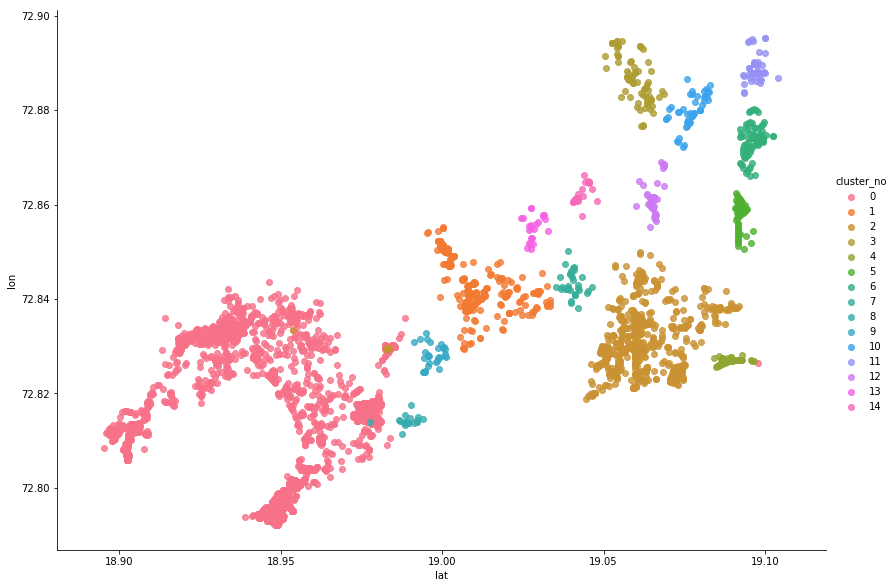

In [44]:
# Lets visualise the lat-long points with the clusters, 

import seaborn as sns
sns.lmplot('lat', 'lon', data=df_target_points, hue='cluster_no', fit_reg=False,height=8.27, aspect=11.7/8.27)
plt.show()

In [45]:
# lets, look at the number of data points per cluster, 
df_target_points=df_target_points.sort_values(by='cluster_no')
clusters_=[] # cluster numbers to be stored
number_of_points=[]  # number of points to be stored
for i in df_target_points.cluster_no.unique():
    tempdf=df_target_points[df_target_points.cluster_no==i]
    clusters_.append(i)
    number_of_points.append(len(tempdf))
    print('total data points of cluster '+str(i)+' is '+str(len(tempdf)))

total data points of cluster 0 is 3238
total data points of cluster 1 is 368
total data points of cluster 2 is 739
total data points of cluster 3 is 73
total data points of cluster 4 is 56
total data points of cluster 5 is 53
total data points of cluster 6 is 80
total data points of cluster 7 is 34
total data points of cluster 8 is 23
total data points of cluster 9 is 31
total data points of cluster 10 is 50
total data points of cluster 11 is 43
total data points of cluster 12 is 44
total data points of cluster 13 is 23
total data points of cluster 14 is 23


In [46]:
# Now create a data frame with cluster and the number of points, 
footfall_df=pd.DataFrame(columns=['cluster','total_points'])
footfall_df.cluster=clusters_
footfall_df.total_points=number_of_points

# lets sort the data frame on total points
footfall_df=footfall_df.sort_values(by='total_points', ascending=False)

In [47]:
footfall_df

,cluster,total_points
0,0,3238
2,2,739
1,1,368
6,6,80
3,3,73
4,4,56
5,5,53
10,10,50
12,12,44
11,11,43


In [48]:
# lets assign some number, to each category, this is assumed to be a number in an hour in a place
# this will be used for footfall analysis

category_dict={'tree':1,'monument':500,'restaurant':100,'marketplace':200,'books':20,'place_of_worship':30,'community_centre':50,
 'housing':300,'railway_station':200,'educational_institution':1000,'boutique':20,'cinema':200,'road':30,'hotel':150,
 'post_office':15,'gift_shop':20,'toilets':20,'cafe':40,'bank':30,'supermarket':100,'fuel':20,'embassy':50,
 'police':30,'pharmacy':10,'fire_station':15,'leisure':40,'bar':70,'convenience':50,'bus_station':15,'bakery':10,
 'hospital':500,'parking':40,'atm':5,'travel_agency':10,'government_office':200,'local_shop':20,'court':100,
 'vehicle':2,'salon':5,'private_company':400,'accessories':25,'bus_stop':15,'wine_shop':10,'hardware_shop':10,
 'hostel':200,'electronics':30,'clinic':15,'pub':80,'butcher':10,'laundry':20,'sabal_project':40}

In [49]:
#creating a new column called footfall, the values of it is taken from the dictionary created above
df_target_points["footfall"] = df_target_points["category"].apply(lambda x: category_dict.get(x))

In [50]:
# Now look at the dataframe
df_target_points.head()

,lat,lon,cluster_no,category,footfall
2438,18.957142,72.801276,0,tree,1.0
2609,18.973638,72.814365,0,tree,1.0
2610,18.973663,72.815382,0,tree,1.0
2611,18.973673,72.814258,0,tree,1.0
2612,18.973681,72.814325,0,tree,1.0


In [51]:
# Now calculate the footfall 

clusters_=[] # cluster numbers to be stored
footfall=[]  # footfall
for i in df_target_points.cluster_no.unique():
    tempdf=df_target_points[df_target_points.cluster_no==i]
    clusters_.append(i)
    footfall.append(np.sum(tempdf.footfall))
    print('total foorfall of cluster '+str(i)+' is '+str(np.sum(tempdf.footfall)))

total foorfall of cluster 0 is 131731.0
total foorfall of cluster 1 is 12366.0
total foorfall of cluster 2 is 69049.0
total foorfall of cluster 3 is 10916.0
total foorfall of cluster 4 is 3059.0
total foorfall of cluster 5 is 2790.0
total foorfall of cluster 6 is 3665.0
total foorfall of cluster 7 is 6570.0
total foorfall of cluster 8 is 1961.0
total foorfall of cluster 9 is 4890.0
total foorfall of cluster 10 is 7695.0
total foorfall of cluster 11 is 8540.0
total foorfall of cluster 12 is 7741.0
total foorfall of cluster 13 is 6765.0
total foorfall of cluster 14 is 2795.0


In [52]:
# Now lets create the data frame with clusters and footfall,

df_footfall=pd.DataFrame(columns=['cluster_no','total_footfall'])
df_footfall.cluster_no=clusters_
df_footfall.total_footfall=footfall

# now dort the df, based on the footfall

df_footfall=df_footfall.sort_values(by='total_footfall',ascending=False).reset_index(drop=True)

In [53]:
# look at the footfall now rank wise,
df_footfall['rank']=df_footfall.index+1
df_footfall  

,cluster_no,total_footfall,rank
0,0,131731.0,1
1,2,69049.0,2
2,1,12366.0,3
3,3,10916.0,4
4,11,8540.0,5
5,12,7741.0,6
6,10,7695.0,7
7,13,6765.0,8
8,7,6570.0,9
9,9,4890.0,10


cluster no: 0


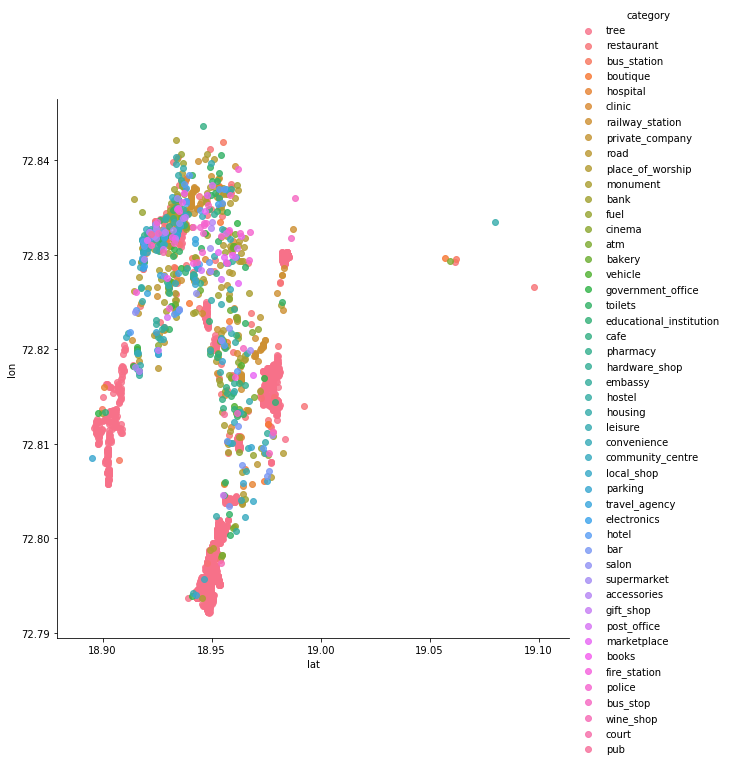

cluster no: 2


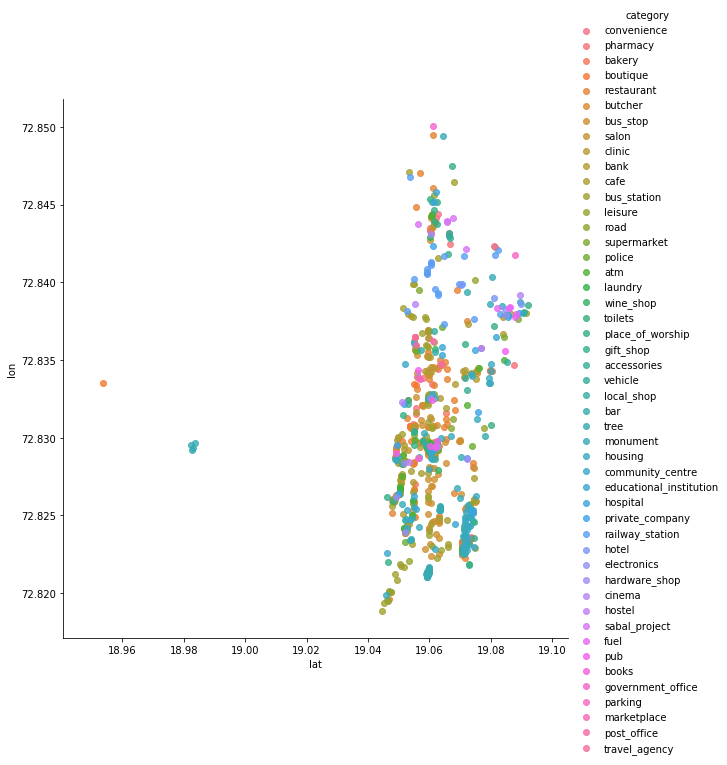

cluster no: 1


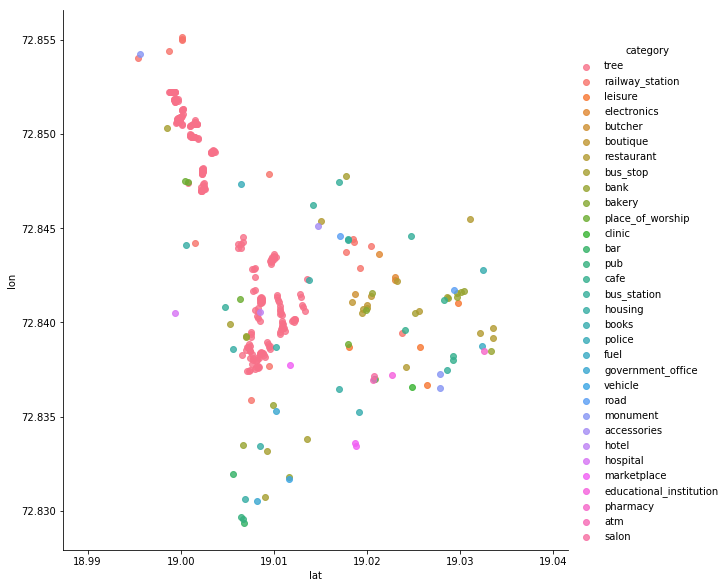

cluster no: 3


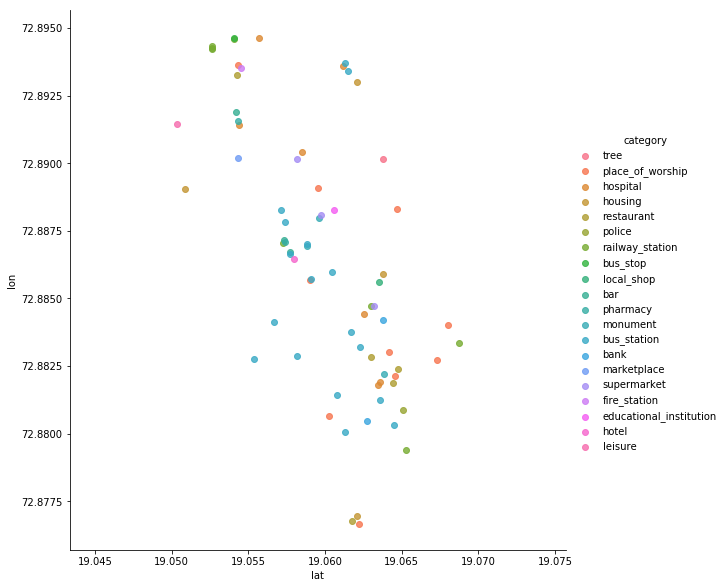

cluster no: 11


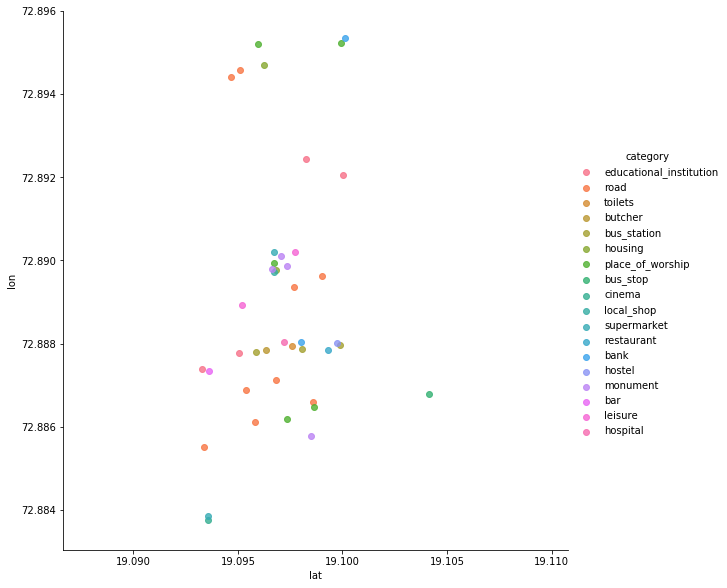

cluster no: 12


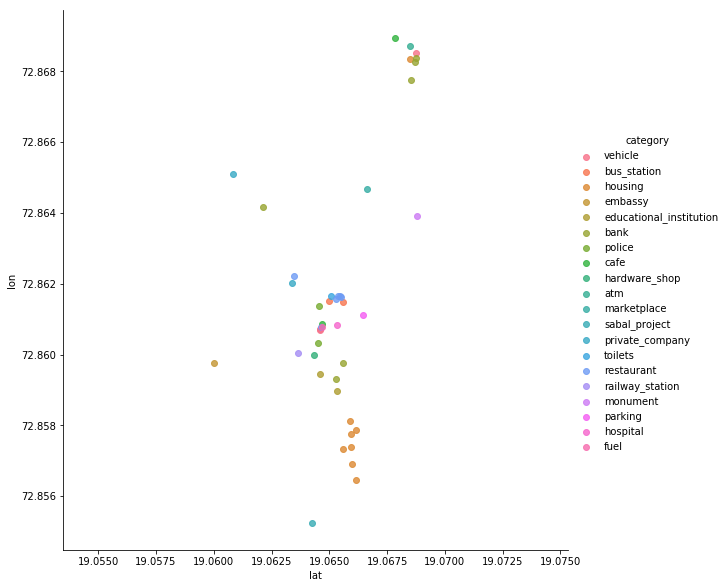

cluster no: 10


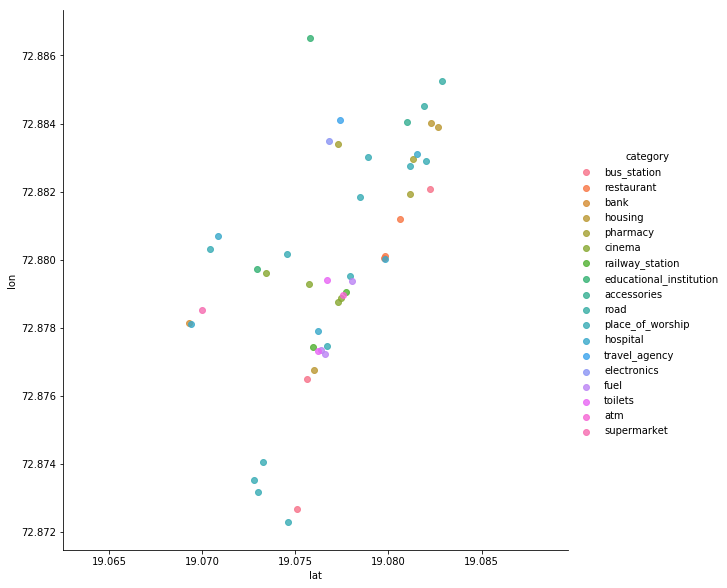

cluster no: 13


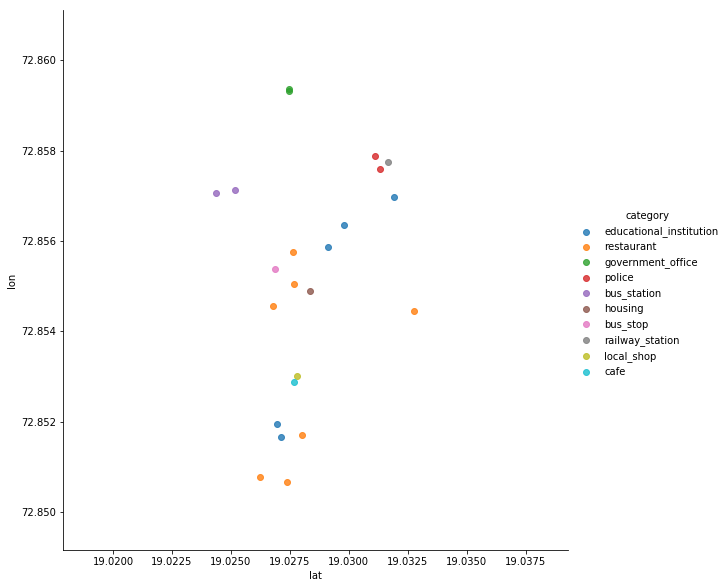

cluster no: 7


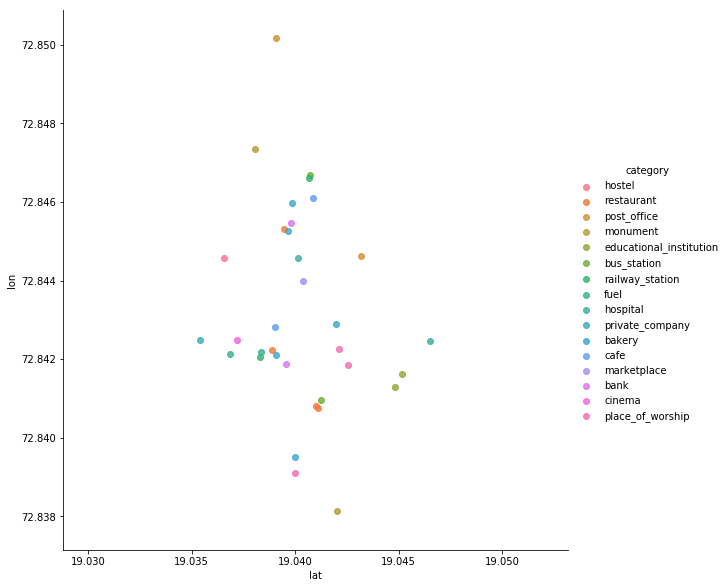

cluster no: 9


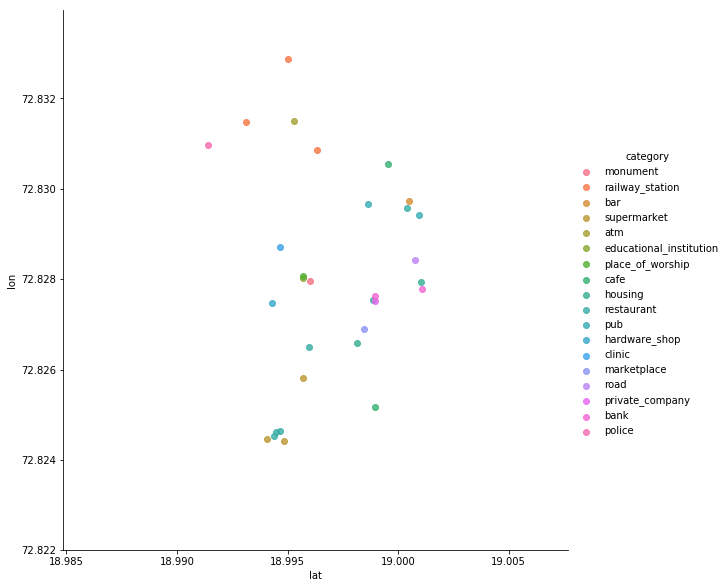

cluster no: 6


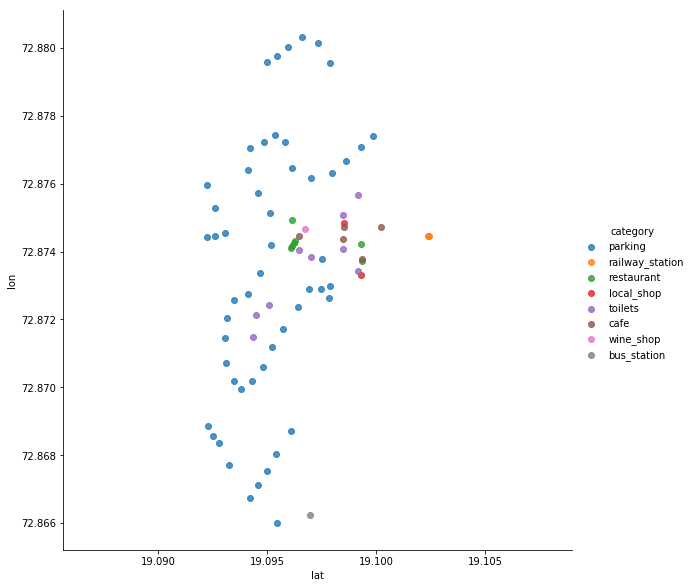

cluster no: 4


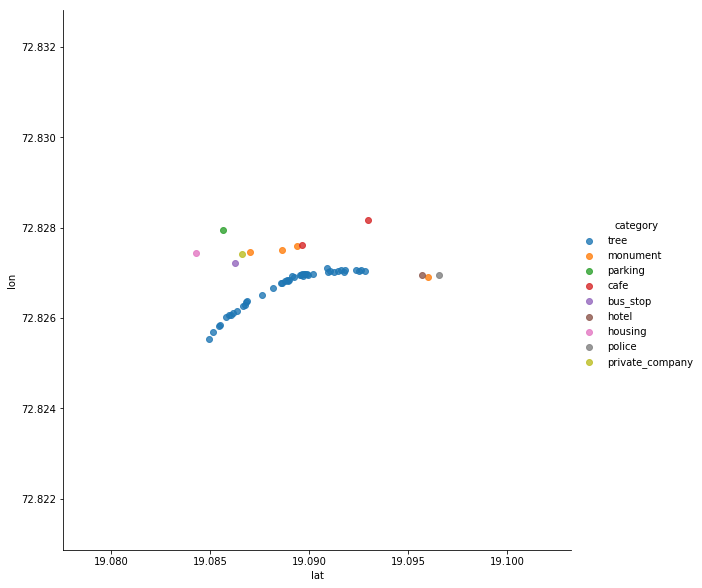

cluster no: 14


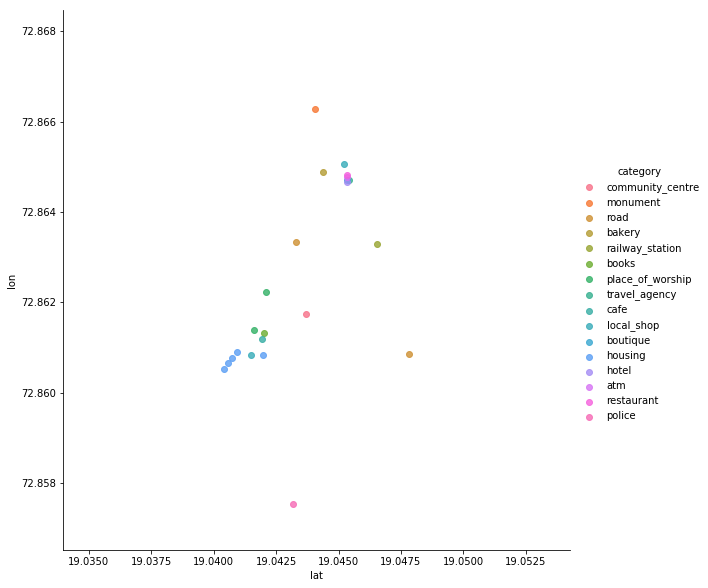

cluster no: 5


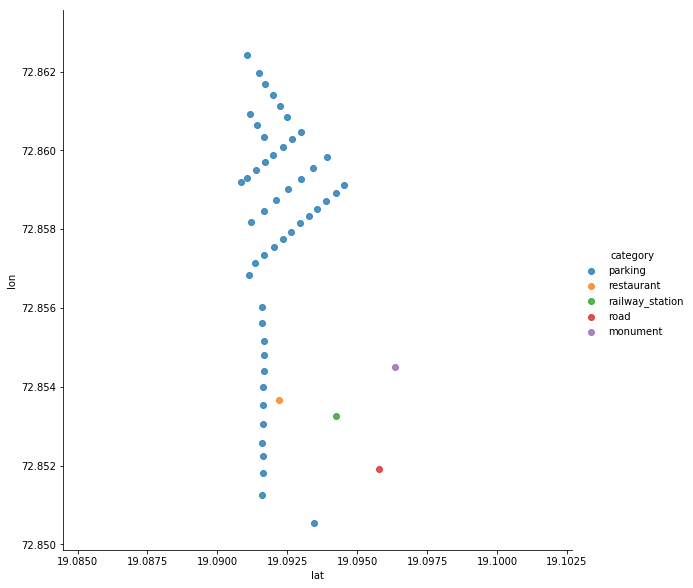

cluster no: 8


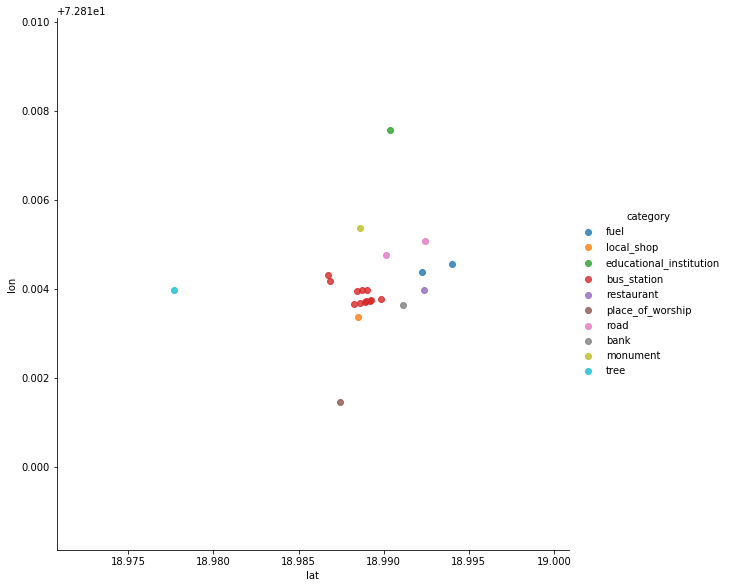

In [54]:
# Now lets visualise each and every cluster, with their cateogries
# interactive dash board can be done using qlicksence or tablue like visualisation applications, but I can't use
# my organisation's license for this purpose, hence I am using the python libraries called seaborn

for i in df_footfall.cluster_no.unique():
    xdf=df_target_points[df_target_points.cluster_no==i][['lat','lon','category']]
    print('cluster no: '+str(i))
    sns.lmplot('lat', 'lon', data=xdf, hue='category', fit_reg=False,height=8.27, aspect=10/10)
    plt.show()